# Advanced Lane Lines Detection

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Apply a perspective transform to rectify image ("birds-eye view").
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import pickle
import re
import math

%matplotlib inline

In [3]:
### Utility Functions

def tryint(s):
    try:
        return int(s)
    except:
        return s
     
def alphanum_key(s):
    ''' 
    Turn a string into a list of string and number chunks.
    E.g. "z23a" -> ["z", 23, "a"]
    '''
    return [tryint(c) for c in re.split('([0-9]+)', s)]

def sort_nicely(l):
    ''' 
    Sort the given list in the way that humans expect.
    '''
    l.sort(key=alphanum_key)
    
def plot_images(data, layout='row', cols=2, figsize=(20, 12)):
    '''
    Utility function for plotting images
    :param data [(ndarray, string)]: List of data to display, [(image, title)]
    :param layout (string): Layout, row-wise or column-wise
    :param cols (number): Number of columns per row
    :param figsize (number, number): Tuple indicating figure size
    '''
    rows = math.ceil(len(data) / cols)
    f, ax = plt.subplots(figsize=figsize)
    if layout == 'row':
        for idx, d in enumerate(data):
            img, title = d

            plt.subplot(rows, cols, idx+1)
            plt.title(title, fontsize=20)
            plt.axis('off')
            if len(img.shape) == 2:
                plt.imshow(img, cmap='gray')
                
            elif len(img.shape) == 3:
                plt.imshow(img)
                
    elif layout == 'col':
        counter = 0
        for r in range(rows):
            for c in range(cols):
                img, title = data[r + rows*c]
                nb_channels = len(img.shape)
                
                plt.subplot(rows, cols, counter+1)
                plt.title(title, fontsize=20)
                plt.axis('off')
                if len(img.shape) == 2:
                    plt.imshow(img, cmap='gray')
                
                elif len(img.shape) == 3:
                    plt.imshow(img)
              
                counter += 1

    return ax

def capture_frames(video_path, frames_dir):
    '''
    Utility function that captures and stores video frames
    :param video_path (string): Video path
    :param frames_dir (string): Frames directory
    '''
    cap = cv2.VideoCapture(video_path)

    print('Starting frame capture...')
    
    count = 0
    success = True
    while success:
        success, frame = cap.read()
        cv2.imwrite(frames_dir + 'frame{:02}.jpg'.format(count), frame)
        count += 1

    print('Completed!')
    

test_img_paths = glob.glob('test_images/test*.jpg')
sort_nicely(test_img_paths)

video1 = glob.glob('video_frames/frame*.jpg')
sort_nicely(video1)

video2 = glob.glob('video_frames_1/frame*.jpg')
sort_nicely(video2)

# List of all demos to visualise
plot_demo = [1, 2, 3, 4, 5, 6, 7, 8]

## 1. Camera Calibration & Distortion correction

Compute the camera calibration matrix and distortion coefficients

In [4]:
def calibrate_camera():
    '''
    Computes the camera calibration matrix and distortion coefficients
    :return: Camera calibration matrix and distortion coefficients
    '''
    
    imgpaths = glob.glob('camera_cal/calibration*.jpg')
    sort_nicely(img_paths)
    
    # View a sample calibration image
    %matplotlib inline
    
    image = cv2.imread(imgpaths[0])
    imshape = image.shape[:2] # gets only the (height, width) to be used in the cv2.calibrateCamera()
    
    plt.imshow(image)
    plt.show()
    print('Image shape: {}'.format(image.shape))

    %matplotlib qt
    print()
    print('Calibrating the camera...')
    print()

    objpoints = []
    imgpoints = []

    nx = 9 # Number of inside corners on each row of the chessboard
    ny = 6 # Number of inside corners on each column of the chessboard

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros([ny*nx, 3], dtype=np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Iterate over each calibration image and determine the objpoints and imgpoints
    for idx, imgpath in enumerate(imgpaths):
        img = cv2.imread(imgpath)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret:
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

            imgpoints.append(corners)
            objpoints.append(objp)

            cv2.imshow('img', img)
            cv2.waitKey(500)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imshape[::-1], None, None)
   
    print('Calibration complete!')
    cv2.destroyAllWindows()
    return mtx, dist

# Note: the calibration process only needs to be run once in the absense of the pickled file
# containing the calculated aforementioned params
if os.path.exists('camera_calib.p'):
    with open('camera_calib.p', mode='rb') as f:
        data = pickle.load(f)
        mtx, dist = data['mtx'], data['dist']
        print('Loaded the saved camera calibration matrix & dist coefficients!')
else:
    mtx, dist = calibrate_camera()
    with open('camera_calib.p', mode='wb') as f:
        pickle.dump({'mtx': mtx, 'dist': dist}, f)

def undistort(img, mtx, dist):
    '''
    Undistorts an image
    :param img (ndarray): Image, represented an a numpy array
    :param mtx: Camera calibration matrix
    :param dist: Distortion coeff's
    :return : Undistorted image
    '''
    
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    return undistort

Loaded the saved camera calibration matrix & dist coefficients!


### 1.1 Demo

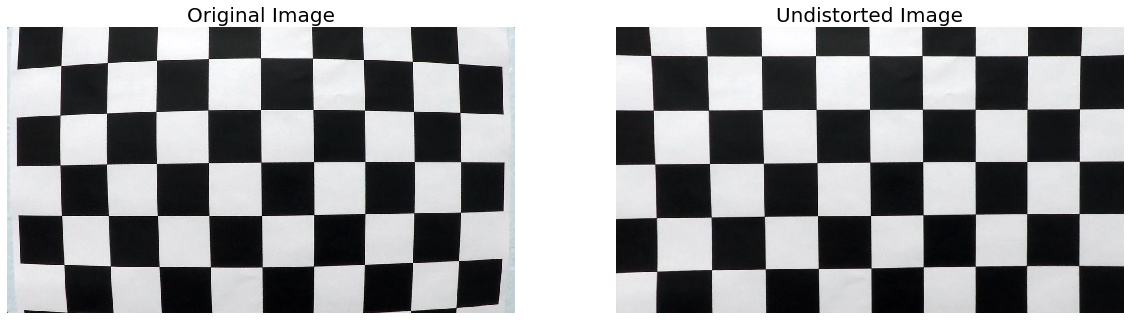

In [5]:
# Undistort a sample camera calibration image and a sample test image

if 1 in plot_demo:
    ccimg = cv2.imread('camera_cal/calibration1.jpg')
    ccimg_undist = undistort(ccimg, mtx, dist)

    plot_images([
        (ccimg, 'Original Image'),
        (ccimg_undist, 'Undistorted Image')
    ])
    
    img_orig = mpimg.imread(test_img_paths[6])
    img = undistort(img_orig, mtx, dist)

    plot_images([
        (img_orig, 'Original Image'),
        (img, 'Undistorted Image')
    ])

## 2. Perspective Transformation

In [6]:
IMG_SHAPE = (720, 1280)

def get_roi(img, vertices):
    '''
    Transforms an image by preserving only the ROI represented by the
    the 'vertices' and removes the remainder of the image by setting the pixel intensity to 0
    :param img (ndarray): Image
    :param vertices (ndarray): Region of Interest of the image
    :return : Modified image
    '''
    
    vertices = np.array(vertices, ndmin=3, dtype=np.int32)
    if len(img.shape) == 3:
        fill_color = (255,) * 3
    else:
        fill_color = 255
            
    mask = np.zeros_like(img)
    mask = cv2.fillPoly(mask, vertices, fill_color)
    return cv2.bitwise_and(img, mask)
    
def warp_image(img, warp_shape, src, dst):
    '''
    Performs perspective transformation (PT)
    :param img (ndarray): Image
    :param warp_shape: Shape of the warped image
    :param src (ndarray): Source points
    :param dst (ndarray): Destination points
    :return : Tuple (Transformed image, PT matrix, PT inverse matrix)
    '''
    
    # Get the perspective transformation matrix and its inverse
    M = cv2.getPerspectiveTransform(src, dst)
    invM = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image
    warped = cv2.warpPerspective(img, M, warp_shape, flags=cv2.INTER_LINEAR)
    return warped, M, invM

def preprocess_image(img, visualise=False):
    '''
    Pre-processes an image. Steps include:
    1. Distortion correction
    2. Perspective Transformation
    3. ROI crop
    
    :param img (ndarray): Original Image
    :param visualise (boolean): Boolean flag for visualisation
    :return : Pre-processed image, (PT matrix, PT inverse matrix)
    '''
    
    ysize = img.shape[0]
    xsize = img.shape[1]
    
    # 1. Distortion correction
    undist = undistort(img, mtx, dist)
    
    # 2. Perspective transformation
    src = np.float32([
        (696,455),    
        (587,455), 
        (235,700),  
        (1075,700)
    ])

    dst = np.float32([
        (xsize - 350, 0),
        (350, 0),
        (350, ysize),
        (xsize - 350, ysize)
    ])

    warped, M, invM = warp_image(undist, (xsize, ysize), src, dst)

    # 3. ROI crop
    vertices = np.array([
        [200, ysize],
        [200, 0],
        [1100, 0],
        [1100, ysize]
    ])

    roi = get_roi(warped, vertices)

    # 4. Visualise the transformation
    if visualise:
        img_copy = np.copy(img)
        roi_copy = np.copy(roi)
        
        cv2.polylines(img_copy, [np.int32(src)], True, (255, 0, 0), 3)
        cv2.polylines(roi_copy, [np.int32(dst)], True, (255, 0, 0), 3)
        
        plot_images([
            (img_copy, 'Original Image'),
            (roi_copy, 'Bird\'s Eye View Perspective')
        ])

    return roi, (M, invM)

def get_image(img_path, visualise=False):
    '''
    Load an image from the 'img_path' and pre-process it
    :param img_path (string): Image path
    :param visualise (boolean): Boolean flag for visualisation
    :return : Transformed Image, (PT matrix, PT inv matrix)
    '''
    img = mpimg.imread(img_path)
    return preprocess_image(img, visualise=visualise)

### 2.1 Demo

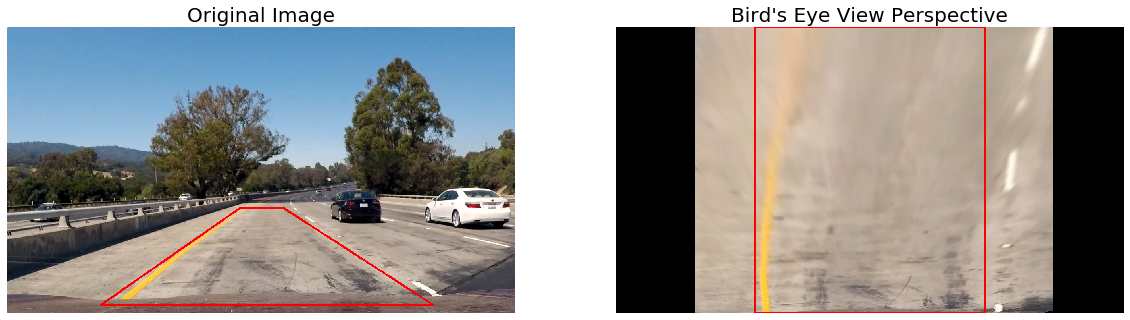

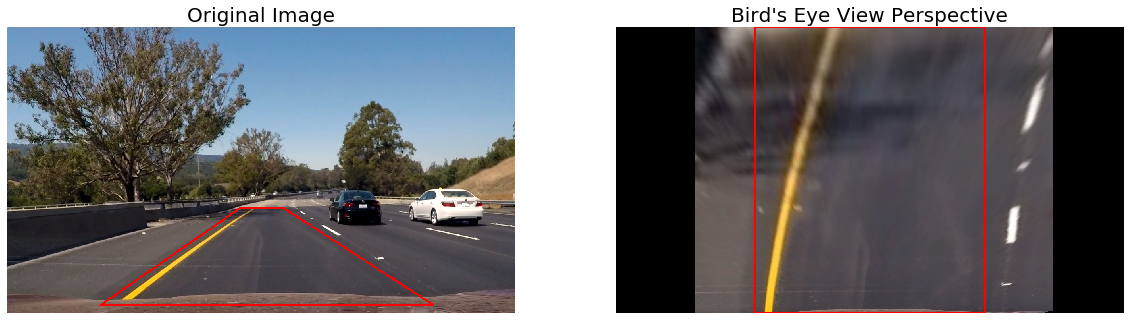

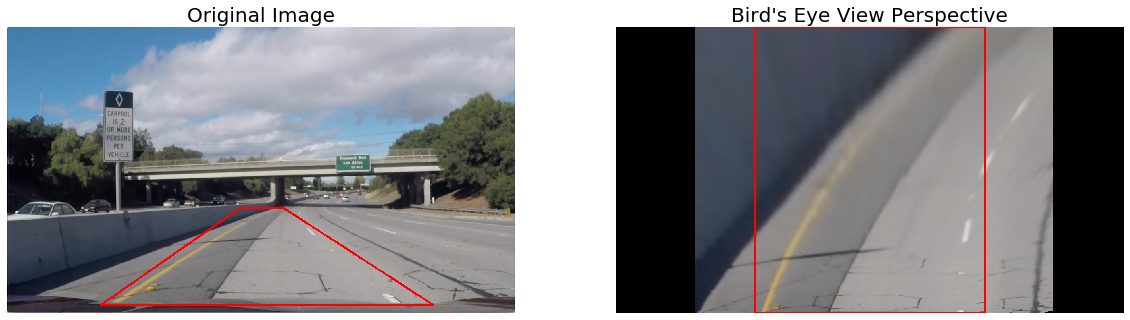

In [7]:
if 2 in plot_demo:
    for path in test_img_paths[:]:
        get_image(path, visualise=True)

## 3. Generate Thresholded Binary image

In [8]:
def binary_threshold(img, low, high):    
    if len(img.shape) == 2:
        output = np.zeros_like(img)
        mask = (img >= low) & (img <= high)
        
    elif len(img.shape) == 3:
        output = np.zeros_like(img[:,:,0])
        mask = (img[:,:,0] >= low[0]) & (img[:,:,0] <= high[0]) \
            & (img[:,:,1] >= low[1]) & (img[:,:,1] <= high[1]) \
            & (img[:,:,2] >= low[2]) & (img[:,:,2] <= high[2])
            
    output[mask] = 1
    return output

def get_binary_image(img, visualise=False):
    """
    Generate a thresholded binary image using transforms from an ensemble of color spaces: 
    LAB (Yellow), HSV (Yellow + White), HLS (Yellow + White), RGB (White) and 
    Adaptive Thresholding ()
    :param img (ndarray): Warped image
    :param visualise (boolean): Boolean flag for visualisation
    :return (ndarray): Thresholded binary image
    """
    
    ### LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0]
    L_max, L_mean = np.max(L), np.mean(L)
    B = lab[:,:,2]
    B_max, B_mean = np.max(B), np.mean(B)

    # YELLOW
    L_adapt_yellow = max(80, int(L_max * 0.45))
    B_adapt_yellow =  max(int(B_max * 0.70), int(B_mean * 1.2))
    lab_low_yellow = np.array((L_adapt_yellow, 120, B_adapt_yellow))
    lab_high_yellow = np.array((255, 145, 255))

    lab_yellow = binary_threshold(lab, lab_low_yellow, lab_high_yellow)
    lab_binary =lab_yellow
      
    ### HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H = hsv[:,:,0]
    H_max, H_mean = np.max(H), np.mean(H)
    S = hsv[:,:,1]
    S_max, S_mean = np.max(S), np.mean(S)
    V = hsv[:,:,2]
    V_max, V_mean = np.max(V), np.mean(V)
    
    # YELLOW
    S_adapt_yellow =  max(int(S_max * 0.25), int(S_mean * 1.75))
    V_adapt_yellow =  max(50, int(V_mean * 1.25))
    hsv_low_yellow = np.array((15, S_adapt_yellow, V_adapt_yellow))
   
    hsv_high_yellow = np.array((30, 255, 255))
    hsv_yellow = binary_threshold(hsv, hsv_low_yellow, hsv_high_yellow)    

    # WHITE
    V_adapt_white = max(150, int(V_max * 0.8),int(V_mean * 1.25))
    hsv_low_white = np.array((0, 0, V_adapt_white))
    hsv_high_white = np.array((255, 40, 220))

    hsv_white = binary_threshold(hsv, hsv_low_white, hsv_high_white)

    hsv_binary = hsv_yellow | hsv_white

    ### HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    L_max, L_mean = np.max(L), np.mean(L)
    S = hls[:,:,2]
    S_max, S_mean = np.max(S), np.mean(S)
 
    # YELLOW
    L_adapt_yellow = max(80, int(L_mean * 1.25))
    S_adapt_yellow = max(int(S_max * 0.25), int(S_mean * 1.75))
    hls_low_yellow = np.array((15, L_adapt_yellow, S_adapt_yellow))
    hls_high_yellow = np.array((30, 255, 255))

    hls_yellow = binary_threshold(hls, hls_low_yellow, hls_high_yellow)
    
    # WHITE
    L_adapt_white =  max(160, int(L_max *0.8),int(L_mean * 1.25))
    hls_low_white = np.array((0, L_adapt_white,  0))
    hls_high_white = np.array((255, 255, 255))

    hls_white = binary_threshold(hls, hls_low_white, hls_high_white)
        
    hls_binary = hls_yellow | hls_white

    ### R color channel (WHITE)
    R = img[:,:,0]
    R_max, R_mean = np.max(R), np.mean(R)
    
    R_low_white = min(max(150, int(R_max * 0.55), int(R_mean * 1.95)),230)
    R_binary = binary_threshold(R, R_low_white, 255)
    
    ### Adaptive thresholding: Gaussian kernel 
    # YELLOW
    
    adapt_yellow_S = cv2.adaptiveThreshold(hls[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow_B = cv2.adaptiveThreshold(lab[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -5)
    adapt_yellow = adapt_yellow_S & adapt_yellow_B
    
    # WHITE
    adapt_white_R = cv2.adaptiveThreshold(img[:,:,0], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white_L = cv2.adaptiveThreshold(hsv[:,:,2], 1, \
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 161, -27)
    adapt_white = adapt_white_R & adapt_white_L
    
                                                  
    adapt_binary =  adapt_yellow | adapt_white

    ### Ensemble Voting
    combined = np.asarray(R_binary + lab_binary + hls_binary + hsv_binary + adapt_binary, dtype=np.uint8)

    combined[combined < 3] = 0
    combined[combined >= 3] = 1

    if visualise:
        plot_images([
            (img, 'Original'),
            (R_binary, 'R'),
            (hls_binary, 'HLS'),
            (hsv_binary, 'HSV'),
            (lab_binary, 'LAB'),
            (adapt_binary, 'Adaptive Thresh'),
            (combined, 'Combined'),
#             (hls_white, 'hls_white'),
#             (hls_yellow, 'hls yellow'),
#             (lab_white, 'lab white'),
#             (lab_yellow, 'lab yello'),
        ], figsize=(32, 42))

    return  combined

### 3.1 Demo

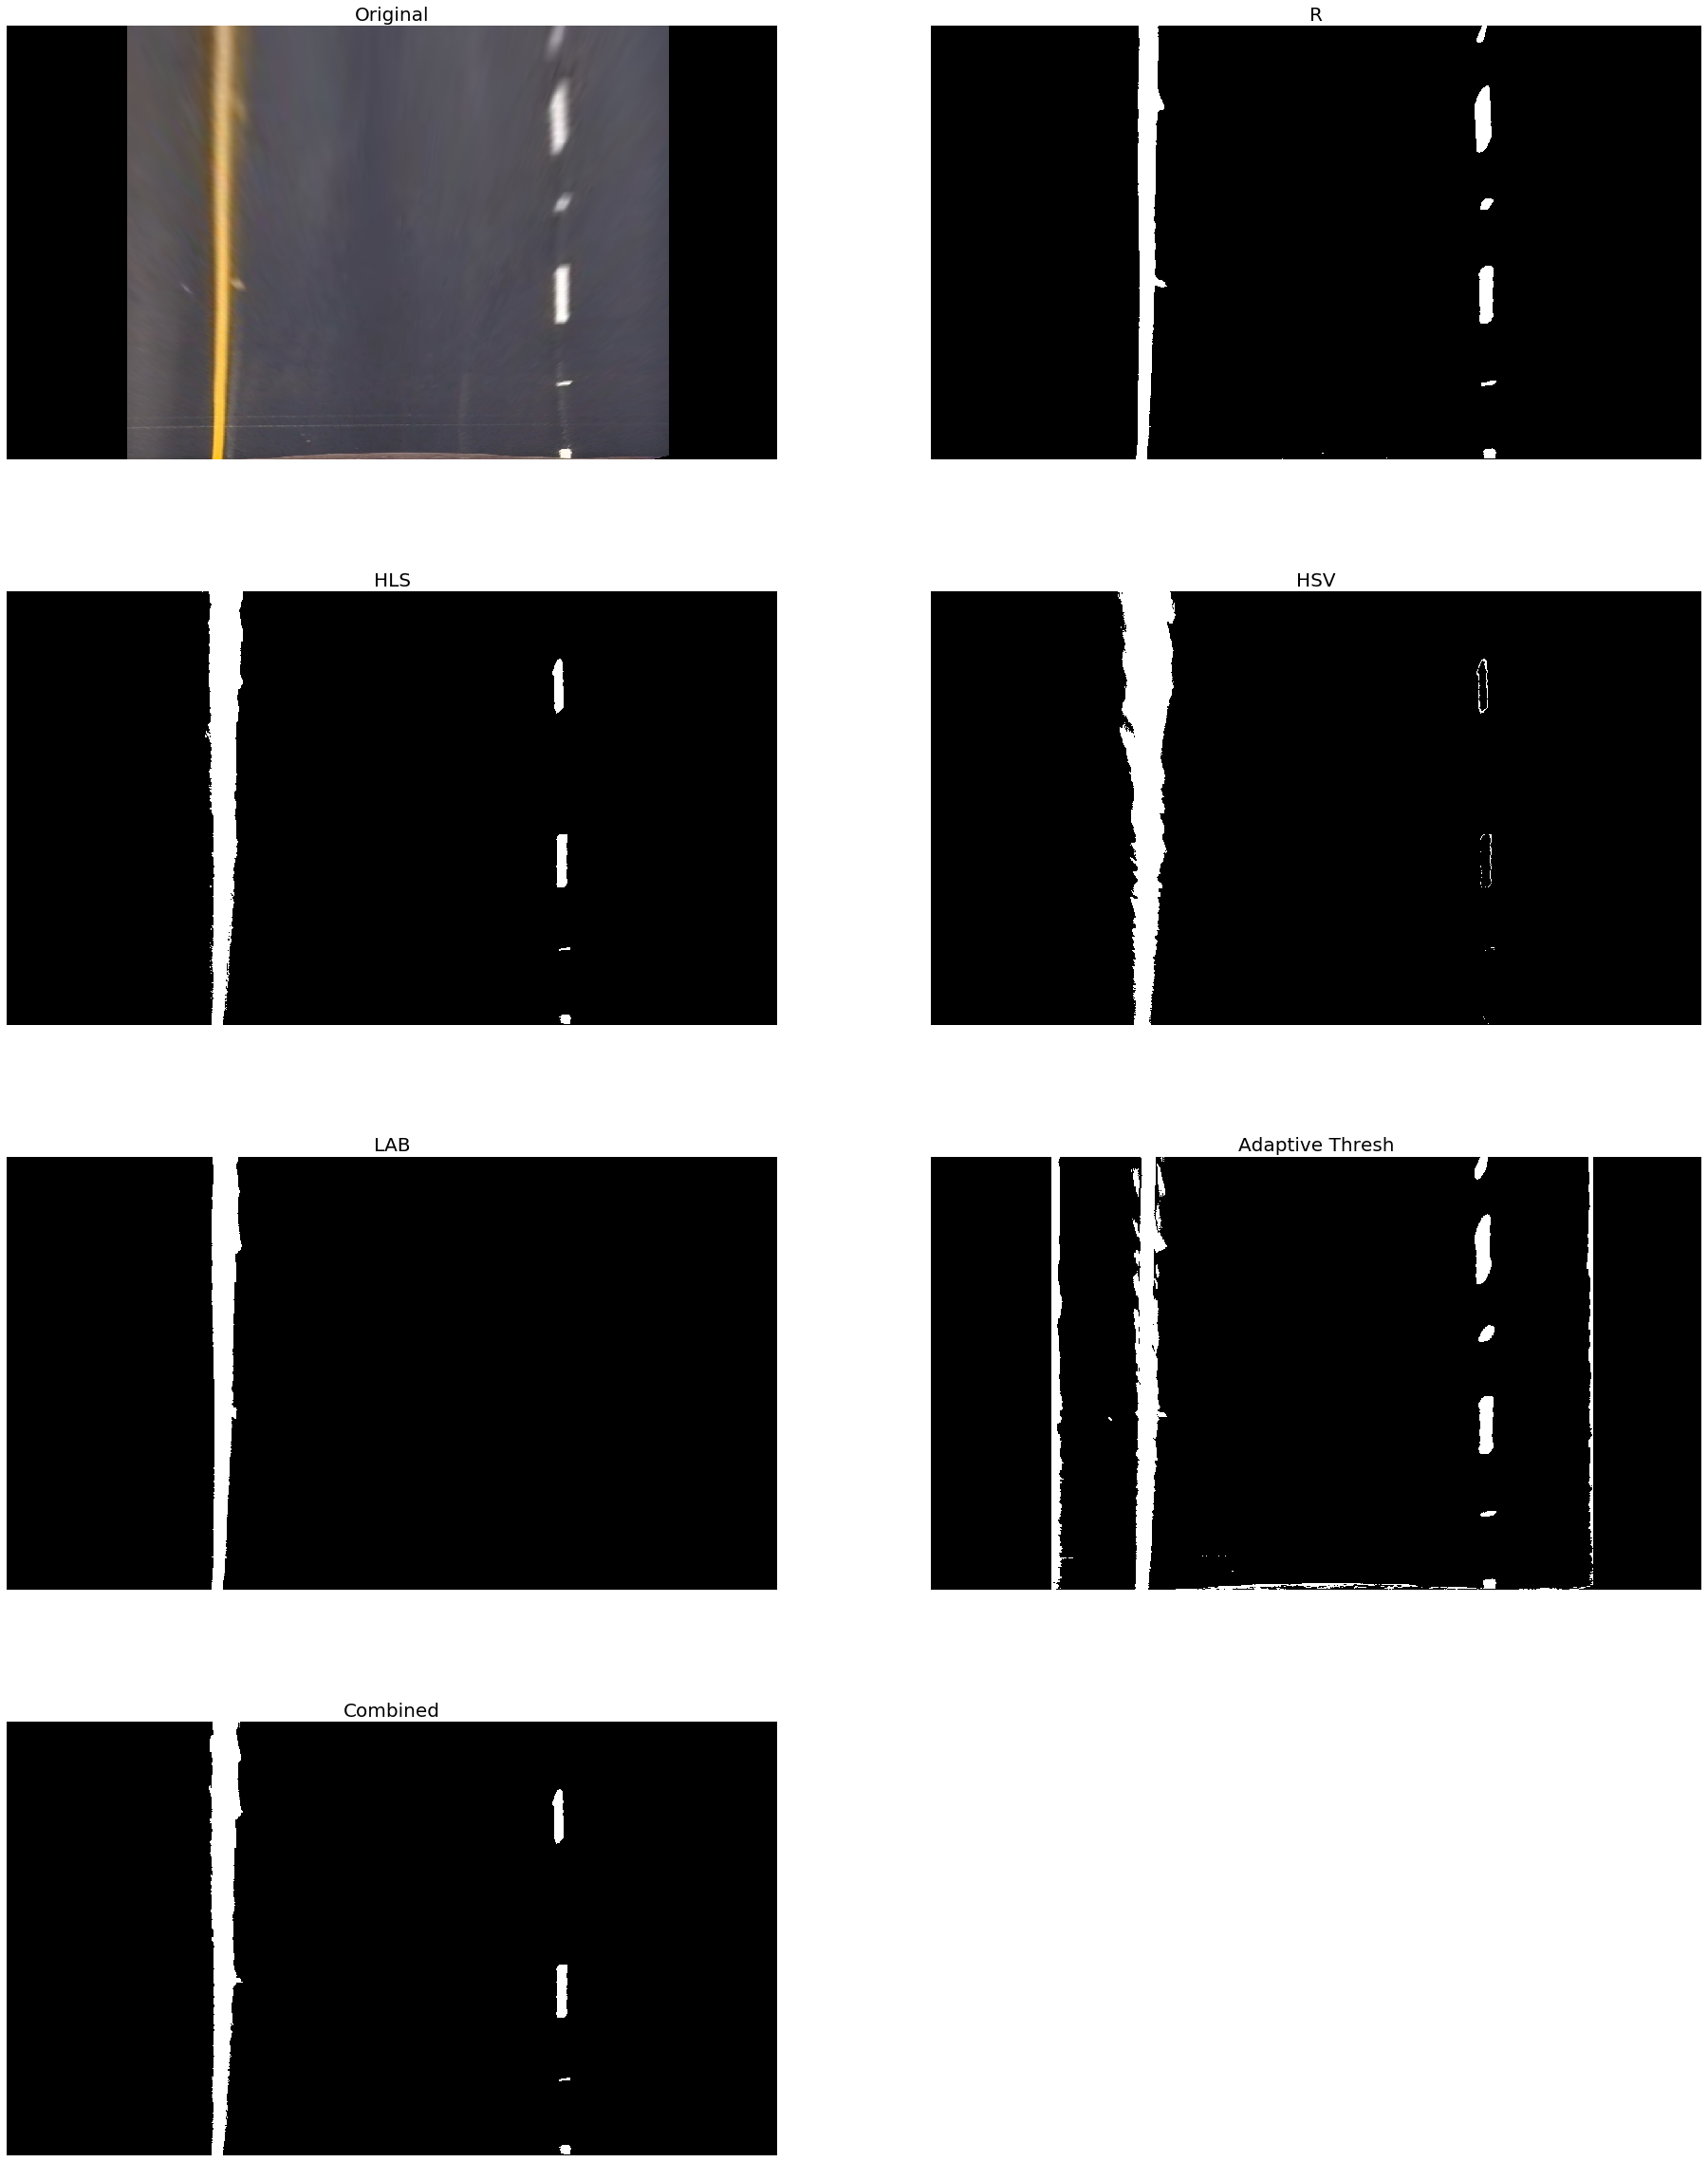

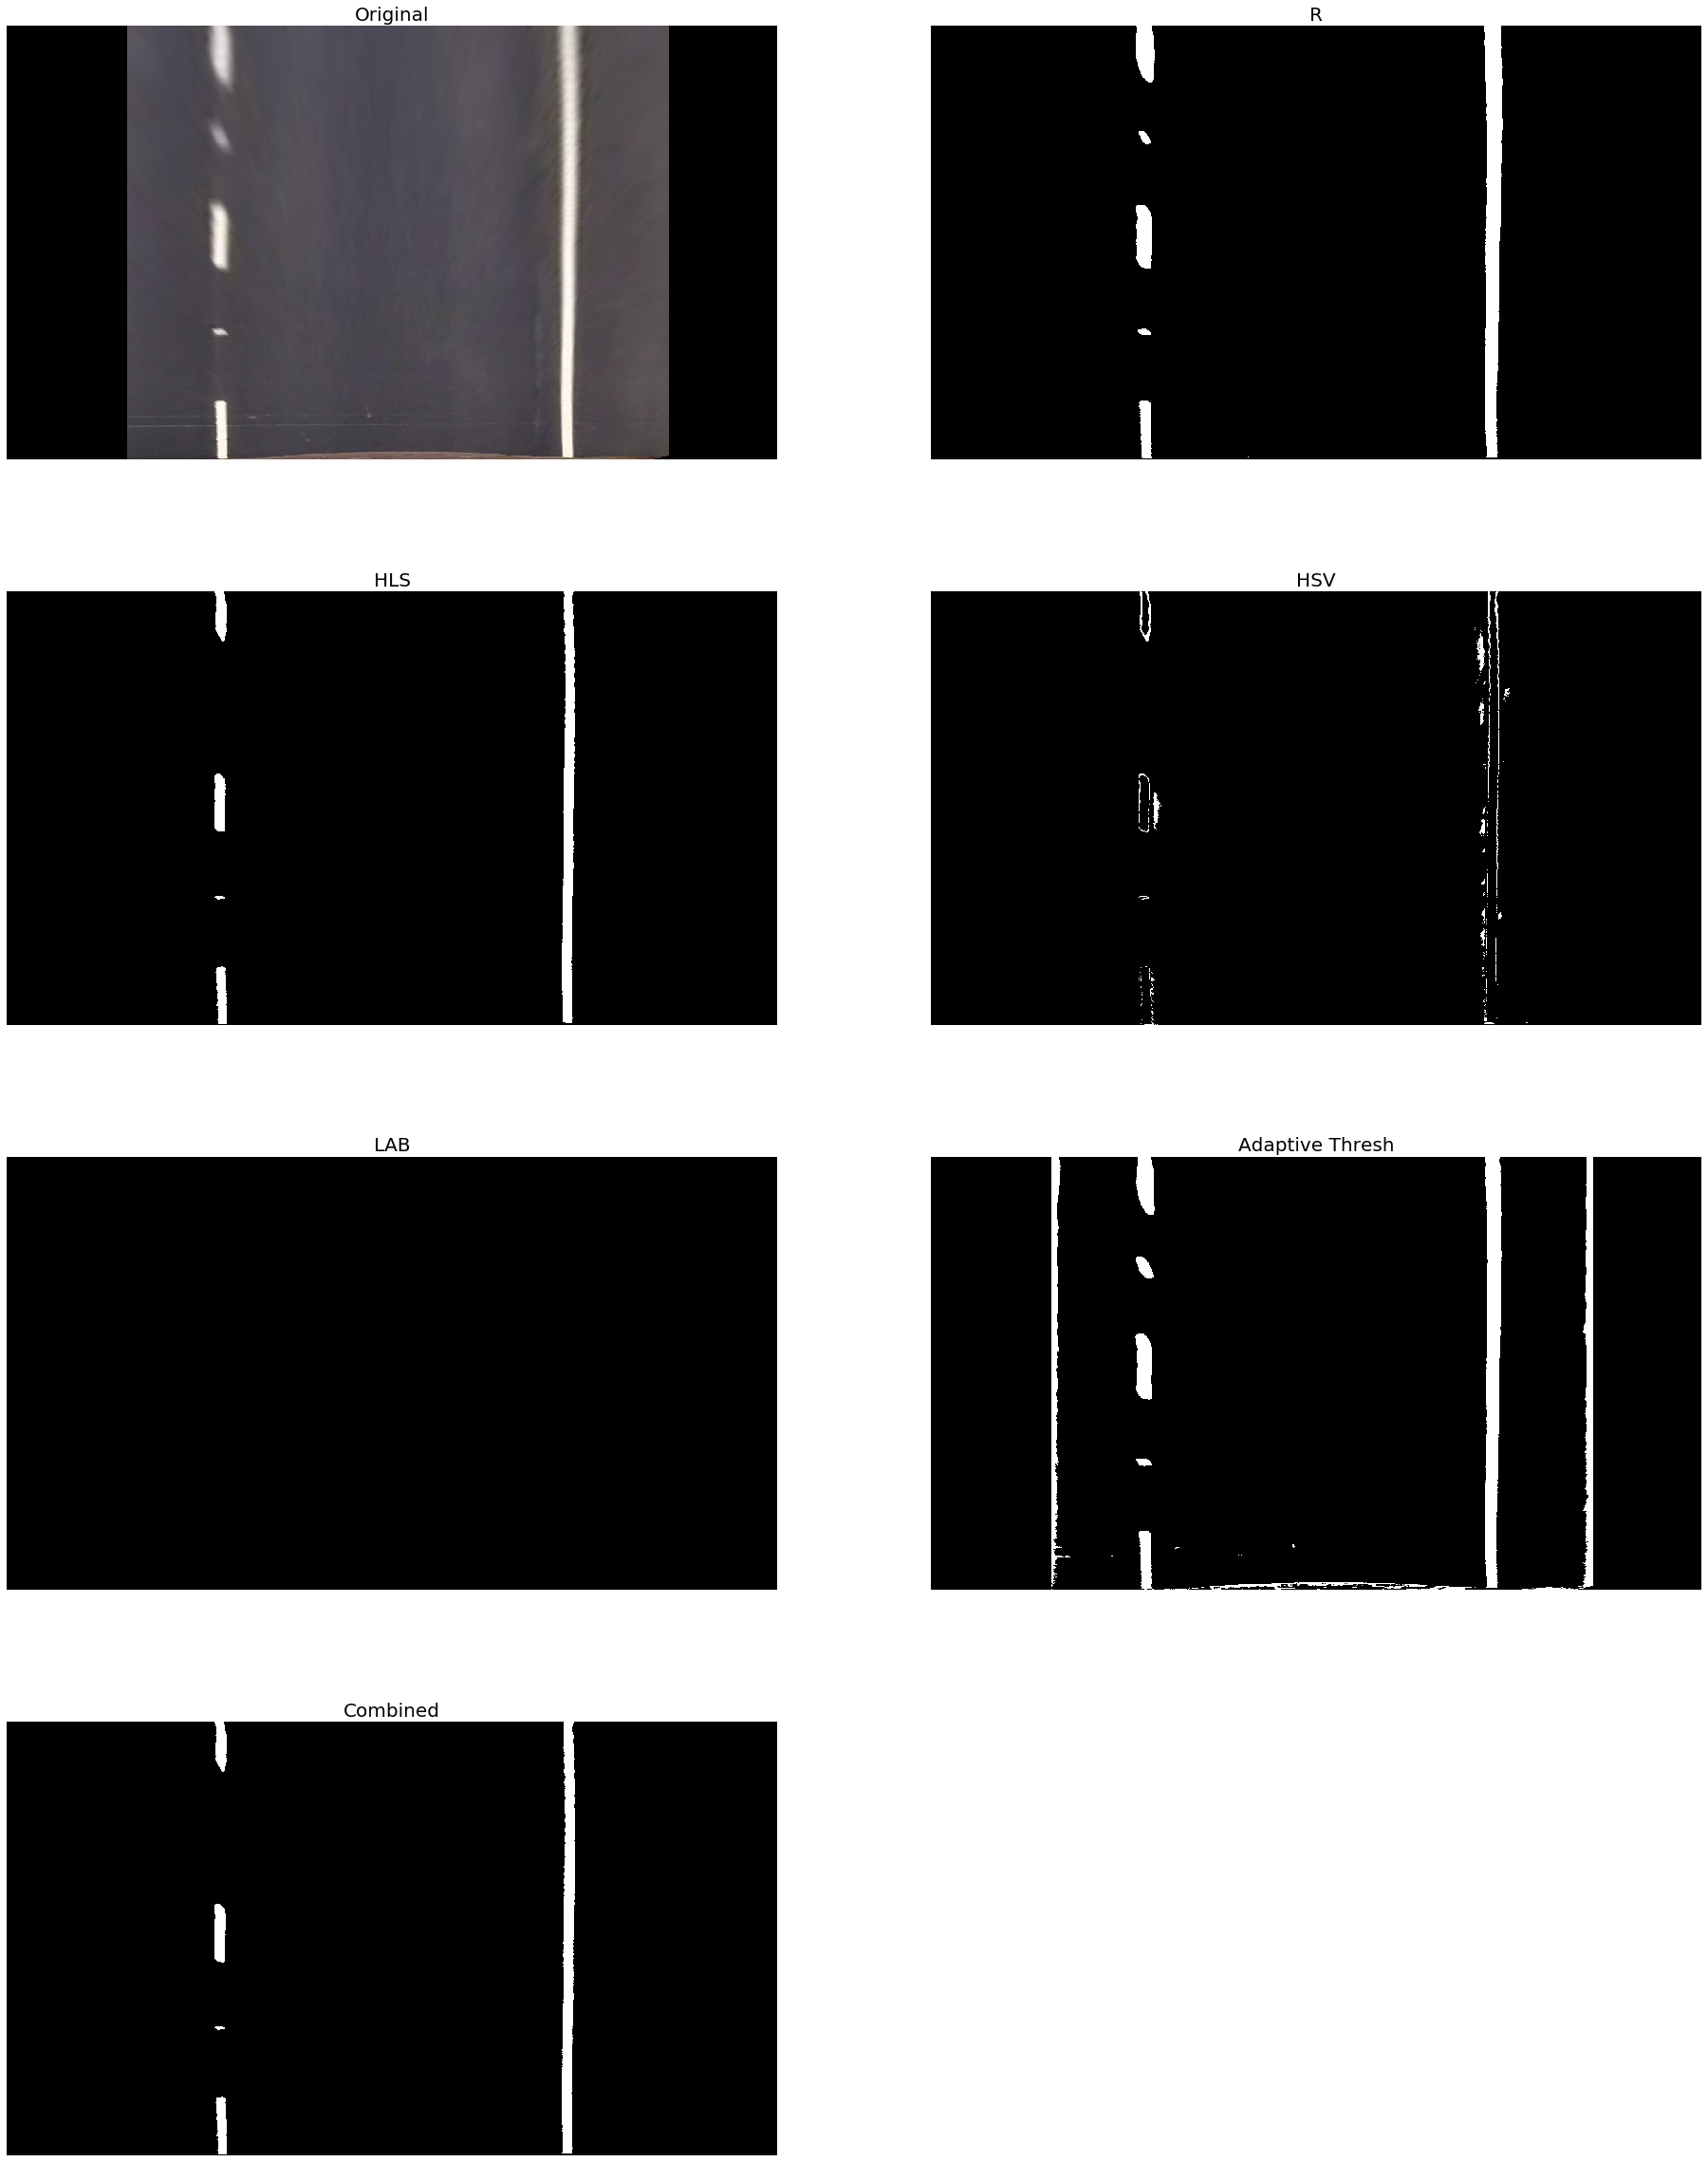

In [9]:
if 3 in plot_demo:
    for img_path in test_img_paths[:2]: #video2[5:10]:
        img, _ = get_image(img_path)
        get_binary_image(img, visualise=True)

## 4. Detect Lane Lines: Peaks in Histogram & Sliding Window Technique

In [10]:
def get_poly_points(left_fit, right_fit):
    '''
    Get the points for the left lane/ right lane defined by the polynomial coeff's 'left_fit'
    and 'right_fit'
    :param left_fit (ndarray): Coefficients for the polynomial that defines the left lane line
    :param right_fit (ndarray): Coefficients for the polynomial that defines the right lane line
    : return (Tuple(ndarray, ndarray, ndarray, ndarray)): x-y coordinates for the left and right lane lines
    '''
    ysize, xsize = IMG_SHAPE
    
    # Get the points for the entire height of the image
    plot_y = np.linspace(0, ysize-1, ysize)
    plot_xleft = left_fit[0] * plot_y**2 + left_fit[1] * plot_y + left_fit[2]
    plot_xright = right_fit[0] * plot_y**2 + right_fit[1] * plot_y + right_fit[2]
    
    # But keep only those points that lie within the image
    plot_xleft = plot_xleft[(plot_xleft >= 0) & (plot_xleft <= xsize - 1)]
    plot_xright = plot_xright[(plot_xright >= 0) & (plot_xright <= xsize - 1)]
    plot_yleft = np.linspace(ysize - len(plot_xleft), ysize - 1, len(plot_xleft))
    plot_yright = np.linspace(ysize - len(plot_xright), ysize - 1, len(plot_xright))
    
    return plot_xleft.astype(np.int), plot_yleft.astype(np.int), plot_xright.astype(np.int), plot_yright.astype(np.int)

def check_validity(left_fit, right_fit, diagnostics=False):
    '''
    Determine the validity of lane lines represented by a set of second order polynomial coefficients 
    :param left_fit (ndarray): Coefficients for the 2nd order polynomial that defines the left lane line
    :param right_fit (ndarray): Coefficients for the 2nd order polynomial that defines the right lane line
    :param diagnostics (boolean): Boolean flag for logging
    : return (boolean)
    '''
    
    if left_fit is None or right_fit is None:
        return False
    
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)

    # Check whether the two lines lie within a plausible distance from one another for three distinct y-values

    y1 = IMG_SHAPE[0] - 1 # Bottom
    y2 = IMG_SHAPE[0] - int(min(len(plot_yleft), len(plot_yright)) * 0.35) # For the 2nd and 3rd, take values between y1 and the top-most available value.
    y3 = IMG_SHAPE[0] - int(min(len(plot_yleft), len(plot_yright)) * 0.75)

    # Compute the respective x-values for both lines
    x1l = left_fit[0]  * (y1**2) + left_fit[1]  * y1 + left_fit[2]
    x2l = left_fit[0]  * (y2**2) + left_fit[1]  * y2 + left_fit[2]
    x3l = left_fit[0]  * (y3**2) + left_fit[1]  * y3 + left_fit[2]

    x1r = right_fit[0] * (y1**2) + right_fit[1] * y1 + right_fit[2]
    x2r = right_fit[0] * (y2**2) + right_fit[1] * y2 + right_fit[2]
    x3r = right_fit[0] * (y3**2) + right_fit[1] * y3 + right_fit[2]

    # Compute the L1 norms
    x1_diff = abs(x1l - x1r)
    x2_diff = abs(x2l - x2r)
    x3_diff = abs(x3l - x3r)

    # Define the threshold values for each of the three points
    min_dist_y1 = 480 # 510 # 530 
    max_dist_y1 = 730 # 750 # 660
    min_dist_y2 = 280
    max_dist_y2 = 730 # 660
    min_dist_y3 = 140
    max_dist_y3 = 730 # 660
    
    if (x1_diff < min_dist_y1) | (x1_diff > max_dist_y1) | \
        (x2_diff < min_dist_y2) | (x2_diff > max_dist_y2) | \
        (x3_diff < min_dist_y3) | (x3_diff > max_dist_y3):
        if diagnostics:
            print("Violated distance criterion: " +
                  "x1_diff == {:.2f}, x2_diff == {:.2f}, x3_diff == {:.2f}".format(x1_diff, x2_diff, x3_diff))
        return False

    # Check whether the line slopes are similar for two distinct y-values
    # x = Ay**2 + By + C
    # dx/dy = 2Ay + B
    
    y1left_dx  = 2 * left_fit[0]  * y1 + left_fit[1]
    y3left_dx  = 2 * left_fit[0]  * y3 + left_fit[1]
    y1right_dx = 2 * right_fit[0] * y1 + right_fit[1]
    y3right_dx = 2 * right_fit[0] * y3 + right_fit[1]

    # Compute the L1-norm
    norm1 = abs(y1left_dx - y1right_dx)
    norm2 = abs(y3left_dx - y3right_dx)
    
#     if diagnostics: print( norm1, norm2)

    # Define the L1 norm threshold
    thresh = 0.6 #0.58 
    if (norm1 >= thresh) | (norm2 >= thresh):
        if diagnostics:
            print("Violated tangent criterion: " +
                  "norm1 == {:.3f}, norm2 == {:.3f} (thresh == {}).".format(norm1, norm2, thresh))
            return False
    
    return True

def polyfit_sliding_window(binary, lane_width_px=578, visualise=False, diagnostics=False):
    '''
    Detect lane lines in a thresholded binary image using the sliding window technique
    :param binary (ndarray): Thresholded binary image
    :param lane_width_px (int): Average lane line width (in px) for the warped image 
    computed empirically
    :param visualise (boolean): Boolean flag for visualisation
    :param diagnositics (boolean): Boolean flag for logging
    '''
    
    global cache
    ret = True

    # Sanity check
    if binary.max() <= 0:
        return False, np.array([]), np.array([]), np.array([])
    
    # Step 1: Compute the histogram along all the columns in the lower half of the image. 
    # The two most prominent peaks in this histogram will be good indicators of the
    # x-position of the base of the lane lines
    histogram = None
    cutoffs = [int(binary.shape[0] / 2), 0]
    
    for cutoff in cutoffs:
        histogram = np.sum(binary[cutoff:, :], axis=0)
        
        if histogram.max() > 0:
            break

    if histogram.max() == 0:
        print('Unable to detect lane lines in this frame. Trying another frame!')
        return False, np.array([]), np.array([])
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    if visualise:
        plot_images([(binary, 'Binary')])
        plt.plot(histogram, 'm', linewidth=4.0)
        plt.plot((midpoint, midpoint), (0, IMG_SHAPE[0]), 'c')
        plt.plot((0, IMG_SHAPE[1]), (cutoff, cutoff), 'c')

    out = np.dstack((binary, binary, binary)) * 255

    nb_windows = 12 # number of sliding windows
    margin = 100 # width of the windows +/- margin
    minpix = 50 # min number of pixels needed to recenter the window
    window_height = int(IMG_SHAPE[0] / nb_windows)
    min_lane_pts = 10  # min number of 'hot' pixels needed to fit a 2nd order polynomial as a 
                    # lane line
    
    # Identify the x-y positions of all nonzero pixels in the image
    # Note: the indices here are equivalent to the coordinate locations of the
    # pixel
    nonzero = binary.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nb_windows):
        # Identify window boundaries in x and y (and left and right)
        win_y_low = IMG_SHAPE[0] - (1 + window) * window_height
        win_y_high = IMG_SHAPE[0] - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin

        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw windows for visualisation
        cv2.rectangle(out, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),\
                      (0, 255, 0), 2)
        cv2.rectangle(out, (win_xright_low, win_y_low), (win_xright_high, win_y_high),\
                      (0, 255, 0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)
                         & (nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)
                         & (nonzerox >= win_xright_low) & (nonzerox <= win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) >  minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))

        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract pixel positions for the left and right lane lines
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit = None, None
    
    # Sanity check; Fit a 2nd order polynomial for each lane line pixels
    if len(leftx) >= min_lane_pts and len(rightx) >= min_lane_pts:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Validate detected lane lines
    valid = check_validity(left_fit, right_fit, diagnostics=diagnostics)
   
    if not valid:
        # If the detected lane lines are NOT valid:
        # 1. Compute the lane lines as an average of the previously detected lines
        # from the cache and flag this detection cycle as a failure by setting ret=False
        # 2. Else, if cache is empty, return 
        
        if len(cache) == 0:
            if diagnostics: print('WARNING: Unable to detect lane lines in this frame.')
            return False, np.array([]), np.array([])
        
        avg_params = np.mean(cache, axis=0)
        left_fit, right_fit = avg_params[0], avg_params[1]
        ret = False
        
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)

    # Color the detected pixels for each lane line
    out[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 10, 255]

    left_poly_pts = np.array([np.transpose(np.vstack([plot_xleft, plot_yleft]))])
    right_poly_pts = np.array([np.transpose(np.vstack([plot_xright, plot_yright]))])

    # Plot the fitted polynomial
    cv2.polylines(out, np.int32([left_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)
    cv2.polylines(out, np.int32([right_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)

    if visualise:
        plot_images([(img, 'Original'), (out, 'Out')], figsize=(30, 40))
        
    return ret, out, np.array([left_fit, right_fit])

### 4.1 Demo

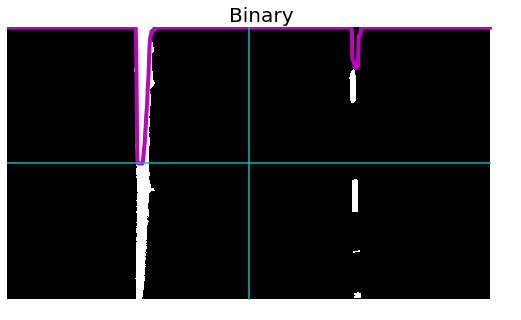

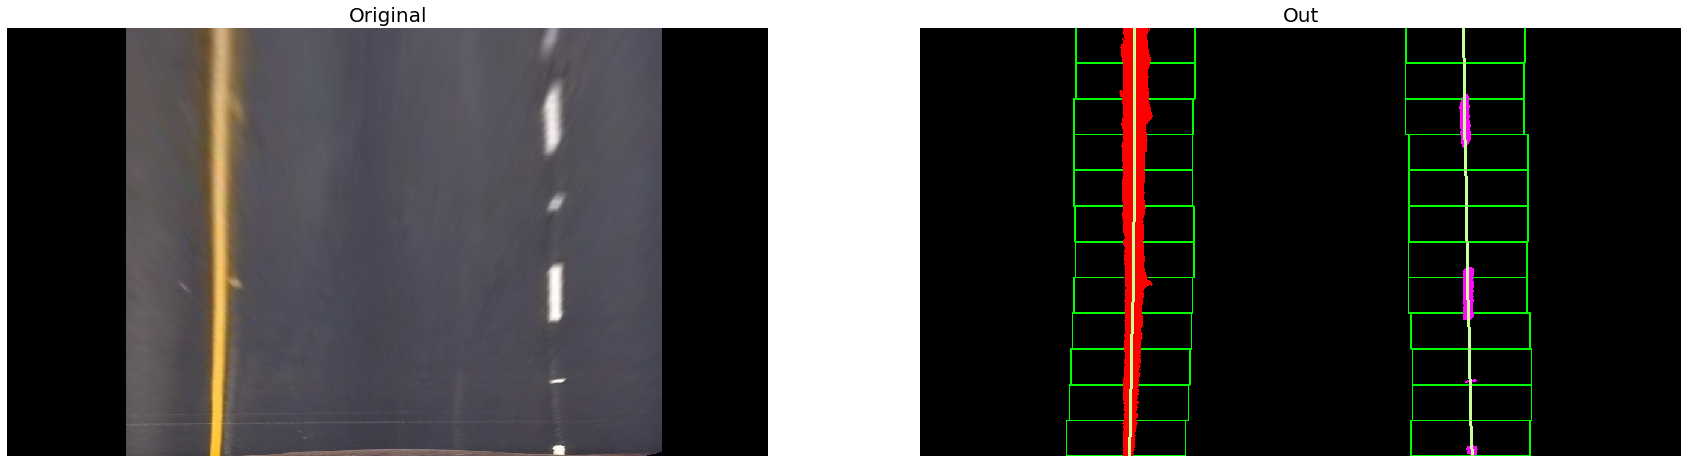

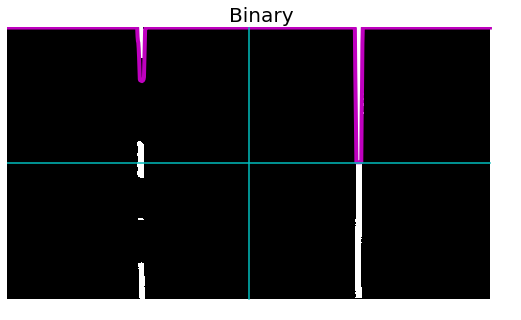

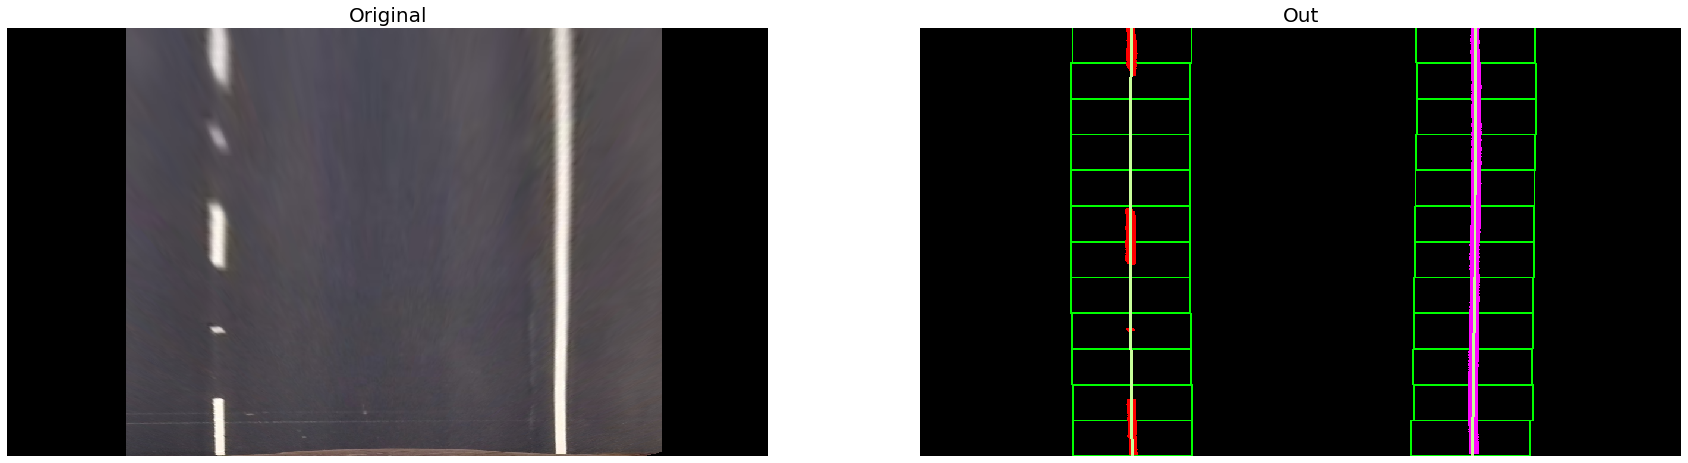

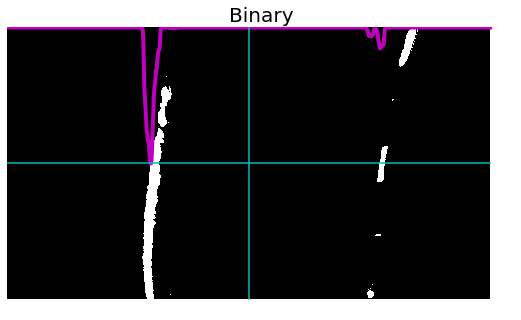

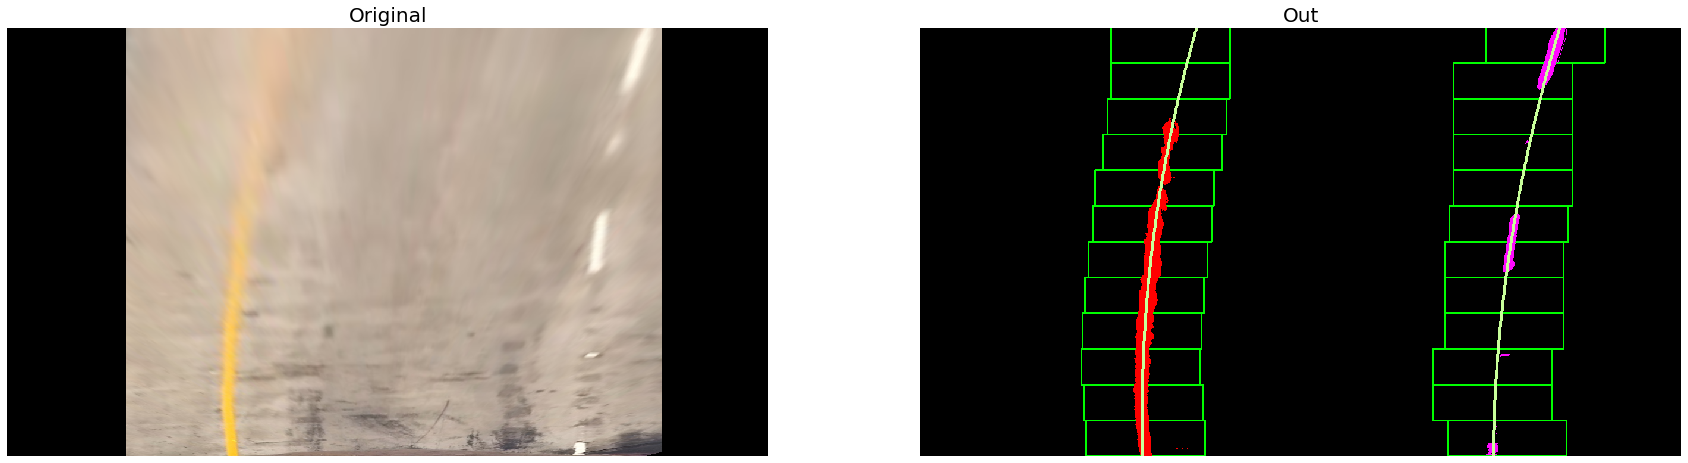

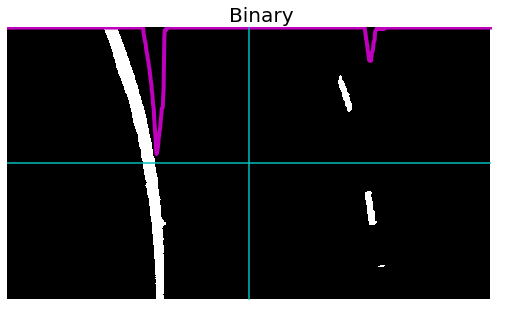

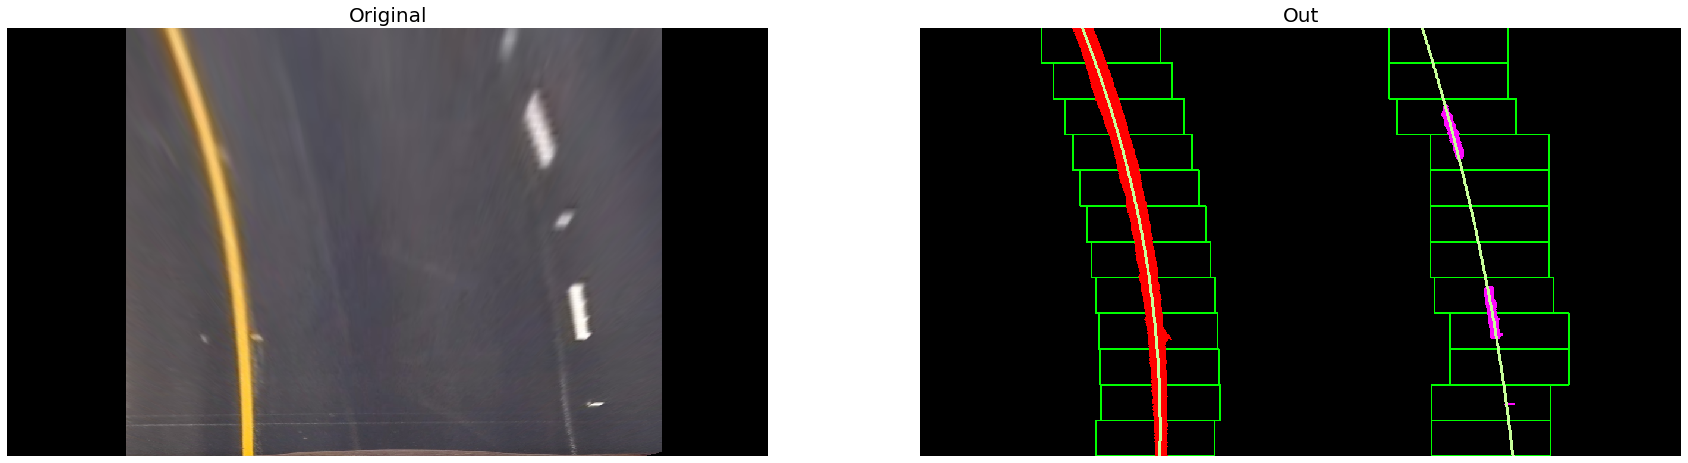

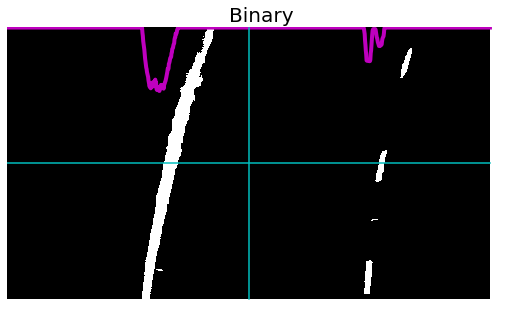

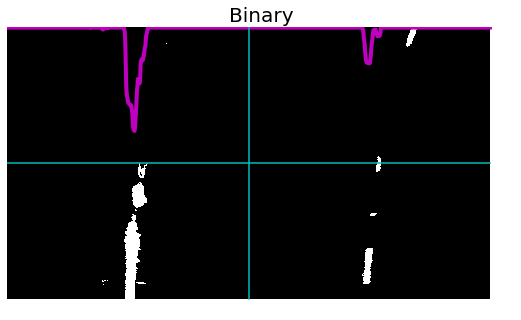

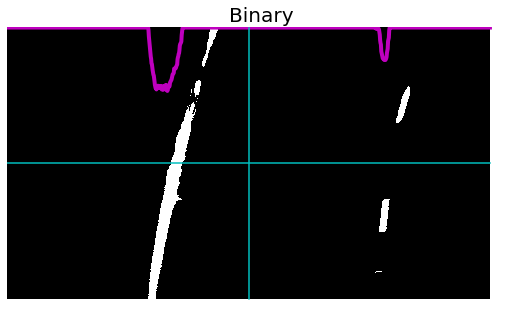

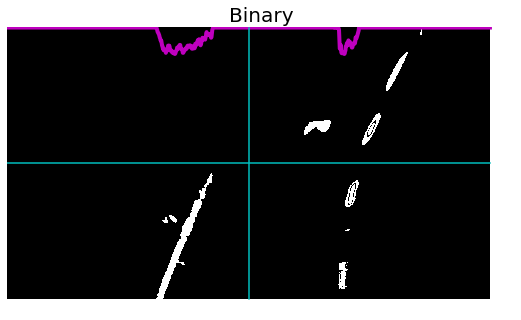

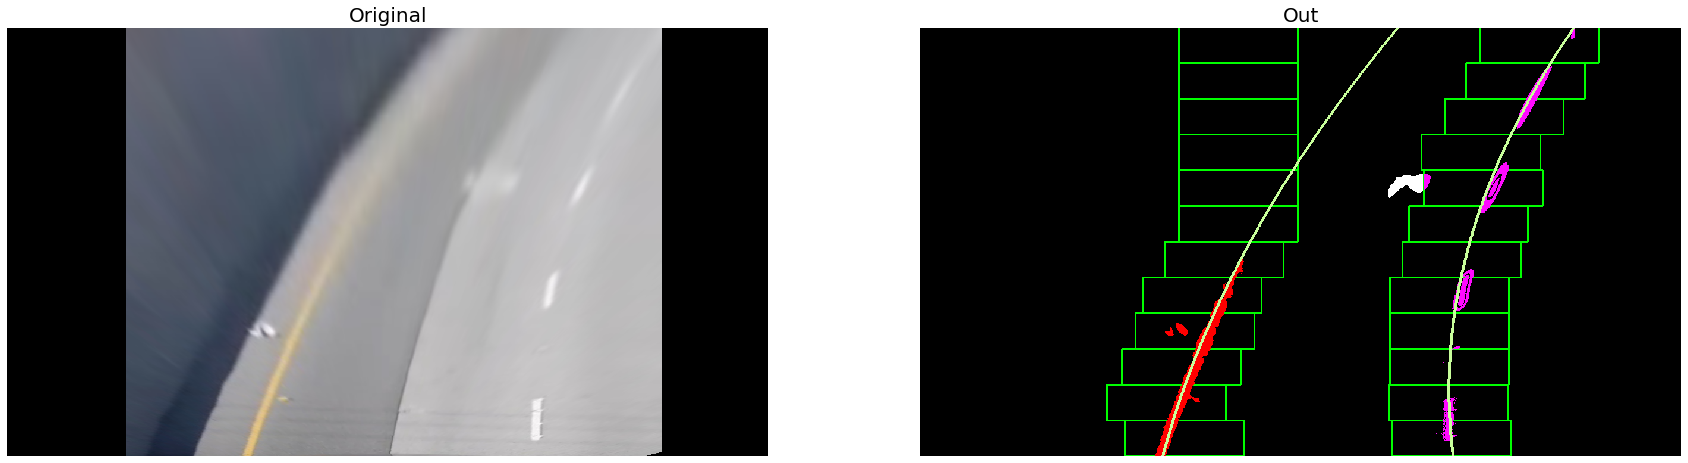

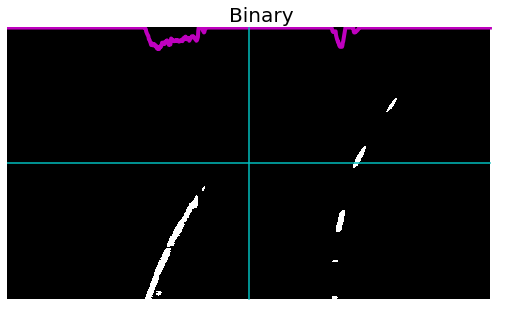

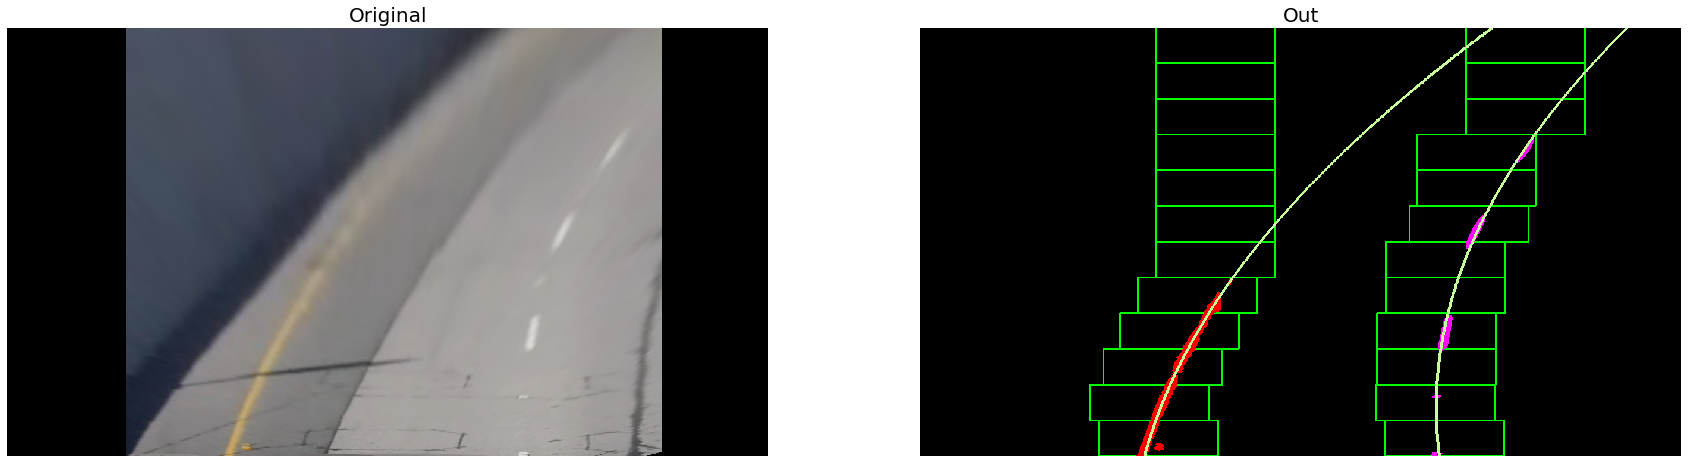

In [11]:
if 4 in plot_demo:

    cache = np.array([])

    for img_path in test_img_paths[:]: #video2[134:138]:
        img, _ = get_image(img_path)
        binary = get_binary_image(img, visualise=False)
        polyfit_sliding_window(binary, visualise=True)

## 5. Detect Lane Lines: Adaptive Search 

In [12]:
def polyfit_adapt_search(img, prev_poly_param, visualise=False, diagnostics=False):
    '''
    Function that: 
    1. Uses the sliding window technique to perform incremental localised adaptive threhsolding
    over the previosuly detected lane line trajectory to develop a threhsolded binary image. Then,
    2. Uses this generated binary image to detect and fit lane lines in a margin around the previous fit rather 
    than performing a blind search
    :param img (ndarray): Warped image
    :param prev_poly_param (ndarray): Polynomial coefficients of the previously detected lane lines
    :param visualise (boolean): Boolean flag for visualisation
    :param diagnostics (boolean): Boolean flag for logging
    : return (ndarray, ndarray): 3 channel image with the newly detected lane lines, current polynomial coefficients
    '''
    
    global cache # Cache of the previosuly detected lane line coefficients
    global attempts # Number of retries before the pipeline is RESET to detect lines via the smoothing window aproach
    
    # Sanity check
    assert(len(img.shape) == 3)
    
    # Setup
    nb_windows = 10 # Number of windows over which to perform the localised color thresholding  
    bin_margin = 80 # Width of the windows +/- margin for localised thresholding
    margin = 60 # Width around previous line positions +/- margin around which to search for the new lines
    window_height = int(img.shape[0] / nb_windows)
    smoothing_window = 5 # Number of frames over which to compute the Moving Average
    min_lane_pts = 10
    
    binary = np.zeros_like(img[:,:,0]) # Placeholder for the thresholded binary image
    img_plot = np.copy(img)
        
    left_fit, right_fit = prev_poly_param[0], prev_poly_param[1]
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)
    
    leftx_current = np.int(plot_xleft[-1])
    rightx_current = np.int(plot_xright[-1])
    
    # Iterate over the windows, perform localised color thresholding and generate the binary image
    for window in range(nb_windows):
        # Identify window boundaries in x and y (and left and right)
        win_y_low = IMG_SHAPE[0] - (window + 1) * window_height
        win_y_high = IMG_SHAPE[0] - window * window_height
        win_xleft_low = min(max(0, leftx_current - bin_margin), 1280)
        win_xleft_high = min(max(0, leftx_current + bin_margin), 1280)
        win_xright_low = min(max(0, rightx_current - bin_margin), 1280)
        win_xright_high = min(max(0, rightx_current + bin_margin), 1280)

        img_win_left = img[win_y_low:win_y_high, win_xleft_low:win_xleft_high,:]
        binary[win_y_low:win_y_high, win_xleft_low:win_xleft_high] = \
            get_binary_image(img_win_left, visualise=False)

        img_win_right = img[win_y_low:win_y_high, win_xright_low:win_xright_high, :]
        binary[win_y_low:win_y_high, win_xright_low:win_xright_high] = \
            get_binary_image(img_win_right, visualise=False)

        # Given that we only keep the points/values for a line that lie within the image
        # (see 'get_poly_points'), the overall length and consequently number of points (i.e. x-values
        # and y-values) can be < the length of the image. As a result, we check for the presence
        # of the current window's lower y-value i.e 'win_y_low' as a valid point within the previously detected line
        # If, a point associated with this y-value exists, we update the x-position of the next window with
        # the corresponding x-value.
        # Else, we keep the x-position of the subsequent windows the same and move up the image
        idxs = np.where(plot_yleft == win_y_low)[0]
        if len(idxs) != 0:
            leftx_current = int(plot_xleft[idxs[0]])
            
        idxs = np.where(plot_yright == win_y_low)[0]
        if len(idxs) != 0:
            rightx_current = int(plot_xright[idxs[0]])

        if visualise:
            left_pts = np.array([np.transpose(np.vstack([plot_xleft, plot_yleft]))])
            right_pts = np.array([np.transpose(np.vstack([plot_xright, plot_yright]))])
            
            # Plot the previously detected lane lines
            cv2.polylines(img_plot, np.int32([left_pts]), isClosed=False, color=(255, 20, 147), thickness=4)
            cv2.polylines(img_plot, np.int32([right_pts]), isClosed=False, color=(255, 20, 147), thickness=4)    
            
            bin_win_left = binary[win_y_low:win_y_high, win_xleft_low:win_xleft_high]
            bin_win_left = np.dstack((bin_win_left, np.zeros_like(bin_win_left), np.zeros_like(bin_win_left))) * 255

            bin_win_right = binary[win_y_low:win_y_high, win_xright_low:win_xright_high]
            bin_win_right = np.dstack([np.zeros_like(bin_win_right), np.zeros_like(bin_win_right), bin_win_right]) * 255
            
            # Blend the localised image window with its corresponding thresholded binary version
            win_left = cv2.addWeighted(bin_win_left, 0.5, img_win_left, 0.7, 0)
            win_right = cv2.addWeighted(bin_win_right, 0.5, img_win_right, 0.7, 0)
            
            # Draw the binary search window
            cv2.rectangle(img_plot, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 5)
            cv2.rectangle(img_plot, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 5)
            
            f, _ = plt.subplots(1, 2, figsize=(13,5))

            plt.subplot(121)
            plt.axis('off')
            plt.imshow(binary, cmap='gray')

            plt.subplot(122)
            plt.axis('off')
            plt.imshow(img_plot)

            plt.subplots_adjust(top=0.98, bottom=0.0, left=0.0, right=1.0, hspace=0.1, wspace=0.05)
            plt.savefig('./gif_images/window1{:02}.png'.format(window))
            
            # The blended Binary window and Image window is added later for better visualisation
            img_plot[win_y_low:win_y_high, win_xleft_low:win_xleft_high] = win_left
            img_plot[win_y_low:win_y_high, win_xright_low:win_xright_high] = win_right
        
    # Identify the x-y coordinates of all the non-zero pixels from the binary image
    # generated above
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Extract all the 
    left_lane_inds = \
        ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
        (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = \
        ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
         (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Sanity checks
    if len(leftx) > min_lane_pts:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        if diagnostics: print('WARNING: Less than {} pts detected for the left lane. {}'.format(min_lane_pts, len(leftx)))

    if len(rightx) > min_lane_pts:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        if diagnostics: print('WARNING: Less than {} pts detected for the right lane. {}'.format(min_lane_pts, len(rightx)))
        
    valid = check_validity(left_fit, right_fit, diagnostics=diagnostics)

    # Perform smoothing via moving average
    if valid:
        if len(cache) < smoothing_window:
            cache = np.concatenate((cache, [np.array([left_fit, right_fit])]), axis=0)
        elif len(cache) >= smoothing_window:
            cache[:-1] = cache[1:]
            cache[-1] = np.array([left_fit, right_fit])
  
        avg_params = np.mean(cache, axis=0)
        left_fit, right_fit = avg_params[0], avg_params[1]
        plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)
        curr_poly_param = np.array([left_fit, right_fit])
    else:
        attempts += 1
        curr_poly_param = prev_poly_param
    
    out = np.dstack([binary, binary, binary]) * 255
    win_img = np.zeros_like(out)

    # Color the lane line pixels
    out[lefty, leftx] = [255, 0, 0]
    out[righty, rightx] = [255, 10, 255]

    left_window1 = np.array([np.transpose(np.vstack([plot_xleft - margin, plot_yleft]))])
    left_window2 = np.array([np.flipud(np.transpose(np.vstack([plot_xleft + margin, plot_yleft])))])
    left_pts = np.hstack([left_window1, left_window2])

    right_window1 = np.array([np.transpose(np.vstack([plot_xright - margin, plot_yright]))])
    right_window2 = np.array([np.flipud(np.transpose(np.vstack([plot_xright + margin, plot_yright])))])
    right_pts = np.hstack([right_window1, right_window2])

    # Draw the search boundary
    cv2.fillPoly(win_img, np.int_([left_pts]), (0, 255, 0))
    cv2.fillPoly(win_img, np.int_([right_pts]), (0, 255, 0))

    out = cv2.addWeighted(out, 1, win_img, 0.25, 0)

    left_poly_pts = np.array([np.transpose(np.vstack([plot_xleft, plot_yleft]))])
    right_poly_pts = np.array([np.transpose(np.vstack([plot_xright, plot_yright]))])

    # Draw the fit lane lines
    cv2.polylines(out, np.int32([left_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)
    cv2.polylines(out, np.int32([right_poly_pts]), isClosed=False, color=(200,255,155), thickness=4)

    return out, curr_poly_param

### 5.1 Demo

In [14]:
if 5 in plot_demo:
    cache = np.array([])
    attempts = 0
    max_attempts = 4
    reset = True
    
    for frame_path in video2[0: 5]:
        img = mpimg.imread(frame_path)
        warped, (M, invM) = get_image(frame_path)
        
        if reset == True:
            binary = get_binary_image(warped)
            ret, out, poly_param = polyfit_sliding_window(binary, visualise=False, diagnostics=True)
            if ret:
                reset = False
                cache = np.array([poly_param])
                
        else:
            out, poly_param = polyfit_adapt_search(warped, poly_param, visualise=False, diagnostics=False)
            if attempts == max_attempts:
                attempts = 0
                reset = True
        
            out_unwarped = cv2.warpPerspective(out, invM, (IMG_SHAPE[1], IMG_SHAPE[0]), flags=cv2.INTER_LINEAR)

            img_overlay = np.copy(img)
            img_overlay = cv2.addWeighted(out_unwarped, 0.5, img, 0.5, 0)
            
            plot_images([(warped, 'Original'), (out, 'Out'), (img_overlay, 'Overlay')], figsize=(20, 18))

## 6. Compute meters/pixel

In [15]:
def compute_mppx(img, dashed_line_loc, visualise=False):
    '''
    Converts from pixel space to real world space and calculates the metres/pixel
    :param img (ndarray): Warped Image
    :param dashed_line_loc (string): Dashed line location (left/right)
    :param visualise (boolean): Boolean flag for visualisation
    : return (float32, float32): (metres/pixel y direction, metres/pixel x-direction)
    '''
    lane_width = 3.7
    dashed_line_len = 3.048
    
    if dashed_line_loc == 'left':
        y_top = 295
        y_bottom = 405
    elif dashed_line_loc == 'right':
        y_top = 395
        y_bottom = 495
        
    binary = get_binary_image(img)
    histogram = np.sum(binary[int(binary.shape[0] / 2):, :], axis=0)
    midpoint = np.int(histogram.shape[0] / 2)
    
    x_left = np.argmax(histogram[:midpoint])
    x_right = np.argmax(histogram[midpoint:]) + midpoint
    
    x_mppx = lane_width / (x_right - x_left)
    y_mppx = dashed_line_len / (y_bottom - y_top)
    
    if visualise:
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.axis('off')
        
        if dashed_line_loc == 'left':
            plt.plot((x_left, x_left), (y_top, y_bottom), 'r')
            plt.text(x_left + 10, (y_top + y_bottom) // 2, '{} m'.format(dashed_line_len), color='r', fontsize=20)

        elif dashed_line_loc == 'right':
            plt.plot((x_right, x_right), (y_top, y_bottom), 'r')
            plt.text(x_right + 10, (y_top + y_bottom) // 2, '{} m'.format(dashed_line_len), color='r',fontsize=20)

        plt.plot((x_left, x_right), (img.shape[0] - 200 , img.shape[0] - 200), 'r')
        plt.text((x_left + x_right) // 2, img.shape[0] - 220, '{} m'.format(lane_width), color='r', fontsize=20)
        
    return y_mppx, x_mppx

### 6.1 Demo

Average meter/px along x-axis: 0.0065
Average meter/px along y-axis: 0.0291


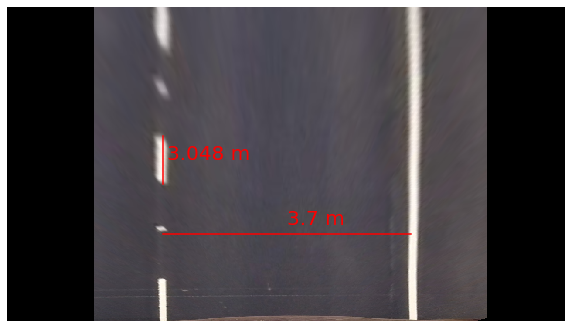

In [16]:
if 6 in plot_demo:
    visualise = True
else:
    visualise = False

img, _ = get_image(test_img_paths[0])
y_mppx1, x_mppx1 = compute_mppx(img, dashed_line_loc='right', visualise=visualise)

img, _ = get_image(test_img_paths[1])
y_mppx2, x_mppx2 = compute_mppx(img, dashed_line_loc='left', visualise=visualise)

x_mppx = (x_mppx1 + x_mppx2) / 2
y_mppx = (y_mppx1 + y_mppx2) / 2

print('Average meter/px along x-axis: {:.4f}'.format(x_mppx))
print('Average meter/px along y-axis: {:.4f}'.format(y_mppx))

## 7. Compute Lane Line Curvature

In [17]:
def compute_offset_from_center(poly_param, x_mppx):
    '''
    Computes the offset of the car from the center of the detected lane lines
    :param poly_param (ndarray): Set of 2nd order polynomial coefficients that represent the detected lane lines
    :param x_mppx (float32): metres/pixel in the x-direction
    :return (float32): Offset 
    '''
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(poly_param[0], poly_param[1])
    
    lane_center = (plot_xright[-1] + plot_xleft[-1]) / 2
    car_center = IMG_SHAPE[1] / 2
    
    offset = (lane_center - car_center) * x_mppx
    return offset

def compute_curvature(poly_param, y_mppx, x_mppx):
    '''
    Computes the curvature of the lane lines (in metres)
    :param poly_param (ndarray): Set of 2nd order polynomial coefficients that represent the detected lane lines
    :param y_mppx (float32): metres/pixel in the y-direction
    :param x_mppx (float32): metres/pixel in the x-direction
    :return (float32): Curvature (in metres) 
    '''
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(poly_param[0], poly_param[1])
    
    y_eval = np.max(plot_yleft)

    left_fit_cr = np.polyfit(plot_yleft * y_mppx, plot_xleft * x_mppx, 2)
    right_fit_cr = np.polyfit(plot_yright * y_mppx, plot_xright * x_mppx, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]* y_eval*y_mppx + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*y_mppx + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

def draw(img, warped, invM, poly_param, curve_rad, offset):
    '''
    Utility function to draw the lane boundaries and numerical estimation of lane curvature and vehicle position.
    :param img (ndarray): Original image
    :param warped (ndarray): Warped image
    :param invM (ndarray): Inverse Perpsective Transformation matrix
    :param poly_param (ndarray): Set of 2nd order polynomial coefficients that represent the detected lane lines
    :param curve_rad (float32): Lane line curvature
    :param offset (float32): Car offset
    :return (ndarray): Image with visual display
    '''
    
    undist = undistort(img, mtx, dist)
    warp_zero = np.zeros_like(warped[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fit = poly_param[0]
    right_fit = poly_param[1]
    plot_xleft, plot_yleft, plot_xright, plot_yright = get_poly_points(left_fit, right_fit)
    
    pts_left = np.array([np.transpose(np.vstack([plot_xleft, plot_yleft]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([plot_xright, plot_yright])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Color the road
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 220, 110))
                    
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False,
                  color=(255, 255, 255), thickness=10)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False,
                  color=(255, 255, 255), thickness= 10)
    
    # Unwarp and merge with undistorted original image
    unwarped = cv2.warpPerspective(color_warp, invM, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    out = cv2.addWeighted(undist, 1, unwarped, 0.4, 0)
    
    # Write data on the image
    if (left_fit[1] + right_fit[1]) / 2 > 0.05:
        text = 'Left turn, curve radius: {:04.2f} m'.format(curve_rad)
    elif (left_fit[1] + right_fit[1]) / 2 < -0.05:
        text = 'Right turn, curve radius: {:04.2f} m'.format(curve_rad)
    else:
        text = 'Straight'
    
    cv2.putText(out, text, (50, 60), cv2.FONT_HERSHEY_DUPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
    
    direction = ''
    if offset > 0:
        direction = 'left'
    elif offset < 0:
        direction = 'right'
    
    text = '{:0.1f} cm {} of center'.format(abs(offset) * 100, direction)
    cv2.putText(out, text, (50, 110), cv2.FONT_HERSHEY_DUPLEX, 1.2, (255, 255, 255), 2, cv2.LINE_AA)
    
    return out

### 7.1 Demo

In [20]:
### DEMO
if 7 in plot_demo:
    cache = np.array([])
    
    for img_path in video1[1000: 1010]:#test_img_paths:
        img = mpimg.imread(img_path)
        warped, (M, invM) = get_image(img_path)
        
        binary = get_binary_image(warped)
        ret, img_poly, poly_param = polyfit_sliding_window(binary)
        
        left_curverad, right_curverad = compute_curvature(poly_param, y_mppx, x_mppx)
        curvature = (left_curverad + right_curverad) / 2
        offset = compute_offset_from_center(poly_param, x_mppx)
        result = draw(img, warped, invM, poly_param, curvature, offset)
        
        plot_images([(img_poly, 'Polyfit'), (result, 'Result')])

## 8. Pipeline

In [21]:
def triple_split_view(images):
    '''
    Utility function to create triple split view for display in video
    :param images ([ndarray]): List of images
    :returm (ndarray): Single RGB image 
    '''

    scale_factor = 2
    
    # Sizes/shapes are in (x,y) format for convenience use with cv2
    img_shape = IMG_SHAPE[::-1]
    scaled_size = (round(img_shape[0] / scale_factor), round(img_shape[1] / scale_factor))
    x_max, y_max = img_shape[0], img_shape[1] + scaled_size[1] # x, y + y'

    # Top-left corner positions for each of the three windows
    positions = [(0,0), (0, img_shape[1]), (round(0.5 * img_shape[0]), img_shape[1])]
    sizes = [img_shape, scaled_size, scaled_size] 
    
    out = np.zeros((y_max, x_max, 3), dtype=np.uint8)

    for idx, img in enumerate(images):
        # Resize the image
        if img.shape[0] != sizes[idx][1] | img.shape[1] != sizes[idx][0]:
            img = cv2.resize(img, dsize=sizes[idx])

        # Place the resized image onto the final output image
        x, y = positions[idx]
        w, h = sizes[idx]
        out[y:min(y + h, y_max), x:min(x + w, x_max), :] = img[:min(h, y_max - y), :min(w, x_max - x)]

    return out

def pipeline(img, visualise=False, diagnostics=False):
    global cache
    global poly_param # Important for successive calls to the pipeline
    global attempts
    global reset
    max_attempts = 5
    
    result = np.copy(img)
    warped, (M, invM) = preprocess_image(img)
    title = ''
   
    try:
        if reset == True:
            title = 'Sliding window'
            if diagnostics: print(title)
            
            binary = get_binary_image(warped)
            ret, img_poly, poly_param = polyfit_sliding_window(binary, diagnostics=diagnostics)
            if ret:
                if diagnostics: print('Success!')
                reset = False
                cache = np.array([poly_param])
            else:
                if len(img_poly) == 0:
                    print('Sliding window failed!')
                    return img
                
        else:
            title = 'Adaptive Search'
            if diagnostics: print(title)
            
            img_poly, poly_param = polyfit_adapt_search(warped, poly_param, diagnostics=diagnostics)
            if attempts == max_attempts:
                if diagnostics: print('Resetting...')
                reset = True
                attempts = 0
        
        left_curverad, right_curverad = compute_curvature(poly_param, y_mppx, x_mppx)
        offset = compute_offset_from_center(poly_param, x_mppx)
        result = draw(img, warped, invM, poly_param, (left_curverad + right_curverad) / 2, offset)

        blended_warped_poly = cv2.addWeighted(img_poly, 0.6, warped, 1, 0)
        ret2 = np.hstack([img_poly, blended_warped_poly])
        ret3 = np.hstack([result, warped])
#         ret3 = triple_split_view([result, img_poly, blended_warped_poly])
        ret3 = np.vstack([ret3, ret2])
        if visualise:
            plt.figure(figsize=(20, 12))
            plt.title(title)
            plt.imshow(ret3)

        return ret3
    
    except Exception as e:
        print(e)
        return img

### 8.1 Demo

In [22]:
if 8 in plot_demo:
    print('Demo of consecutive frames')
    
    cache = np.array([])
    attempts = 0
    reset = True
    
    for img_path in video2[0:15]:
        img = mpimg.imread(img_path)
        result = pipeline(img, visualise=True, diagnostics=1)

Demo of consecutive frames


## 9. Process Video

In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

process_frame = lambda frame: pipeline(frame, diagnostics=1)

# Pipeline initialisation
cache = np.array([])
attempts = 0
reset = True

video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')#.subclip(18,27)                          
processed_video = video_input.fl_image(process_frame)
%time processed_video.write_videofile(video_output, audio=False)

# video1_output = 'challenge_video_output.mp4'
# video1_input = VideoFileClip('challenge_video.mp4')#.subclip(4, 7)                          
# processed_video = video1_input.fl_image(process_frame)
# %time processed_video.write_videofile(video1_output, audio=False)

# video2_output = 'harder_challenge_video_output.mp4'
# video2_input = VideoFileClip('harder_challenge_video.mp4')                          
# processed_video = video2_input.fl_image(process_frame)#.subclip(0,5)
# %time processed_video.write_videofile(video2_output, audio=False)

Sliding window
Success!
Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Adaptive Search


t:   0%|                                                                    | 2/1260 [00:00<04:26,  4.72it/s, now=None]

Adaptive Search


t:   0%|▏                                                                   | 3/1260 [00:00<05:53,  3.56it/s, now=None]

Adaptive Search


t:   0%|▏                                                                   | 4/1260 [00:01<07:32,  2.77it/s, now=None]

Adaptive Search


t:   0%|▎                                                                   | 5/1260 [00:01<08:51,  2.36it/s, now=None]

Adaptive Search


t:   0%|▎                                                                   | 6/1260 [00:02<09:49,  2.13it/s, now=None]

Adaptive Search


t:   1%|▍                                                                   | 7/1260 [00:03<09:46,  2.14it/s, now=None]

Adaptive Search


t:   1%|▍                                                                   | 8/1260 [00:03<09:48,  2.13it/s, now=None]

Adaptive Search


t:   1%|▍                                                                   | 9/1260 [00:04<10:07,  2.06it/s, now=None]

Adaptive Search


t:   1%|▌                                                                  | 10/1260 [00:04<10:21,  2.01it/s, now=None]

Adaptive Search


t:   1%|▌                                                                  | 11/1260 [00:05<10:51,  1.92it/s, now=None]

Adaptive Search


t:   1%|▋                                                                  | 12/1260 [00:05<10:36,  1.96it/s, now=None]

Adaptive Search


t:   1%|▋                                                                  | 13/1260 [00:06<10:18,  2.02it/s, now=None]

Adaptive Search


t:   1%|▋                                                                  | 14/1260 [00:06<10:20,  2.01it/s, now=None]

Adaptive Search


t:   1%|▊                                                                  | 15/1260 [00:07<10:26,  1.99it/s, now=None]

Adaptive Search


t:   1%|▊                                                                  | 16/1260 [00:07<11:05,  1.87it/s, now=None]

Adaptive Search


t:   1%|▉                                                                  | 17/1260 [00:08<11:16,  1.84it/s, now=None]

Adaptive Search


t:   1%|▉                                                                  | 18/1260 [00:08<12:24,  1.67it/s, now=None]

Adaptive Search


t:   2%|█                                                                  | 19/1260 [00:09<11:58,  1.73it/s, now=None]

Adaptive Search


t:   2%|█                                                                  | 20/1260 [00:10<11:38,  1.78it/s, now=None]

Adaptive Search


t:   2%|█                                                                  | 21/1260 [00:10<11:19,  1.82it/s, now=None]

Adaptive Search


t:   2%|█▏                                                                 | 22/1260 [00:11<11:24,  1.81it/s, now=None]

Adaptive Search


t:   2%|█▏                                                                 | 23/1260 [00:11<11:26,  1.80it/s, now=None]

Adaptive Search


t:   2%|█▎                                                                 | 24/1260 [00:12<11:04,  1.86it/s, now=None]

Adaptive Search


t:   2%|█▎                                                                 | 25/1260 [00:12<11:15,  1.83it/s, now=None]

Adaptive Search


t:   2%|█▍                                                                 | 26/1260 [00:13<11:18,  1.82it/s, now=None]

Adaptive Search


t:   2%|█▍                                                                 | 27/1260 [00:13<11:25,  1.80it/s, now=None]

Adaptive Search


t:   2%|█▍                                                                 | 28/1260 [00:14<10:50,  1.89it/s, now=None]

Adaptive Search


t:   2%|█▌                                                                 | 29/1260 [00:14<10:29,  1.95it/s, now=None]

Adaptive Search


t:   2%|█▌                                                                 | 30/1260 [00:15<10:19,  1.99it/s, now=None]

Adaptive Search


t:   2%|█▋                                                                 | 31/1260 [00:15<09:42,  2.11it/s, now=None]

Adaptive Search


t:   3%|█▋                                                                 | 32/1260 [00:16<09:21,  2.19it/s, now=None]

Adaptive Search


t:   3%|█▊                                                                 | 33/1260 [00:16<10:23,  1.97it/s, now=None]

Adaptive Search


t:   3%|█▊                                                                 | 34/1260 [00:17<10:10,  2.01it/s, now=None]

Adaptive Search


t:   3%|█▊                                                                 | 35/1260 [00:17<10:43,  1.90it/s, now=None]

Adaptive Search


t:   3%|█▉                                                                 | 36/1260 [00:18<10:24,  1.96it/s, now=None]

Adaptive Search


t:   3%|█▉                                                                 | 37/1260 [00:18<10:41,  1.91it/s, now=None]

Adaptive Search


t:   3%|██                                                                 | 38/1260 [00:19<10:50,  1.88it/s, now=None]

Adaptive Search


t:   3%|██                                                                 | 39/1260 [00:19<10:42,  1.90it/s, now=None]

Adaptive Search


t:   3%|██▏                                                                | 40/1260 [00:20<10:36,  1.92it/s, now=None]

Adaptive Search


t:   3%|██▏                                                                | 41/1260 [00:20<10:07,  2.01it/s, now=None]

Adaptive Search


t:   3%|██▏                                                                | 42/1260 [00:21<10:06,  2.01it/s, now=None]

Adaptive Search


t:   3%|██▎                                                                | 43/1260 [00:21<09:45,  2.08it/s, now=None]

Adaptive Search


t:   3%|██▎                                                                | 44/1260 [00:22<09:41,  2.09it/s, now=None]

Adaptive Search


t:   4%|██▍                                                                | 45/1260 [00:22<10:12,  1.98it/s, now=None]

Adaptive Search


t:   4%|██▍                                                                | 46/1260 [00:23<10:03,  2.01it/s, now=None]

Adaptive Search


t:   4%|██▍                                                                | 47/1260 [00:23<10:51,  1.86it/s, now=None]

Adaptive Search


t:   4%|██▌                                                                | 48/1260 [00:24<13:15,  1.52it/s, now=None]

Adaptive Search


t:   4%|██▌                                                                | 49/1260 [00:25<13:22,  1.51it/s, now=None]

Adaptive Search


t:   4%|██▋                                                                | 50/1260 [00:26<12:19,  1.64it/s, now=None]

Adaptive Search


t:   4%|██▋                                                                | 51/1260 [00:26<12:29,  1.61it/s, now=None]

Adaptive Search


t:   4%|██▊                                                                | 52/1260 [00:27<11:57,  1.68it/s, now=None]

Adaptive Search


t:   4%|██▊                                                                | 53/1260 [00:27<12:47,  1.57it/s, now=None]

Adaptive Search


t:   4%|██▊                                                                | 54/1260 [00:28<12:26,  1.62it/s, now=None]

Adaptive Search


t:   4%|██▉                                                                | 55/1260 [00:29<11:51,  1.69it/s, now=None]

Adaptive Search


t:   4%|██▉                                                                | 56/1260 [00:29<11:27,  1.75it/s, now=None]

Adaptive Search


t:   5%|███                                                                | 57/1260 [00:30<13:08,  1.53it/s, now=None]

Adaptive Search


t:   5%|███                                                                | 58/1260 [00:31<14:53,  1.35it/s, now=None]

Adaptive Search


t:   5%|███▏                                                               | 59/1260 [00:31<13:31,  1.48it/s, now=None]

Adaptive Search


t:   5%|███▏                                                               | 60/1260 [00:32<12:47,  1.56it/s, now=None]

Adaptive Search


t:   5%|███▏                                                               | 61/1260 [00:33<12:48,  1.56it/s, now=None]

Adaptive Search


t:   5%|███▎                                                               | 62/1260 [00:33<11:54,  1.68it/s, now=None]

Adaptive Search


t:   5%|███▎                                                               | 63/1260 [00:34<11:16,  1.77it/s, now=None]

Adaptive Search


t:   5%|███▍                                                               | 64/1260 [00:34<11:30,  1.73it/s, now=None]

Adaptive Search


t:   5%|███▍                                                               | 65/1260 [00:35<10:49,  1.84it/s, now=None]

Adaptive Search


t:   5%|███▌                                                               | 66/1260 [00:35<11:20,  1.76it/s, now=None]

Adaptive Search


t:   5%|███▌                                                               | 67/1260 [00:36<11:00,  1.81it/s, now=None]

Adaptive Search


t:   5%|███▌                                                               | 68/1260 [00:36<10:34,  1.88it/s, now=None]

Adaptive Search


t:   5%|███▋                                                               | 69/1260 [00:37<10:01,  1.98it/s, now=None]

Adaptive Search


t:   6%|███▋                                                               | 70/1260 [00:37<09:40,  2.05it/s, now=None]

Adaptive Search


t:   6%|███▊                                                               | 71/1260 [00:38<09:49,  2.02it/s, now=None]

Adaptive Search


t:   6%|███▊                                                               | 72/1260 [00:38<09:37,  2.06it/s, now=None]

Adaptive Search


t:   6%|███▉                                                               | 73/1260 [00:39<10:02,  1.97it/s, now=None]

Adaptive Search


t:   6%|███▉                                                               | 74/1260 [00:39<09:41,  2.04it/s, now=None]

Adaptive Search


t:   6%|███▉                                                               | 75/1260 [00:40<09:32,  2.07it/s, now=None]

Adaptive Search


t:   6%|████                                                               | 76/1260 [00:40<10:17,  1.92it/s, now=None]

Adaptive Search


t:   6%|████                                                               | 77/1260 [00:41<10:42,  1.84it/s, now=None]

Adaptive Search


t:   6%|████▏                                                              | 78/1260 [00:41<10:16,  1.92it/s, now=None]

Adaptive Search


t:   6%|████▏                                                              | 79/1260 [00:42<09:55,  1.98it/s, now=None]

Adaptive Search


t:   6%|████▎                                                              | 80/1260 [00:42<09:46,  2.01it/s, now=None]

Adaptive Search


t:   6%|████▎                                                              | 81/1260 [00:43<10:04,  1.95it/s, now=None]

Adaptive Search


t:   7%|████▎                                                              | 82/1260 [00:43<09:41,  2.03it/s, now=None]

Adaptive Search


t:   7%|████▍                                                              | 83/1260 [00:44<09:45,  2.01it/s, now=None]

Adaptive Search


t:   7%|████▍                                                              | 84/1260 [00:44<09:25,  2.08it/s, now=None]

Adaptive Search


t:   7%|████▌                                                              | 85/1260 [00:45<09:14,  2.12it/s, now=None]

Adaptive Search


t:   7%|████▌                                                              | 86/1260 [00:45<09:25,  2.08it/s, now=None]

Adaptive Search


t:   7%|████▋                                                              | 87/1260 [00:46<09:10,  2.13it/s, now=None]

Adaptive Search


t:   7%|████▋                                                              | 88/1260 [00:46<09:18,  2.10it/s, now=None]

Adaptive Search


t:   7%|████▋                                                              | 89/1260 [00:47<09:14,  2.11it/s, now=None]

Adaptive Search


t:   7%|████▊                                                              | 90/1260 [00:47<09:07,  2.14it/s, now=None]

Adaptive Search


t:   7%|████▊                                                              | 91/1260 [00:47<09:09,  2.13it/s, now=None]

Adaptive Search


t:   7%|████▉                                                              | 92/1260 [00:48<08:54,  2.19it/s, now=None]

Adaptive Search


t:   7%|████▉                                                              | 93/1260 [00:48<09:00,  2.16it/s, now=None]

Adaptive Search


t:   7%|████▉                                                              | 94/1260 [00:49<09:09,  2.12it/s, now=None]

Adaptive Search


t:   8%|█████                                                              | 95/1260 [00:49<08:58,  2.17it/s, now=None]

Adaptive Search


t:   8%|█████                                                              | 96/1260 [00:50<08:52,  2.19it/s, now=None]

Adaptive Search


t:   8%|█████▏                                                             | 97/1260 [00:50<08:50,  2.19it/s, now=None]

Adaptive Search


t:   8%|█████▏                                                             | 98/1260 [00:51<08:53,  2.18it/s, now=None]

Adaptive Search


t:   8%|█████▎                                                             | 99/1260 [00:51<09:14,  2.09it/s, now=None]

Adaptive Search


t:   8%|█████▏                                                            | 100/1260 [00:52<09:04,  2.13it/s, now=None]

Adaptive Search


t:   8%|█████▎                                                            | 101/1260 [00:52<09:10,  2.11it/s, now=None]

Adaptive Search


t:   8%|█████▎                                                            | 102/1260 [00:53<09:14,  2.09it/s, now=None]

Adaptive Search


t:   8%|█████▍                                                            | 103/1260 [00:53<09:16,  2.08it/s, now=None]

Adaptive Search


t:   8%|█████▍                                                            | 104/1260 [00:54<09:11,  2.10it/s, now=None]

Adaptive Search


t:   8%|█████▌                                                            | 105/1260 [00:54<09:18,  2.07it/s, now=None]

Adaptive Search


t:   8%|█████▌                                                            | 106/1260 [00:55<10:46,  1.78it/s, now=None]

Adaptive Search


t:   8%|█████▌                                                            | 107/1260 [00:55<10:26,  1.84it/s, now=None]

Adaptive Search


t:   9%|█████▋                                                            | 108/1260 [00:56<10:53,  1.76it/s, now=None]

Adaptive Search


t:   9%|█████▋                                                            | 109/1260 [00:57<12:50,  1.49it/s, now=None]

Adaptive Search


t:   9%|█████▊                                                            | 110/1260 [00:58<18:13,  1.05it/s, now=None]

Adaptive Search


t:   9%|█████▊                                                            | 111/1260 [00:59<15:55,  1.20it/s, now=None]

Adaptive Search


t:   9%|█████▊                                                            | 112/1260 [01:01<19:37,  1.03s/it, now=None]

Adaptive Search


t:   9%|█████▉                                                            | 113/1260 [01:02<24:38,  1.29s/it, now=None]

Adaptive Search


t:   9%|█████▉                                                            | 114/1260 [01:03<20:14,  1.06s/it, now=None]

Adaptive Search


t:   9%|██████                                                            | 115/1260 [01:03<17:21,  1.10it/s, now=None]

Adaptive Search


t:   9%|██████                                                            | 116/1260 [01:04<14:58,  1.27it/s, now=None]

Adaptive Search


t:   9%|██████▏                                                           | 117/1260 [01:05<13:41,  1.39it/s, now=None]

Adaptive Search


t:   9%|██████▏                                                           | 118/1260 [01:05<13:14,  1.44it/s, now=None]

Adaptive Search


t:   9%|██████▏                                                           | 119/1260 [01:06<12:08,  1.57it/s, now=None]

Adaptive Search


t:  10%|██████▎                                                           | 120/1260 [01:06<11:45,  1.62it/s, now=None]

Adaptive Search


t:  10%|██████▎                                                           | 121/1260 [01:07<11:07,  1.71it/s, now=None]

Adaptive Search


t:  10%|██████▍                                                           | 122/1260 [01:07<10:59,  1.73it/s, now=None]

Adaptive Search


t:  10%|██████▍                                                           | 123/1260 [01:08<10:30,  1.80it/s, now=None]

Adaptive Search


t:  10%|██████▍                                                           | 124/1260 [01:08<10:19,  1.83it/s, now=None]

Adaptive Search


t:  10%|██████▌                                                           | 125/1260 [01:09<10:28,  1.80it/s, now=None]

Adaptive Search


t:  10%|██████▌                                                           | 126/1260 [01:09<10:19,  1.83it/s, now=None]

Adaptive Search


t:  10%|██████▋                                                           | 127/1260 [01:10<10:28,  1.80it/s, now=None]

Adaptive Search


t:  10%|██████▋                                                           | 128/1260 [01:11<10:08,  1.86it/s, now=None]

Adaptive Search


t:  10%|██████▊                                                           | 129/1260 [01:11<10:17,  1.83it/s, now=None]

Adaptive Search


t:  10%|██████▊                                                           | 130/1260 [01:12<10:01,  1.88it/s, now=None]

Adaptive Search


t:  10%|██████▊                                                           | 131/1260 [01:12<09:49,  1.92it/s, now=None]

Adaptive Search


t:  10%|██████▉                                                           | 132/1260 [01:13<10:38,  1.77it/s, now=None]

Adaptive Search


t:  11%|██████▉                                                           | 133/1260 [01:13<10:14,  1.83it/s, now=None]

Adaptive Search


t:  11%|███████                                                           | 134/1260 [01:14<10:11,  1.84it/s, now=None]

Adaptive Search


t:  11%|███████                                                           | 135/1260 [01:14<09:55,  1.89it/s, now=None]

Adaptive Search


t:  11%|███████                                                           | 136/1260 [01:15<09:36,  1.95it/s, now=None]

Adaptive Search


t:  11%|███████▏                                                          | 137/1260 [01:15<10:17,  1.82it/s, now=None]

Adaptive Search


t:  11%|███████▏                                                          | 138/1260 [01:16<10:17,  1.82it/s, now=None]

Adaptive Search


t:  11%|███████▎                                                          | 139/1260 [01:17<10:36,  1.76it/s, now=None]

Adaptive Search


t:  11%|███████▎                                                          | 140/1260 [01:17<10:10,  1.84it/s, now=None]

Adaptive Search


t:  11%|███████▍                                                          | 141/1260 [01:18<11:11,  1.67it/s, now=None]

Adaptive Search


t:  11%|███████▍                                                          | 142/1260 [01:19<11:51,  1.57it/s, now=None]

Adaptive Search


t:  11%|███████▍                                                          | 143/1260 [01:19<10:57,  1.70it/s, now=None]

Adaptive Search


t:  11%|███████▌                                                          | 144/1260 [01:19<10:11,  1.83it/s, now=None]

Adaptive Search


t:  12%|███████▌                                                          | 145/1260 [01:20<09:34,  1.94it/s, now=None]

Adaptive Search


t:  12%|███████▋                                                          | 146/1260 [01:20<09:26,  1.97it/s, now=None]

Adaptive Search


t:  12%|███████▋                                                          | 147/1260 [01:21<09:10,  2.02it/s, now=None]

Adaptive Search


t:  12%|███████▊                                                          | 148/1260 [01:21<08:43,  2.12it/s, now=None]

Adaptive Search


t:  12%|███████▊                                                          | 149/1260 [01:22<09:52,  1.87it/s, now=None]

Adaptive Search


t:  12%|███████▊                                                          | 150/1260 [01:22<09:37,  1.92it/s, now=None]

Adaptive Search


t:  12%|███████▉                                                          | 151/1260 [01:23<10:08,  1.82it/s, now=None]

Adaptive Search


t:  12%|███████▉                                                          | 152/1260 [01:24<10:02,  1.84it/s, now=None]

Adaptive Search


t:  12%|████████                                                          | 153/1260 [01:24<10:33,  1.75it/s, now=None]

Adaptive Search


t:  12%|████████                                                          | 154/1260 [01:25<10:13,  1.80it/s, now=None]

Adaptive Search


t:  12%|████████                                                          | 155/1260 [01:25<10:00,  1.84it/s, now=None]

Adaptive Search


t:  12%|████████▏                                                         | 156/1260 [01:26<10:16,  1.79it/s, now=None]

Adaptive Search


t:  12%|████████▏                                                         | 157/1260 [01:26<09:55,  1.85it/s, now=None]

Adaptive Search


t:  13%|████████▎                                                         | 158/1260 [01:27<09:54,  1.85it/s, now=None]

Adaptive Search


t:  13%|████████▎                                                         | 159/1260 [01:27<09:35,  1.91it/s, now=None]

Adaptive Search


t:  13%|████████▍                                                         | 160/1260 [01:28<09:16,  1.98it/s, now=None]

Adaptive Search


t:  13%|████████▍                                                         | 161/1260 [01:28<09:43,  1.88it/s, now=None]

Adaptive Search


t:  13%|████████▍                                                         | 162/1260 [01:29<09:21,  1.95it/s, now=None]

Adaptive Search


t:  13%|████████▌                                                         | 163/1260 [01:29<09:24,  1.94it/s, now=None]

Adaptive Search


t:  13%|████████▌                                                         | 164/1260 [01:30<09:19,  1.96it/s, now=None]

Adaptive Search


t:  13%|████████▋                                                         | 165/1260 [01:30<09:11,  1.99it/s, now=None]

Adaptive Search


t:  13%|████████▋                                                         | 166/1260 [01:31<09:29,  1.92it/s, now=None]

Adaptive Search


t:  13%|████████▋                                                         | 167/1260 [01:31<09:17,  1.96it/s, now=None]

Adaptive Search


t:  13%|████████▊                                                         | 168/1260 [01:32<09:29,  1.92it/s, now=None]

Adaptive Search


t:  13%|████████▊                                                         | 169/1260 [01:32<09:19,  1.95it/s, now=None]

Adaptive Search


t:  13%|████████▉                                                         | 170/1260 [01:33<09:08,  1.99it/s, now=None]

Adaptive Search


t:  14%|████████▉                                                         | 171/1260 [01:34<09:38,  1.88it/s, now=None]

Adaptive Search


t:  14%|█████████                                                         | 172/1260 [01:34<09:50,  1.84it/s, now=None]

Adaptive Search


t:  14%|█████████                                                         | 173/1260 [01:35<10:05,  1.80it/s, now=None]

Adaptive Search


t:  14%|█████████                                                         | 174/1260 [01:35<09:45,  1.85it/s, now=None]

Adaptive Search


t:  14%|█████████▏                                                        | 175/1260 [01:36<09:58,  1.81it/s, now=None]

Adaptive Search


t:  14%|█████████▏                                                        | 176/1260 [01:36<09:57,  1.81it/s, now=None]

Adaptive Search


t:  14%|█████████▎                                                        | 177/1260 [01:37<09:57,  1.81it/s, now=None]

Adaptive Search


t:  14%|█████████▎                                                        | 178/1260 [01:37<09:44,  1.85it/s, now=None]

Adaptive Search


t:  14%|█████████▍                                                        | 179/1260 [01:38<09:14,  1.95it/s, now=None]

Adaptive Search


t:  14%|█████████▍                                                        | 180/1260 [01:38<09:06,  1.98it/s, now=None]

Adaptive Search


t:  14%|█████████▍                                                        | 181/1260 [01:39<08:47,  2.05it/s, now=None]

Adaptive Search


t:  14%|█████████▌                                                        | 182/1260 [01:39<08:53,  2.02it/s, now=None]

Adaptive Search


t:  15%|█████████▌                                                        | 183/1260 [01:40<09:57,  1.80it/s, now=None]

Adaptive Search


t:  15%|█████████▋                                                        | 184/1260 [01:40<09:30,  1.88it/s, now=None]

Adaptive Search


t:  15%|█████████▋                                                        | 185/1260 [01:41<09:32,  1.88it/s, now=None]

Adaptive Search


t:  15%|█████████▋                                                        | 186/1260 [01:41<09:02,  1.98it/s, now=None]

Adaptive Search


t:  15%|█████████▊                                                        | 187/1260 [01:42<08:52,  2.02it/s, now=None]

Adaptive Search


t:  15%|█████████▊                                                        | 188/1260 [01:42<09:05,  1.96it/s, now=None]

Adaptive Search


t:  15%|█████████▉                                                        | 189/1260 [01:43<09:44,  1.83it/s, now=None]

Adaptive Search


t:  15%|█████████▉                                                        | 190/1260 [01:44<09:44,  1.83it/s, now=None]

Adaptive Search


t:  15%|██████████                                                        | 191/1260 [01:44<09:36,  1.85it/s, now=None]

Adaptive Search


t:  15%|██████████                                                        | 192/1260 [01:45<09:40,  1.84it/s, now=None]

Adaptive Search


t:  15%|██████████                                                        | 193/1260 [01:45<09:28,  1.88it/s, now=None]

Adaptive Search


t:  15%|██████████▏                                                       | 194/1260 [01:46<09:38,  1.84it/s, now=None]

Adaptive Search


t:  15%|██████████▏                                                       | 195/1260 [01:46<09:20,  1.90it/s, now=None]

Adaptive Search


t:  16%|██████████▎                                                       | 196/1260 [01:47<09:01,  1.96it/s, now=None]

Adaptive Search


t:  16%|██████████▎                                                       | 197/1260 [01:48<10:34,  1.67it/s, now=None]

Adaptive Search


t:  16%|██████████▎                                                       | 198/1260 [01:48<09:51,  1.80it/s, now=None]

Adaptive Search


t:  16%|██████████▍                                                       | 199/1260 [01:49<10:17,  1.72it/s, now=None]

Adaptive Search


t:  16%|██████████▍                                                       | 200/1260 [01:49<09:34,  1.85it/s, now=None]

Adaptive Search


t:  16%|██████████▌                                                       | 201/1260 [01:50<09:17,  1.90it/s, now=None]

Adaptive Search


t:  16%|██████████▌                                                       | 202/1260 [01:50<09:12,  1.91it/s, now=None]

Adaptive Search


t:  16%|██████████▋                                                       | 203/1260 [01:51<08:52,  1.99it/s, now=None]

Adaptive Search


t:  16%|██████████▋                                                       | 204/1260 [01:51<08:50,  1.99it/s, now=None]

Adaptive Search


t:  16%|██████████▋                                                       | 205/1260 [01:52<08:36,  2.04it/s, now=None]

Adaptive Search


t:  16%|██████████▊                                                       | 206/1260 [01:52<08:20,  2.11it/s, now=None]

Adaptive Search


t:  16%|██████████▊                                                       | 207/1260 [01:52<08:23,  2.09it/s, now=None]

Adaptive Search


t:  17%|██████████▉                                                       | 208/1260 [01:53<08:08,  2.15it/s, now=None]

Adaptive Search


t:  17%|██████████▉                                                       | 209/1260 [01:53<08:08,  2.15it/s, now=None]

Adaptive Search


t:  17%|███████████                                                       | 210/1260 [01:54<08:25,  2.08it/s, now=None]

Adaptive Search


t:  17%|███████████                                                       | 211/1260 [01:54<08:16,  2.11it/s, now=None]

Adaptive Search


t:  17%|███████████                                                       | 212/1260 [01:55<09:01,  1.94it/s, now=None]

Adaptive Search


t:  17%|███████████▏                                                      | 213/1260 [01:55<09:07,  1.91it/s, now=None]

Adaptive Search


t:  17%|███████████▏                                                      | 214/1260 [01:56<09:06,  1.91it/s, now=None]

Adaptive Search


t:  17%|███████████▎                                                      | 215/1260 [01:56<08:53,  1.96it/s, now=None]

Adaptive Search


t:  17%|███████████▎                                                      | 216/1260 [01:57<08:35,  2.02it/s, now=None]

Adaptive Search


t:  17%|███████████▎                                                      | 217/1260 [01:58<08:59,  1.93it/s, now=None]

Adaptive Search


t:  17%|███████████▍                                                      | 218/1260 [01:58<09:43,  1.79it/s, now=None]

Adaptive Search


t:  17%|███████████▍                                                      | 219/1260 [01:59<09:22,  1.85it/s, now=None]

Adaptive Search


t:  17%|███████████▌                                                      | 220/1260 [01:59<08:52,  1.95it/s, now=None]

Adaptive Search


t:  18%|███████████▌                                                      | 221/1260 [02:00<08:45,  1.98it/s, now=None]

Adaptive Search


t:  18%|███████████▋                                                      | 222/1260 [02:00<09:50,  1.76it/s, now=None]

Adaptive Search


t:  18%|███████████▋                                                      | 223/1260 [02:01<09:15,  1.87it/s, now=None]

Adaptive Search


t:  18%|███████████▋                                                      | 224/1260 [02:01<09:09,  1.89it/s, now=None]

Adaptive Search


t:  18%|███████████▊                                                      | 225/1260 [02:02<08:48,  1.96it/s, now=None]

Adaptive Search


t:  18%|███████████▊                                                      | 226/1260 [02:02<09:57,  1.73it/s, now=None]

Adaptive Search


t:  18%|███████████▉                                                      | 227/1260 [02:03<09:15,  1.86it/s, now=None]

Adaptive Search


t:  18%|███████████▉                                                      | 228/1260 [02:03<08:58,  1.92it/s, now=None]

Adaptive Search


t:  18%|███████████▉                                                      | 229/1260 [02:04<09:07,  1.88it/s, now=None]

Adaptive Search


t:  18%|████████████                                                      | 230/1260 [02:05<11:39,  1.47it/s, now=None]

Adaptive Search


t:  18%|████████████                                                      | 231/1260 [02:06<11:07,  1.54it/s, now=None]

Adaptive Search


t:  18%|████████████▏                                                     | 232/1260 [02:06<10:27,  1.64it/s, now=None]

Adaptive Search


t:  18%|████████████▏                                                     | 233/1260 [02:07<09:45,  1.75it/s, now=None]

Adaptive Search


t:  19%|████████████▎                                                     | 234/1260 [02:07<10:31,  1.62it/s, now=None]

Adaptive Search


t:  19%|████████████▎                                                     | 235/1260 [02:08<09:40,  1.77it/s, now=None]

Adaptive Search


t:  19%|████████████▎                                                     | 236/1260 [02:08<09:14,  1.85it/s, now=None]

Adaptive Search


t:  19%|████████████▍                                                     | 237/1260 [02:09<09:17,  1.83it/s, now=None]

Adaptive Search


t:  19%|████████████▍                                                     | 238/1260 [02:09<09:45,  1.75it/s, now=None]

Adaptive Search


t:  19%|████████████▌                                                     | 239/1260 [02:10<09:30,  1.79it/s, now=None]

Adaptive Search


t:  19%|████████████▌                                                     | 240/1260 [02:10<08:58,  1.89it/s, now=None]

Adaptive Search


t:  19%|████████████▌                                                     | 241/1260 [02:11<09:06,  1.86it/s, now=None]

Adaptive Search


t:  19%|████████████▋                                                     | 242/1260 [02:12<10:22,  1.64it/s, now=None]

Adaptive Search


t:  19%|████████████▋                                                     | 243/1260 [02:12<09:54,  1.71it/s, now=None]

Adaptive Search


t:  19%|████████████▊                                                     | 244/1260 [02:13<09:11,  1.84it/s, now=None]

Adaptive Search


t:  19%|████████████▊                                                     | 245/1260 [02:13<08:54,  1.90it/s, now=None]

Adaptive Search


t:  20%|████████████▉                                                     | 246/1260 [02:14<09:37,  1.76it/s, now=None]

Adaptive Search


t:  20%|████████████▉                                                     | 247/1260 [02:14<09:00,  1.87it/s, now=None]

Adaptive Search


t:  20%|████████████▉                                                     | 248/1260 [02:15<08:45,  1.92it/s, now=None]

Adaptive Search


t:  20%|█████████████                                                     | 249/1260 [02:15<08:34,  1.97it/s, now=None]

Adaptive Search


t:  20%|█████████████                                                     | 250/1260 [02:16<11:37,  1.45it/s, now=None]

Adaptive Search


t:  20%|█████████████▏                                                    | 251/1260 [02:17<10:19,  1.63it/s, now=None]

Adaptive Search


t:  20%|█████████████▏                                                    | 252/1260 [02:17<09:44,  1.72it/s, now=None]

Adaptive Search


t:  20%|█████████████▎                                                    | 253/1260 [02:18<09:11,  1.82it/s, now=None]

Adaptive Search


t:  20%|█████████████▎                                                    | 254/1260 [02:18<08:51,  1.89it/s, now=None]

Adaptive Search


t:  20%|█████████████▎                                                    | 255/1260 [02:19<08:46,  1.91it/s, now=None]

Adaptive Search


t:  20%|█████████████▍                                                    | 256/1260 [02:19<08:24,  1.99it/s, now=None]

Adaptive Search


t:  20%|█████████████▍                                                    | 257/1260 [02:20<08:40,  1.93it/s, now=None]

Adaptive Search


t:  20%|█████████████▌                                                    | 258/1260 [02:21<09:32,  1.75it/s, now=None]

Adaptive Search


t:  21%|█████████████▌                                                    | 259/1260 [02:21<09:37,  1.73it/s, now=None]

Adaptive Search


t:  21%|█████████████▌                                                    | 260/1260 [02:22<09:04,  1.84it/s, now=None]

Adaptive Search


t:  21%|█████████████▋                                                    | 261/1260 [02:22<08:58,  1.85it/s, now=None]

Adaptive Search


t:  21%|█████████████▋                                                    | 262/1260 [02:23<09:02,  1.84it/s, now=None]

Adaptive Search


t:  21%|█████████████▊                                                    | 263/1260 [02:23<08:34,  1.94it/s, now=None]

Adaptive Search


t:  21%|█████████████▊                                                    | 264/1260 [02:24<08:41,  1.91it/s, now=None]

Adaptive Search


t:  21%|█████████████▉                                                    | 265/1260 [02:24<08:28,  1.96it/s, now=None]

Adaptive Search


t:  21%|█████████████▉                                                    | 266/1260 [02:25<10:02,  1.65it/s, now=None]

Adaptive Search


t:  21%|█████████████▉                                                    | 267/1260 [02:25<09:15,  1.79it/s, now=None]

Adaptive Search


t:  21%|██████████████                                                    | 268/1260 [02:26<08:51,  1.87it/s, now=None]

Adaptive Search


t:  21%|██████████████                                                    | 269/1260 [02:26<08:33,  1.93it/s, now=None]

Adaptive Search


t:  21%|██████████████▏                                                   | 270/1260 [02:27<09:45,  1.69it/s, now=None]

Adaptive Search


t:  22%|██████████████▏                                                   | 271/1260 [02:28<09:01,  1.83it/s, now=None]

Adaptive Search


t:  22%|██████████████▏                                                   | 272/1260 [02:28<08:29,  1.94it/s, now=None]

Adaptive Search


t:  22%|██████████████▎                                                   | 273/1260 [02:29<08:31,  1.93it/s, now=None]

Adaptive Search


t:  22%|██████████████▎                                                   | 274/1260 [02:29<08:17,  1.98it/s, now=None]

Adaptive Search


t:  22%|██████████████▍                                                   | 275/1260 [02:29<08:10,  2.01it/s, now=None]

Adaptive Search


t:  22%|██████████████▍                                                   | 276/1260 [02:30<07:55,  2.07it/s, now=None]

Adaptive Search


t:  22%|██████████████▌                                                   | 277/1260 [02:30<07:43,  2.12it/s, now=None]

Adaptive Search


t:  22%|██████████████▌                                                   | 278/1260 [02:31<07:34,  2.16it/s, now=None]

Adaptive Search


t:  22%|██████████████▌                                                   | 279/1260 [02:31<07:32,  2.17it/s, now=None]

Adaptive Search


t:  22%|██████████████▋                                                   | 280/1260 [02:32<07:24,  2.20it/s, now=None]

Adaptive Search


t:  22%|██████████████▋                                                   | 281/1260 [02:32<07:50,  2.08it/s, now=None]

Adaptive Search


t:  22%|██████████████▊                                                   | 282/1260 [02:33<07:36,  2.14it/s, now=None]

Adaptive Search


t:  22%|██████████████▊                                                   | 283/1260 [02:33<07:31,  2.16it/s, now=None]

Adaptive Search


t:  23%|██████████████▉                                                   | 284/1260 [02:34<07:29,  2.17it/s, now=None]

Adaptive Search


t:  23%|██████████████▉                                                   | 285/1260 [02:34<07:18,  2.23it/s, now=None]

Adaptive Search


t:  23%|██████████████▉                                                   | 286/1260 [02:34<07:21,  2.20it/s, now=None]

Adaptive Search


t:  23%|███████████████                                                   | 287/1260 [02:35<07:16,  2.23it/s, now=None]

Adaptive Search


t:  23%|███████████████                                                   | 288/1260 [02:35<07:14,  2.24it/s, now=None]

Adaptive Search


t:  23%|███████████████▏                                                  | 289/1260 [02:36<07:22,  2.19it/s, now=None]

Adaptive Search


t:  23%|███████████████▏                                                  | 290/1260 [02:36<07:10,  2.25it/s, now=None]

Adaptive Search


t:  23%|███████████████▏                                                  | 291/1260 [02:37<07:04,  2.28it/s, now=None]

Adaptive Search


t:  23%|███████████████▎                                                  | 292/1260 [02:37<07:28,  2.16it/s, now=None]

Adaptive Search


t:  23%|███████████████▎                                                  | 293/1260 [02:38<07:31,  2.14it/s, now=None]

Adaptive Search


t:  23%|███████████████▍                                                  | 294/1260 [02:38<07:38,  2.11it/s, now=None]

Adaptive Search


t:  23%|███████████████▍                                                  | 295/1260 [02:39<07:34,  2.12it/s, now=None]

Adaptive Search


t:  23%|███████████████▌                                                  | 296/1260 [02:39<07:28,  2.15it/s, now=None]

Adaptive Search


t:  24%|███████████████▌                                                  | 297/1260 [02:40<07:35,  2.11it/s, now=None]

Adaptive Search


t:  24%|███████████████▌                                                  | 298/1260 [02:40<07:22,  2.18it/s, now=None]

Adaptive Search


t:  24%|███████████████▋                                                  | 299/1260 [02:40<07:12,  2.22it/s, now=None]

Adaptive Search


t:  24%|███████████████▋                                                  | 300/1260 [02:41<07:17,  2.19it/s, now=None]

Adaptive Search


t:  24%|███████████████▊                                                  | 301/1260 [02:41<07:06,  2.25it/s, now=None]

Adaptive Search


t:  24%|███████████████▊                                                  | 302/1260 [02:42<06:50,  2.33it/s, now=None]

Adaptive Search


t:  24%|███████████████▊                                                  | 303/1260 [02:42<07:12,  2.21it/s, now=None]

Adaptive Search


t:  24%|███████████████▉                                                  | 304/1260 [02:43<07:00,  2.27it/s, now=None]

Adaptive Search


t:  24%|███████████████▉                                                  | 305/1260 [02:43<06:59,  2.28it/s, now=None]

Adaptive Search


t:  24%|████████████████                                                  | 306/1260 [02:44<07:10,  2.21it/s, now=None]

Adaptive Search


t:  24%|████████████████                                                  | 307/1260 [02:44<07:01,  2.26it/s, now=None]

Adaptive Search


t:  24%|████████████████▏                                                 | 308/1260 [02:44<06:55,  2.29it/s, now=None]

Adaptive Search


t:  25%|████████████████▏                                                 | 309/1260 [02:45<07:04,  2.24it/s, now=None]

Adaptive Search


t:  25%|████████████████▏                                                 | 310/1260 [02:45<06:54,  2.29it/s, now=None]

Adaptive Search


t:  25%|████████████████▎                                                 | 311/1260 [02:46<06:54,  2.29it/s, now=None]

Adaptive Search


t:  25%|████████████████▎                                                 | 312/1260 [02:46<06:58,  2.27it/s, now=None]

Adaptive Search


t:  25%|████████████████▍                                                 | 313/1260 [02:47<06:55,  2.28it/s, now=None]

Adaptive Search


t:  25%|████████████████▍                                                 | 314/1260 [02:47<07:00,  2.25it/s, now=None]

Adaptive Search


t:  25%|████████████████▌                                                 | 315/1260 [02:48<07:01,  2.24it/s, now=None]

Adaptive Search


t:  25%|████████████████▌                                                 | 316/1260 [02:48<07:05,  2.22it/s, now=None]

Adaptive Search


t:  25%|████████████████▌                                                 | 317/1260 [02:48<07:07,  2.21it/s, now=None]

Adaptive Search


t:  25%|████████████████▋                                                 | 318/1260 [02:49<07:02,  2.23it/s, now=None]

Adaptive Search


t:  25%|████████████████▋                                                 | 319/1260 [02:49<06:58,  2.25it/s, now=None]

Adaptive Search


t:  25%|████████████████▊                                                 | 320/1260 [02:50<07:10,  2.18it/s, now=None]

Adaptive Search


t:  25%|████████████████▊                                                 | 321/1260 [02:50<07:02,  2.22it/s, now=None]

Adaptive Search


t:  26%|████████████████▊                                                 | 322/1260 [02:51<07:01,  2.23it/s, now=None]

Adaptive Search


t:  26%|████████████████▉                                                 | 323/1260 [02:51<07:07,  2.19it/s, now=None]

Adaptive Search


t:  26%|████████████████▉                                                 | 324/1260 [02:52<06:58,  2.24it/s, now=None]

Adaptive Search


t:  26%|█████████████████                                                 | 325/1260 [02:52<07:03,  2.21it/s, now=None]

Adaptive Search


t:  26%|█████████████████                                                 | 326/1260 [02:52<06:51,  2.27it/s, now=None]

Adaptive Search


t:  26%|█████████████████▏                                                | 327/1260 [02:53<06:47,  2.29it/s, now=None]

Adaptive Search


t:  26%|█████████████████▏                                                | 328/1260 [02:53<06:47,  2.28it/s, now=None]

Adaptive Search


t:  26%|█████████████████▏                                                | 329/1260 [02:54<06:56,  2.23it/s, now=None]

Adaptive Search


t:  26%|█████████████████▎                                                | 330/1260 [02:54<07:03,  2.20it/s, now=None]

Adaptive Search


t:  26%|█████████████████▎                                                | 331/1260 [02:55<07:37,  2.03it/s, now=None]

Adaptive Search


t:  26%|█████████████████▍                                                | 332/1260 [02:55<07:30,  2.06it/s, now=None]

Adaptive Search


t:  26%|█████████████████▍                                                | 333/1260 [02:56<07:29,  2.06it/s, now=None]

Adaptive Search


t:  27%|█████████████████▍                                                | 334/1260 [02:56<07:26,  2.07it/s, now=None]

Adaptive Search


t:  27%|█████████████████▌                                                | 335/1260 [02:57<07:20,  2.10it/s, now=None]

Adaptive Search


t:  27%|█████████████████▌                                                | 336/1260 [02:57<07:20,  2.10it/s, now=None]

Adaptive Search


t:  27%|█████████████████▋                                                | 337/1260 [02:58<07:07,  2.16it/s, now=None]

Adaptive Search


t:  27%|█████████████████▋                                                | 338/1260 [02:58<07:24,  2.07it/s, now=None]

Adaptive Search


t:  27%|█████████████████▊                                                | 339/1260 [02:59<07:27,  2.06it/s, now=None]

Adaptive Search


t:  27%|█████████████████▊                                                | 340/1260 [02:59<07:12,  2.13it/s, now=None]

Adaptive Search


t:  27%|█████████████████▊                                                | 341/1260 [03:00<07:11,  2.13it/s, now=None]

Adaptive Search


t:  27%|█████████████████▉                                                | 342/1260 [03:00<06:59,  2.19it/s, now=None]

Adaptive Search


t:  27%|█████████████████▉                                                | 343/1260 [03:00<06:52,  2.22it/s, now=None]

Adaptive Search


t:  27%|██████████████████                                                | 344/1260 [03:01<06:54,  2.21it/s, now=None]

Adaptive Search


t:  27%|██████████████████                                                | 345/1260 [03:01<06:51,  2.22it/s, now=None]

Adaptive Search


t:  27%|██████████████████                                                | 346/1260 [03:02<06:44,  2.26it/s, now=None]

Adaptive Search


t:  28%|██████████████████▏                                               | 347/1260 [03:02<06:44,  2.26it/s, now=None]

Adaptive Search


t:  28%|██████████████████▏                                               | 348/1260 [03:03<06:37,  2.29it/s, now=None]

Adaptive Search


t:  28%|██████████████████▎                                               | 349/1260 [03:03<06:39,  2.28it/s, now=None]

Adaptive Search


t:  28%|██████████████████▎                                               | 350/1260 [03:03<06:34,  2.30it/s, now=None]

Adaptive Search


t:  28%|██████████████████▍                                               | 351/1260 [03:04<06:30,  2.33it/s, now=None]

Adaptive Search


t:  28%|██████████████████▍                                               | 352/1260 [03:04<06:37,  2.28it/s, now=None]

Adaptive Search


t:  28%|██████████████████▍                                               | 353/1260 [03:05<06:32,  2.31it/s, now=None]

Adaptive Search


t:  28%|██████████████████▌                                               | 354/1260 [03:05<06:28,  2.33it/s, now=None]

Adaptive Search


t:  28%|██████████████████▌                                               | 355/1260 [03:06<06:41,  2.25it/s, now=None]

Adaptive Search


t:  28%|██████████████████▋                                               | 356/1260 [03:06<06:32,  2.30it/s, now=None]

Adaptive Search


t:  28%|██████████████████▋                                               | 357/1260 [03:07<06:33,  2.29it/s, now=None]

Adaptive Search


t:  28%|██████████████████▊                                               | 358/1260 [03:07<06:37,  2.27it/s, now=None]

Adaptive Search


t:  28%|██████████████████▊                                               | 359/1260 [03:07<06:31,  2.30it/s, now=None]

Adaptive Search


t:  29%|██████████████████▊                                               | 360/1260 [03:08<06:33,  2.29it/s, now=None]

Adaptive Search


t:  29%|██████████████████▉                                               | 361/1260 [03:08<06:31,  2.30it/s, now=None]

Adaptive Search


t:  29%|██████████████████▉                                               | 362/1260 [03:09<06:34,  2.28it/s, now=None]

Adaptive Search


t:  29%|███████████████████                                               | 363/1260 [03:09<07:12,  2.07it/s, now=None]

Adaptive Search


t:  29%|███████████████████                                               | 364/1260 [03:10<06:53,  2.17it/s, now=None]

Adaptive Search


t:  29%|███████████████████                                               | 365/1260 [03:10<06:43,  2.22it/s, now=None]

Adaptive Search


t:  29%|███████████████████▏                                              | 366/1260 [03:11<06:49,  2.18it/s, now=None]

Adaptive Search


t:  29%|███████████████████▏                                              | 367/1260 [03:11<07:28,  1.99it/s, now=None]

Adaptive Search


t:  29%|███████████████████▎                                              | 368/1260 [03:12<08:06,  1.83it/s, now=None]

Adaptive Search


t:  29%|███████████████████▎                                              | 369/1260 [03:12<07:37,  1.95it/s, now=None]

Adaptive Search


t:  29%|███████████████████▍                                              | 370/1260 [03:13<08:03,  1.84it/s, now=None]

Adaptive Search


t:  29%|███████████████████▍                                              | 371/1260 [03:13<07:39,  1.93it/s, now=None]

Adaptive Search


t:  30%|███████████████████▍                                              | 372/1260 [03:14<07:17,  2.03it/s, now=None]

Adaptive Search


t:  30%|███████████████████▌                                              | 373/1260 [03:14<07:28,  1.98it/s, now=None]

Adaptive Search


t:  30%|███████████████████▌                                              | 374/1260 [03:15<07:16,  2.03it/s, now=None]

Adaptive Search


t:  30%|███████████████████▋                                              | 375/1260 [03:15<07:31,  1.96it/s, now=None]

Adaptive Search


t:  30%|███████████████████▋                                              | 376/1260 [03:16<07:38,  1.93it/s, now=None]

Adaptive Search


t:  30%|███████████████████▋                                              | 377/1260 [03:16<07:54,  1.86it/s, now=None]

Adaptive Search


t:  30%|███████████████████▊                                              | 378/1260 [03:17<07:39,  1.92it/s, now=None]

Adaptive Search


t:  30%|███████████████████▊                                              | 379/1260 [03:17<07:38,  1.92it/s, now=None]

Adaptive Search


t:  30%|███████████████████▉                                              | 380/1260 [03:18<07:27,  1.97it/s, now=None]

Adaptive Search


t:  30%|███████████████████▉                                              | 381/1260 [03:18<07:05,  2.07it/s, now=None]

Adaptive Search


t:  30%|████████████████████                                              | 382/1260 [03:19<06:54,  2.12it/s, now=None]

Adaptive Search


t:  30%|████████████████████                                              | 383/1260 [03:20<07:58,  1.83it/s, now=None]

Adaptive Search


t:  30%|████████████████████                                              | 384/1260 [03:20<07:44,  1.89it/s, now=None]

Adaptive Search


t:  31%|████████████████████▏                                             | 385/1260 [03:21<07:25,  1.96it/s, now=None]

Adaptive Search


t:  31%|████████████████████▏                                             | 386/1260 [03:21<07:07,  2.04it/s, now=None]

Adaptive Search


t:  31%|████████████████████▎                                             | 387/1260 [03:21<06:57,  2.09it/s, now=None]

Adaptive Search


t:  31%|████████████████████▎                                             | 388/1260 [03:22<07:04,  2.06it/s, now=None]

Adaptive Search


t:  31%|████████████████████▍                                             | 389/1260 [03:22<06:50,  2.12it/s, now=None]

Adaptive Search


t:  31%|████████████████████▍                                             | 390/1260 [03:23<06:46,  2.14it/s, now=None]

Adaptive Search


t:  31%|████████████████████▍                                             | 391/1260 [03:23<06:42,  2.16it/s, now=None]

Adaptive Search


t:  31%|████████████████████▌                                             | 392/1260 [03:24<06:32,  2.21it/s, now=None]

Adaptive Search


t:  31%|████████████████████▌                                             | 393/1260 [03:24<06:43,  2.15it/s, now=None]

Adaptive Search


t:  31%|████████████████████▋                                             | 394/1260 [03:25<06:31,  2.21it/s, now=None]

Adaptive Search


t:  31%|████████████████████▋                                             | 395/1260 [03:25<06:22,  2.26it/s, now=None]

Adaptive Search


t:  31%|████████████████████▋                                             | 396/1260 [03:25<06:22,  2.26it/s, now=None]

Adaptive Search


t:  32%|████████████████████▊                                             | 397/1260 [03:26<06:20,  2.27it/s, now=None]

Adaptive Search


t:  32%|████████████████████▊                                             | 398/1260 [03:26<06:12,  2.32it/s, now=None]

Adaptive Search


t:  32%|████████████████████▉                                             | 399/1260 [03:27<06:31,  2.20it/s, now=None]

Adaptive Search


t:  32%|████████████████████▉                                             | 400/1260 [03:27<06:21,  2.25it/s, now=None]

Adaptive Search


t:  32%|█████████████████████                                             | 401/1260 [03:28<06:19,  2.26it/s, now=None]

Adaptive Search


t:  32%|█████████████████████                                             | 402/1260 [03:28<06:23,  2.23it/s, now=None]

Adaptive Search


t:  32%|█████████████████████                                             | 403/1260 [03:29<06:16,  2.28it/s, now=None]

Adaptive Search


t:  32%|█████████████████████▏                                            | 404/1260 [03:29<06:16,  2.27it/s, now=None]

Adaptive Search


t:  32%|█████████████████████▏                                            | 405/1260 [03:29<06:16,  2.27it/s, now=None]

Adaptive Search


t:  32%|█████████████████████▎                                            | 406/1260 [03:30<06:12,  2.29it/s, now=None]

Adaptive Search


t:  32%|█████████████████████▎                                            | 407/1260 [03:30<06:43,  2.11it/s, now=None]

Adaptive Search


t:  32%|█████████████████████▎                                            | 408/1260 [03:31<06:31,  2.18it/s, now=None]

Adaptive Search


t:  32%|█████████████████████▍                                            | 409/1260 [03:31<06:22,  2.22it/s, now=None]

Adaptive Search


t:  33%|█████████████████████▍                                            | 410/1260 [03:32<06:30,  2.18it/s, now=None]

Adaptive Search


t:  33%|█████████████████████▌                                            | 411/1260 [03:32<06:22,  2.22it/s, now=None]

Adaptive Search


t:  33%|█████████████████████▌                                            | 412/1260 [03:33<06:17,  2.25it/s, now=None]

Adaptive Search


t:  33%|█████████████████████▋                                            | 413/1260 [03:33<06:32,  2.16it/s, now=None]

Adaptive Search


t:  33%|█████████████████████▋                                            | 414/1260 [03:34<06:19,  2.23it/s, now=None]

Adaptive Search


t:  33%|█████████████████████▋                                            | 415/1260 [03:34<06:23,  2.20it/s, now=None]

Adaptive Search


t:  33%|█████████████████████▊                                            | 416/1260 [03:34<06:17,  2.24it/s, now=None]

Adaptive Search


t:  33%|█████████████████████▊                                            | 417/1260 [03:35<06:11,  2.27it/s, now=None]

Adaptive Search


t:  33%|█████████████████████▉                                            | 418/1260 [03:35<06:13,  2.26it/s, now=None]

Adaptive Search


t:  33%|█████████████████████▉                                            | 419/1260 [03:36<06:07,  2.29it/s, now=None]

Adaptive Search


t:  33%|██████████████████████                                            | 420/1260 [03:36<06:02,  2.32it/s, now=None]

Adaptive Search


t:  33%|██████████████████████                                            | 421/1260 [03:37<06:13,  2.24it/s, now=None]

Adaptive Search


t:  33%|██████████████████████                                            | 422/1260 [03:37<06:08,  2.27it/s, now=None]

Adaptive Search


t:  34%|██████████████████████▏                                           | 423/1260 [03:38<06:07,  2.28it/s, now=None]

Adaptive Search


t:  34%|██████████████████████▏                                           | 424/1260 [03:38<06:09,  2.26it/s, now=None]

Adaptive Search


t:  34%|██████████████████████▎                                           | 425/1260 [03:38<06:04,  2.29it/s, now=None]

Adaptive Search


t:  34%|██████████████████████▎                                           | 426/1260 [03:39<06:05,  2.28it/s, now=None]

Adaptive Search


t:  34%|██████████████████████▎                                           | 427/1260 [03:39<06:10,  2.25it/s, now=None]

Adaptive Search


t:  34%|██████████████████████▍                                           | 428/1260 [03:40<06:05,  2.27it/s, now=None]

Adaptive Search


t:  34%|██████████████████████▍                                           | 429/1260 [03:40<06:07,  2.26it/s, now=None]

Adaptive Search


t:  34%|██████████████████████▌                                           | 430/1260 [03:41<06:09,  2.25it/s, now=None]

Adaptive Search


t:  34%|██████████████████████▌                                           | 431/1260 [03:41<06:16,  2.20it/s, now=None]

Adaptive Search


t:  34%|██████████████████████▋                                           | 432/1260 [03:42<06:20,  2.17it/s, now=None]

Adaptive Search


t:  34%|██████████████████████▋                                           | 433/1260 [03:42<06:12,  2.22it/s, now=None]

Adaptive Search


t:  34%|██████████████████████▋                                           | 434/1260 [03:42<06:07,  2.25it/s, now=None]

Adaptive Search


t:  35%|██████████████████████▊                                           | 435/1260 [03:43<06:14,  2.20it/s, now=None]

Adaptive Search


t:  35%|██████████████████████▊                                           | 436/1260 [03:43<06:05,  2.25it/s, now=None]

Adaptive Search


t:  35%|██████████████████████▉                                           | 437/1260 [03:44<06:06,  2.25it/s, now=None]

Adaptive Search


t:  35%|██████████████████████▉                                           | 438/1260 [03:44<06:01,  2.27it/s, now=None]

Adaptive Search


t:  35%|██████████████████████▉                                           | 439/1260 [03:45<05:54,  2.32it/s, now=None]

Adaptive Search


t:  35%|███████████████████████                                           | 440/1260 [03:45<06:02,  2.26it/s, now=None]

Adaptive Search


t:  35%|███████████████████████                                           | 441/1260 [03:45<05:56,  2.30it/s, now=None]

Adaptive Search


t:  35%|███████████████████████▏                                          | 442/1260 [03:46<05:51,  2.33it/s, now=None]

Adaptive Search


t:  35%|███████████████████████▏                                          | 443/1260 [03:46<06:02,  2.26it/s, now=None]

Adaptive Search


t:  35%|███████████████████████▎                                          | 444/1260 [03:47<05:55,  2.30it/s, now=None]

Adaptive Search


t:  35%|███████████████████████▎                                          | 445/1260 [03:47<05:59,  2.27it/s, now=None]

Adaptive Search


t:  35%|███████████████████████▎                                          | 446/1260 [03:48<05:57,  2.28it/s, now=None]

Adaptive Search


t:  35%|███████████████████████▍                                          | 447/1260 [03:48<05:50,  2.32it/s, now=None]

Adaptive Search


t:  36%|███████████████████████▍                                          | 448/1260 [03:49<05:50,  2.32it/s, now=None]

Adaptive Search


t:  36%|███████████████████████▌                                          | 449/1260 [03:49<05:48,  2.33it/s, now=None]

Adaptive Search


t:  36%|███████████████████████▌                                          | 450/1260 [03:49<05:44,  2.35it/s, now=None]

Adaptive Search


t:  36%|███████████████████████▌                                          | 451/1260 [03:50<05:51,  2.30it/s, now=None]

Adaptive Search


t:  36%|███████████████████████▋                                          | 452/1260 [03:50<05:47,  2.32it/s, now=None]

Adaptive Search


t:  36%|███████████████████████▋                                          | 453/1260 [03:51<05:44,  2.34it/s, now=None]

Adaptive Search


t:  36%|███████████████████████▊                                          | 454/1260 [03:51<05:54,  2.27it/s, now=None]

Adaptive Search


t:  36%|███████████████████████▊                                          | 455/1260 [03:52<06:03,  2.22it/s, now=None]

Adaptive Search


t:  36%|███████████████████████▉                                          | 456/1260 [03:52<05:59,  2.24it/s, now=None]

Adaptive Search


t:  36%|███████████████████████▉                                          | 457/1260 [03:52<06:00,  2.23it/s, now=None]

Adaptive Search


t:  36%|███████████████████████▉                                          | 458/1260 [03:53<05:51,  2.28it/s, now=None]

Adaptive Search


t:  36%|████████████████████████                                          | 459/1260 [03:53<06:07,  2.18it/s, now=None]

Adaptive Search


t:  37%|████████████████████████                                          | 460/1260 [03:54<06:04,  2.20it/s, now=None]

Adaptive Search


t:  37%|████████████████████████▏                                         | 461/1260 [03:54<06:03,  2.20it/s, now=None]

Adaptive Search


t:  37%|████████████████████████▏                                         | 462/1260 [03:55<06:08,  2.16it/s, now=None]

Adaptive Search


t:  37%|████████████████████████▎                                         | 463/1260 [03:55<06:05,  2.18it/s, now=None]

Adaptive Search


t:  37%|████████████████████████▎                                         | 464/1260 [03:56<06:08,  2.16it/s, now=None]

Adaptive Search


t:  37%|████████████████████████▎                                         | 465/1260 [03:56<06:08,  2.16it/s, now=None]

Adaptive Search


t:  37%|████████████████████████▍                                         | 466/1260 [03:57<06:02,  2.19it/s, now=None]

Adaptive Search


t:  37%|████████████████████████▍                                         | 467/1260 [03:57<06:19,  2.09it/s, now=None]

Adaptive Search


t:  37%|████████████████████████▌                                         | 468/1260 [03:58<06:56,  1.90it/s, now=None]

Adaptive Search


t:  37%|████████████████████████▌                                         | 469/1260 [03:58<07:03,  1.87it/s, now=None]

Adaptive Search


t:  37%|████████████████████████▌                                         | 470/1260 [03:59<06:40,  1.97it/s, now=None]

Adaptive Search


t:  37%|████████████████████████▋                                         | 471/1260 [03:59<06:35,  2.00it/s, now=None]

Adaptive Search


t:  37%|████████████████████████▋                                         | 472/1260 [04:00<07:19,  1.79it/s, now=None]

Adaptive Search


t:  38%|████████████████████████▊                                         | 473/1260 [04:01<07:28,  1.76it/s, now=None]

Adaptive Search


t:  38%|████████████████████████▊                                         | 474/1260 [04:01<07:04,  1.85it/s, now=None]

Adaptive Search


t:  38%|████████████████████████▉                                         | 475/1260 [04:02<06:49,  1.92it/s, now=None]

Adaptive Search


t:  38%|████████████████████████▉                                         | 476/1260 [04:02<07:18,  1.79it/s, now=None]

Adaptive Search


t:  38%|████████████████████████▉                                         | 477/1260 [04:03<06:51,  1.90it/s, now=None]

Adaptive Search


t:  38%|█████████████████████████                                         | 478/1260 [04:03<06:41,  1.95it/s, now=None]

Adaptive Search


t:  38%|█████████████████████████                                         | 479/1260 [04:04<06:39,  1.95it/s, now=None]

Adaptive Search


t:  38%|█████████████████████████▏                                        | 480/1260 [04:04<08:05,  1.61it/s, now=None]

Adaptive Search


t:  38%|█████████████████████████▏                                        | 481/1260 [04:05<07:21,  1.77it/s, now=None]

Adaptive Search


t:  38%|█████████████████████████▏                                        | 482/1260 [04:05<06:54,  1.88it/s, now=None]

Adaptive Search


t:  38%|█████████████████████████▎                                        | 483/1260 [04:06<07:03,  1.84it/s, now=None]

Adaptive Search


t:  38%|█████████████████████████▎                                        | 484/1260 [04:06<06:41,  1.93it/s, now=None]

Adaptive Search


t:  38%|█████████████████████████▍                                        | 485/1260 [04:07<06:31,  1.98it/s, now=None]

Adaptive Search


t:  39%|█████████████████████████▍                                        | 486/1260 [04:07<06:24,  2.01it/s, now=None]

Adaptive Search


t:  39%|█████████████████████████▌                                        | 487/1260 [04:08<06:16,  2.05it/s, now=None]

Adaptive Search


t:  39%|█████████████████████████▌                                        | 488/1260 [04:08<06:47,  1.89it/s, now=None]

Adaptive Search


t:  39%|█████████████████████████▌                                        | 489/1260 [04:09<06:26,  2.00it/s, now=None]

Adaptive Search


t:  39%|█████████████████████████▋                                        | 490/1260 [04:09<06:25,  2.00it/s, now=None]

Adaptive Search


t:  39%|█████████████████████████▋                                        | 491/1260 [04:10<06:22,  2.01it/s, now=None]

Adaptive Search


t:  39%|█████████████████████████▊                                        | 492/1260 [04:11<07:43,  1.66it/s, now=None]

Adaptive Search


t:  39%|█████████████████████████▊                                        | 493/1260 [04:11<07:06,  1.80it/s, now=None]

Adaptive Search


t:  39%|█████████████████████████▉                                        | 494/1260 [04:12<06:41,  1.91it/s, now=None]

Adaptive Search


t:  39%|█████████████████████████▉                                        | 495/1260 [04:12<06:57,  1.83it/s, now=None]

Adaptive Search


t:  39%|█████████████████████████▉                                        | 496/1260 [04:13<06:51,  1.85it/s, now=None]

Adaptive Search


t:  39%|██████████████████████████                                        | 497/1260 [04:13<06:41,  1.90it/s, now=None]

Adaptive Search


t:  40%|██████████████████████████                                        | 498/1260 [04:14<06:22,  1.99it/s, now=None]

Adaptive Search


t:  40%|██████████████████████████▏                                       | 499/1260 [04:14<06:14,  2.03it/s, now=None]

Adaptive Search


t:  40%|██████████████████████████▏                                       | 500/1260 [04:15<08:25,  1.50it/s, now=None]

Adaptive Search


t:  40%|██████████████████████████▏                                       | 501/1260 [04:16<07:47,  1.62it/s, now=None]

Adaptive Search


t:  40%|██████████████████████████▎                                       | 502/1260 [04:16<07:10,  1.76it/s, now=None]

Adaptive Search


t:  40%|██████████████████████████▎                                       | 503/1260 [04:17<06:46,  1.86it/s, now=None]

Adaptive Search


t:  40%|██████████████████████████▍                                       | 504/1260 [04:17<06:38,  1.90it/s, now=None]

Adaptive Search


t:  40%|██████████████████████████▍                                       | 505/1260 [04:18<06:23,  1.97it/s, now=None]

Adaptive Search


t:  40%|██████████████████████████▌                                       | 506/1260 [04:18<06:12,  2.02it/s, now=None]

Adaptive Search


t:  40%|██████████████████████████▌                                       | 507/1260 [04:19<06:19,  1.98it/s, now=None]

Adaptive Search


t:  40%|██████████████████████████▌                                       | 508/1260 [04:19<06:16,  2.00it/s, now=None]

Adaptive Search


t:  40%|██████████████████████████▋                                       | 509/1260 [04:20<06:13,  2.01it/s, now=None]

Adaptive Search


t:  40%|██████████████████████████▋                                       | 510/1260 [04:20<06:02,  2.07it/s, now=None]

Adaptive Search


t:  41%|██████████████████████████▊                                       | 511/1260 [04:20<05:58,  2.09it/s, now=None]

Adaptive Search


t:  41%|██████████████████████████▊                                       | 512/1260 [04:21<07:06,  1.75it/s, now=None]

Adaptive Search


t:  41%|██████████████████████████▊                                       | 513/1260 [04:22<06:49,  1.83it/s, now=None]

Adaptive Search


t:  41%|██████████████████████████▉                                       | 514/1260 [04:22<06:36,  1.88it/s, now=None]

Adaptive Search


t:  41%|██████████████████████████▉                                       | 515/1260 [04:23<06:26,  1.93it/s, now=None]

Adaptive Search


t:  41%|███████████████████████████                                       | 516/1260 [04:24<07:17,  1.70it/s, now=None]

Adaptive Search


t:  41%|███████████████████████████                                       | 517/1260 [04:24<06:50,  1.81it/s, now=None]

Adaptive Search


t:  41%|███████████████████████████▏                                      | 518/1260 [04:24<06:40,  1.85it/s, now=None]

Adaptive Search


t:  41%|███████████████████████████▏                                      | 519/1260 [04:25<06:27,  1.91it/s, now=None]

Adaptive Search


t:  41%|███████████████████████████▏                                      | 520/1260 [04:26<07:38,  1.62it/s, now=None]

Adaptive Search


t:  41%|███████████████████████████▎                                      | 521/1260 [04:26<06:57,  1.77it/s, now=None]

Adaptive Search


t:  41%|███████████████████████████▎                                      | 522/1260 [04:27<06:45,  1.82it/s, now=None]

Adaptive Search


t:  42%|███████████████████████████▍                                      | 523/1260 [04:27<06:31,  1.88it/s, now=None]

Adaptive Search


t:  42%|███████████████████████████▍                                      | 524/1260 [04:28<06:13,  1.97it/s, now=None]

Adaptive Search


t:  42%|███████████████████████████▌                                      | 525/1260 [04:28<06:04,  2.02it/s, now=None]

Adaptive Search


t:  42%|███████████████████████████▌                                      | 526/1260 [04:29<05:49,  2.10it/s, now=None]

Adaptive Search


t:  42%|███████████████████████████▌                                      | 527/1260 [04:29<05:42,  2.14it/s, now=None]

Adaptive Search


t:  42%|███████████████████████████▋                                      | 528/1260 [04:30<05:44,  2.13it/s, now=None]

Adaptive Search


t:  42%|███████████████████████████▋                                      | 529/1260 [04:30<05:34,  2.19it/s, now=None]

Adaptive Search


t:  42%|███████████████████████████▊                                      | 530/1260 [04:30<05:33,  2.19it/s, now=None]

Adaptive Search


t:  42%|███████████████████████████▊                                      | 531/1260 [04:31<05:29,  2.21it/s, now=None]

Adaptive Search


t:  42%|███████████████████████████▊                                      | 532/1260 [04:31<05:20,  2.27it/s, now=None]

Adaptive Search


t:  42%|███████████████████████████▉                                      | 533/1260 [04:32<05:20,  2.27it/s, now=None]

Adaptive Search


t:  42%|███████████████████████████▉                                      | 534/1260 [04:32<05:15,  2.30it/s, now=None]

Adaptive Search


t:  42%|████████████████████████████                                      | 535/1260 [04:33<05:15,  2.29it/s, now=None]

Adaptive Search


t:  43%|████████████████████████████                                      | 536/1260 [04:33<05:24,  2.23it/s, now=None]

Adaptive Search


t:  43%|████████████████████████████▏                                     | 537/1260 [04:33<05:25,  2.22it/s, now=None]

Adaptive Search


t:  43%|████████████████████████████▏                                     | 538/1260 [04:34<05:30,  2.18it/s, now=None]

Adaptive Search


t:  43%|████████████████████████████▏                                     | 539/1260 [04:34<05:26,  2.21it/s, now=None]

Adaptive Search


t:  43%|████████████████████████████▎                                     | 540/1260 [04:35<05:20,  2.25it/s, now=None]

Adaptive Search


t:  43%|████████████████████████████▎                                     | 541/1260 [04:35<05:18,  2.25it/s, now=None]

Adaptive Search


t:  43%|████████████████████████████▍                                     | 542/1260 [04:36<05:14,  2.28it/s, now=None]

Adaptive Search


t:  43%|████████████████████████████▍                                     | 543/1260 [04:36<05:11,  2.31it/s, now=None]

Adaptive Search


t:  43%|████████████████████████████▍                                     | 544/1260 [04:37<05:25,  2.20it/s, now=None]

Adaptive Search


t:  43%|████████████████████████████▌                                     | 545/1260 [04:37<05:22,  2.22it/s, now=None]

Adaptive Search


t:  43%|████████████████████████████▌                                     | 546/1260 [04:38<05:32,  2.15it/s, now=None]

Adaptive Search


t:  43%|████████████████████████████▋                                     | 547/1260 [04:38<05:30,  2.16it/s, now=None]

Adaptive Search


t:  43%|████████████████████████████▋                                     | 548/1260 [04:38<05:19,  2.23it/s, now=None]

Adaptive Search


t:  44%|████████████████████████████▊                                     | 549/1260 [04:39<05:23,  2.20it/s, now=None]

Adaptive Search


t:  44%|████████████████████████████▊                                     | 550/1260 [04:39<05:14,  2.26it/s, now=None]

Adaptive Search


t:  44%|████████████████████████████▊                                     | 551/1260 [04:40<05:05,  2.32it/s, now=None]

Adaptive Search


t:  44%|████████████████████████████▉                                     | 552/1260 [04:40<05:05,  2.31it/s, now=None]

Adaptive Search


t:  44%|████████████████████████████▉                                     | 553/1260 [04:41<05:01,  2.34it/s, now=None]

Adaptive Search


t:  44%|█████████████████████████████                                     | 554/1260 [04:41<04:59,  2.36it/s, now=None]

Adaptive Search


t:  44%|█████████████████████████████                                     | 555/1260 [04:41<05:08,  2.29it/s, now=None]

Adaptive Search


t:  44%|█████████████████████████████                                     | 556/1260 [04:42<05:01,  2.33it/s, now=None]

Adaptive Search


t:  44%|█████████████████████████████▏                                    | 557/1260 [04:42<05:05,  2.30it/s, now=None]

Adaptive Search


t:  44%|█████████████████████████████▏                                    | 558/1260 [04:43<05:03,  2.31it/s, now=None]

Adaptive Search


t:  44%|█████████████████████████████▎                                    | 559/1260 [04:43<05:00,  2.34it/s, now=None]

Adaptive Search


t:  44%|█████████████████████████████▎                                    | 560/1260 [04:44<05:00,  2.33it/s, now=None]

Adaptive Search


t:  45%|█████████████████████████████▍                                    | 561/1260 [04:44<05:13,  2.23it/s, now=None]

Adaptive Search
Violated distance criterion: x1_diff == 627.11, x2_diff == 684.24, x3_diff == 743.57


t:  45%|█████████████████████████████▍                                    | 562/1260 [04:45<05:12,  2.23it/s, now=None]

Adaptive Search
Violated distance criterion: x1_diff == 634.67, x2_diff == 699.18, x3_diff == 761.78


t:  45%|█████████████████████████████▍                                    | 563/1260 [04:45<05:30,  2.11it/s, now=None]

Adaptive Search


t:  45%|█████████████████████████████▌                                    | 564/1260 [04:46<05:20,  2.17it/s, now=None]

Adaptive Search


t:  45%|█████████████████████████████▌                                    | 565/1260 [04:46<05:20,  2.17it/s, now=None]

Adaptive Search


t:  45%|█████████████████████████████▋                                    | 566/1260 [04:46<05:17,  2.19it/s, now=None]

Adaptive Search


t:  45%|█████████████████████████████▋                                    | 567/1260 [04:47<05:11,  2.23it/s, now=None]

Adaptive Search


t:  45%|█████████████████████████████▊                                    | 568/1260 [04:47<05:10,  2.23it/s, now=None]

Adaptive Search


t:  45%|█████████████████████████████▊                                    | 569/1260 [04:48<05:05,  2.26it/s, now=None]

Adaptive Search


t:  45%|█████████████████████████████▊                                    | 570/1260 [04:48<04:59,  2.30it/s, now=None]

Adaptive Search


t:  45%|█████████████████████████████▉                                    | 571/1260 [04:49<05:04,  2.27it/s, now=None]

Adaptive Search


t:  45%|█████████████████████████████▉                                    | 572/1260 [04:49<05:01,  2.28it/s, now=None]

Adaptive Search


t:  45%|██████████████████████████████                                    | 573/1260 [04:49<04:58,  2.30it/s, now=None]

Adaptive Search


t:  46%|██████████████████████████████                                    | 574/1260 [04:50<05:02,  2.27it/s, now=None]

Adaptive Search


t:  46%|██████████████████████████████                                    | 575/1260 [04:50<04:58,  2.29it/s, now=None]

Adaptive Search


t:  46%|██████████████████████████████▏                                   | 576/1260 [04:51<05:01,  2.27it/s, now=None]

Adaptive Search


t:  46%|██████████████████████████████▏                                   | 577/1260 [04:51<05:02,  2.26it/s, now=None]

Adaptive Search


t:  46%|██████████████████████████████▎                                   | 578/1260 [04:52<04:58,  2.28it/s, now=None]

Adaptive Search


t:  46%|██████████████████████████████▎                                   | 579/1260 [04:52<05:00,  2.27it/s, now=None]

Adaptive Search


t:  46%|██████████████████████████████▍                                   | 580/1260 [04:53<04:56,  2.29it/s, now=None]

Adaptive Search


t:  46%|██████████████████████████████▍                                   | 581/1260 [04:53<04:55,  2.30it/s, now=None]

Adaptive Search


t:  46%|██████████████████████████████▍                                   | 582/1260 [04:53<05:02,  2.24it/s, now=None]

Adaptive Search


t:  46%|██████████████████████████████▌                                   | 583/1260 [04:54<05:04,  2.22it/s, now=None]

Adaptive Search


t:  46%|██████████████████████████████▌                                   | 584/1260 [04:55<05:41,  1.98it/s, now=None]

Adaptive Search


t:  46%|██████████████████████████████▋                                   | 585/1260 [04:55<05:53,  1.91it/s, now=None]

Adaptive Search


t:  47%|██████████████████████████████▋                                   | 586/1260 [04:56<05:57,  1.88it/s, now=None]

Adaptive Search


t:  47%|██████████████████████████████▋                                   | 587/1260 [04:56<05:39,  1.98it/s, now=None]

Adaptive Search


t:  47%|██████████████████████████████▊                                   | 588/1260 [04:57<05:31,  2.03it/s, now=None]

Adaptive Search


t:  47%|██████████████████████████████▊                                   | 589/1260 [04:57<05:30,  2.03it/s, now=None]

Adaptive Search


t:  47%|██████████████████████████████▉                                   | 590/1260 [04:58<05:58,  1.87it/s, now=None]

Adaptive Search


t:  47%|██████████████████████████████▉                                   | 591/1260 [04:58<05:39,  1.97it/s, now=None]

Adaptive Search


t:  47%|███████████████████████████████                                   | 592/1260 [04:59<05:23,  2.06it/s, now=None]

Adaptive Search


t:  47%|███████████████████████████████                                   | 593/1260 [04:59<05:15,  2.11it/s, now=None]

Adaptive Search


t:  47%|███████████████████████████████                                   | 594/1260 [04:59<05:15,  2.11it/s, now=None]

Adaptive Search


t:  47%|███████████████████████████████▏                                  | 595/1260 [05:00<05:05,  2.18it/s, now=None]

Adaptive Search


t:  47%|███████████████████████████████▏                                  | 596/1260 [05:00<04:59,  2.21it/s, now=None]

Adaptive Search


t:  47%|███████████████████████████████▎                                  | 597/1260 [05:01<05:06,  2.16it/s, now=None]

Adaptive Search


t:  47%|███████████████████████████████▎                                  | 598/1260 [05:01<04:57,  2.23it/s, now=None]

Adaptive Search


t:  48%|███████████████████████████████▍                                  | 599/1260 [05:02<04:54,  2.24it/s, now=None]

Adaptive Search


t:  48%|███████████████████████████████▍                                  | 600/1260 [05:02<04:51,  2.27it/s, now=None]

Adaptive Search


t:  48%|███████████████████████████████▍                                  | 601/1260 [05:03<04:49,  2.28it/s, now=None]

Adaptive Search


t:  48%|███████████████████████████████▌                                  | 602/1260 [05:03<04:48,  2.28it/s, now=None]

Adaptive Search


t:  48%|███████████████████████████████▌                                  | 603/1260 [05:03<04:43,  2.32it/s, now=None]

Adaptive Search


t:  48%|███████████████████████████████▋                                  | 604/1260 [05:04<04:41,  2.33it/s, now=None]

Adaptive Search


t:  48%|███████████████████████████████▋                                  | 605/1260 [05:04<04:56,  2.21it/s, now=None]

Adaptive Search


t:  48%|███████████████████████████████▋                                  | 606/1260 [05:05<04:49,  2.26it/s, now=None]

Adaptive Search


t:  48%|███████████████████████████████▊                                  | 607/1260 [05:05<04:54,  2.21it/s, now=None]

Adaptive Search


t:  48%|███████████████████████████████▊                                  | 608/1260 [05:06<05:03,  2.15it/s, now=None]

Adaptive Search


t:  48%|███████████████████████████████▉                                  | 609/1260 [05:06<04:58,  2.18it/s, now=None]

Adaptive Search


t:  48%|███████████████████████████████▉                                  | 610/1260 [05:07<04:57,  2.19it/s, now=None]

Adaptive Search


t:  48%|████████████████████████████████                                  | 611/1260 [05:07<04:50,  2.24it/s, now=None]

Adaptive Search


t:  49%|████████████████████████████████                                  | 612/1260 [05:07<04:47,  2.26it/s, now=None]

Adaptive Search


t:  49%|████████████████████████████████                                  | 613/1260 [05:08<05:03,  2.13it/s, now=None]

Adaptive Search


t:  49%|████████████████████████████████▏                                 | 614/1260 [05:08<04:54,  2.19it/s, now=None]

Adaptive Search


t:  49%|████████████████████████████████▏                                 | 615/1260 [05:09<04:52,  2.21it/s, now=None]

Adaptive Search


t:  49%|████████████████████████████████▎                                 | 616/1260 [05:09<04:51,  2.21it/s, now=None]

Adaptive Search


t:  49%|████████████████████████████████▎                                 | 617/1260 [05:10<04:48,  2.23it/s, now=None]

Adaptive Search


t:  49%|████████████████████████████████▎                                 | 618/1260 [05:10<04:49,  2.22it/s, now=None]

Adaptive Search


t:  49%|████████████████████████████████▍                                 | 619/1260 [05:11<04:43,  2.26it/s, now=None]

Adaptive Search


t:  49%|████████████████████████████████▍                                 | 620/1260 [05:11<04:45,  2.25it/s, now=None]

Adaptive Search


t:  49%|████████████████████████████████▌                                 | 621/1260 [05:12<04:56,  2.15it/s, now=None]

Adaptive Search


t:  49%|████████████████████████████████▌                                 | 622/1260 [05:12<04:50,  2.20it/s, now=None]

Adaptive Search


t:  49%|████████████████████████████████▋                                 | 623/1260 [05:12<04:49,  2.20it/s, now=None]

Adaptive Search


t:  50%|████████████████████████████████▋                                 | 624/1260 [05:13<04:47,  2.21it/s, now=None]

Adaptive Search


t:  50%|████████████████████████████████▋                                 | 625/1260 [05:13<04:44,  2.23it/s, now=None]

Adaptive Search


t:  50%|████████████████████████████████▊                                 | 626/1260 [05:14<04:41,  2.25it/s, now=None]

Adaptive Search


t:  50%|████████████████████████████████▊                                 | 627/1260 [05:14<04:40,  2.26it/s, now=None]

Adaptive Search


t:  50%|████████████████████████████████▉                                 | 628/1260 [05:15<04:40,  2.25it/s, now=None]

Adaptive Search


t:  50%|████████████████████████████████▉                                 | 629/1260 [05:15<04:51,  2.16it/s, now=None]

Adaptive Search


t:  50%|█████████████████████████████████                                 | 630/1260 [05:16<04:57,  2.12it/s, now=None]

Adaptive Search


t:  50%|█████████████████████████████████                                 | 631/1260 [05:16<05:24,  1.94it/s, now=None]

Adaptive Search


t:  50%|█████████████████████████████████                                 | 632/1260 [05:17<05:08,  2.03it/s, now=None]

Adaptive Search


t:  50%|█████████████████████████████████▏                                | 633/1260 [05:17<05:01,  2.08it/s, now=None]

Adaptive Search


t:  50%|█████████████████████████████████▏                                | 634/1260 [05:18<06:50,  1.53it/s, now=None]

Adaptive Search


t:  50%|█████████████████████████████████▎                                | 635/1260 [05:19<06:21,  1.64it/s, now=None]

Adaptive Search


t:  50%|█████████████████████████████████▎                                | 636/1260 [05:19<05:47,  1.80it/s, now=None]

Adaptive Search


t:  51%|█████████████████████████████████▎                                | 637/1260 [05:20<05:50,  1.78it/s, now=None]

Adaptive Search


t:  51%|█████████████████████████████████▍                                | 638/1260 [05:20<05:33,  1.86it/s, now=None]

Adaptive Search


t:  51%|█████████████████████████████████▍                                | 639/1260 [05:21<05:15,  1.97it/s, now=None]

Adaptive Search


t:  51%|█████████████████████████████████▌                                | 640/1260 [05:21<05:04,  2.03it/s, now=None]

Adaptive Search


t:  51%|█████████████████████████████████▌                                | 641/1260 [05:22<04:57,  2.08it/s, now=None]

Adaptive Search


t:  51%|█████████████████████████████████▋                                | 642/1260 [05:22<04:48,  2.14it/s, now=None]

Adaptive Search


t:  51%|█████████████████████████████████▋                                | 643/1260 [05:23<04:45,  2.16it/s, now=None]

Adaptive Search


t:  51%|█████████████████████████████████▋                                | 644/1260 [05:23<04:39,  2.21it/s, now=None]

Adaptive Search


t:  51%|█████████████████████████████████▊                                | 645/1260 [05:23<04:36,  2.22it/s, now=None]

Adaptive Search


t:  51%|█████████████████████████████████▊                                | 646/1260 [05:24<04:45,  2.15it/s, now=None]

Adaptive Search


t:  51%|█████████████████████████████████▉                                | 647/1260 [05:24<04:38,  2.20it/s, now=None]

Adaptive Search


t:  51%|█████████████████████████████████▉                                | 648/1260 [05:25<04:40,  2.18it/s, now=None]

Adaptive Search


t:  52%|█████████████████████████████████▉                                | 649/1260 [05:25<04:38,  2.19it/s, now=None]

Adaptive Search


t:  52%|██████████████████████████████████                                | 650/1260 [05:26<04:34,  2.23it/s, now=None]

Adaptive Search


t:  52%|██████████████████████████████████                                | 651/1260 [05:26<04:39,  2.18it/s, now=None]

Adaptive Search


t:  52%|██████████████████████████████████▏                               | 652/1260 [05:27<04:41,  2.16it/s, now=None]

Adaptive Search


t:  52%|██████████████████████████████████▏                               | 653/1260 [05:27<04:47,  2.11it/s, now=None]

Adaptive Search


t:  52%|██████████████████████████████████▎                               | 654/1260 [05:28<04:45,  2.12it/s, now=None]

Adaptive Search


t:  52%|██████████████████████████████████▎                               | 655/1260 [05:28<04:38,  2.17it/s, now=None]

Adaptive Search


t:  52%|██████████████████████████████████▎                               | 656/1260 [05:28<04:39,  2.16it/s, now=None]

Adaptive Search


t:  52%|██████████████████████████████████▍                               | 657/1260 [05:29<04:33,  2.20it/s, now=None]

Adaptive Search


t:  52%|██████████████████████████████████▍                               | 658/1260 [05:29<04:28,  2.25it/s, now=None]

Adaptive Search


t:  52%|██████████████████████████████████▌                               | 659/1260 [05:30<04:28,  2.24it/s, now=None]

Adaptive Search


t:  52%|██████████████████████████████████▌                               | 660/1260 [05:30<04:25,  2.26it/s, now=None]

Adaptive Search


t:  52%|██████████████████████████████████▌                               | 661/1260 [05:31<04:24,  2.26it/s, now=None]

Adaptive Search


t:  53%|██████████████████████████████████▋                               | 662/1260 [05:31<04:34,  2.18it/s, now=None]

Adaptive Search


t:  53%|██████████████████████████████████▋                               | 663/1260 [05:32<04:29,  2.22it/s, now=None]

Adaptive Search


t:  53%|██████████████████████████████████▊                               | 664/1260 [05:32<04:27,  2.22it/s, now=None]

Adaptive Search


t:  53%|██████████████████████████████████▊                               | 665/1260 [05:32<04:29,  2.21it/s, now=None]

Adaptive Search


t:  53%|██████████████████████████████████▉                               | 666/1260 [05:33<04:21,  2.27it/s, now=None]

Adaptive Search


t:  53%|██████████████████████████████████▉                               | 667/1260 [05:33<04:22,  2.25it/s, now=None]

Adaptive Search


t:  53%|██████████████████████████████████▉                               | 668/1260 [05:34<04:20,  2.27it/s, now=None]

Adaptive Search


t:  53%|███████████████████████████████████                               | 669/1260 [05:34<04:17,  2.29it/s, now=None]

Adaptive Search


t:  53%|███████████████████████████████████                               | 670/1260 [05:35<04:25,  2.22it/s, now=None]

Adaptive Search


t:  53%|███████████████████████████████████▏                              | 671/1260 [05:35<04:21,  2.26it/s, now=None]

Adaptive Search


t:  53%|███████████████████████████████████▏                              | 672/1260 [05:36<04:22,  2.24it/s, now=None]

Adaptive Search


t:  53%|███████████████████████████████████▎                              | 673/1260 [05:36<04:21,  2.24it/s, now=None]

Adaptive Search


t:  53%|███████████████████████████████████▎                              | 674/1260 [05:36<04:16,  2.28it/s, now=None]

Adaptive Search


t:  54%|███████████████████████████████████▎                              | 675/1260 [05:37<04:24,  2.21it/s, now=None]

Adaptive Search


t:  54%|███████████████████████████████████▍                              | 676/1260 [05:37<04:26,  2.19it/s, now=None]

Adaptive Search


t:  54%|███████████████████████████████████▍                              | 677/1260 [05:38<04:23,  2.21it/s, now=None]

Adaptive Search


t:  54%|███████████████████████████████████▌                              | 678/1260 [05:38<04:28,  2.17it/s, now=None]

Adaptive Search


t:  54%|███████████████████████████████████▌                              | 679/1260 [05:39<04:22,  2.21it/s, now=None]

Adaptive Search


t:  54%|███████████████████████████████████▌                              | 680/1260 [05:39<04:21,  2.21it/s, now=None]

Adaptive Search


t:  54%|███████████████████████████████████▋                              | 681/1260 [05:40<04:21,  2.21it/s, now=None]

Adaptive Search


t:  54%|███████████████████████████████████▋                              | 682/1260 [05:40<04:22,  2.20it/s, now=None]

Adaptive Search


t:  54%|███████████████████████████████████▊                              | 683/1260 [05:41<04:23,  2.19it/s, now=None]

Adaptive Search


t:  54%|███████████████████████████████████▊                              | 684/1260 [05:41<04:24,  2.18it/s, now=None]

Adaptive Search


t:  54%|███████████████████████████████████▉                              | 685/1260 [05:41<04:20,  2.20it/s, now=None]

Adaptive Search


t:  54%|███████████████████████████████████▉                              | 686/1260 [05:42<04:28,  2.14it/s, now=None]

Adaptive Search


t:  55%|███████████████████████████████████▉                              | 687/1260 [05:42<04:21,  2.19it/s, now=None]

Adaptive Search


t:  55%|████████████████████████████████████                              | 688/1260 [05:43<04:23,  2.17it/s, now=None]

Adaptive Search


t:  55%|████████████████████████████████████                              | 689/1260 [05:43<04:19,  2.20it/s, now=None]

Adaptive Search


t:  55%|████████████████████████████████████▏                             | 690/1260 [05:44<04:13,  2.25it/s, now=None]

Adaptive Search


t:  55%|████████████████████████████████████▏                             | 691/1260 [05:44<04:20,  2.18it/s, now=None]

Adaptive Search


t:  55%|████████████████████████████████████▏                             | 692/1260 [05:45<04:13,  2.24it/s, now=None]

Adaptive Search


t:  55%|████████████████████████████████████▎                             | 693/1260 [05:45<04:14,  2.23it/s, now=None]

Adaptive Search


t:  55%|████████████████████████████████████▎                             | 694/1260 [05:46<04:17,  2.20it/s, now=None]

Adaptive Search


t:  55%|████████████████████████████████████▍                             | 695/1260 [05:46<04:13,  2.23it/s, now=None]

Adaptive Search


t:  55%|████████████████████████████████████▍                             | 696/1260 [05:46<04:12,  2.23it/s, now=None]

Adaptive Search


t:  55%|████████████████████████████████████▌                             | 697/1260 [05:47<04:09,  2.26it/s, now=None]

Adaptive Search


t:  55%|████████████████████████████████████▌                             | 698/1260 [05:47<04:10,  2.25it/s, now=None]

Adaptive Search


t:  55%|████████████████████████████████████▌                             | 699/1260 [05:48<04:25,  2.11it/s, now=None]

Adaptive Search


t:  56%|████████████████████████████████████▋                             | 700/1260 [05:48<04:17,  2.17it/s, now=None]

Adaptive Search


t:  56%|████████████████████████████████████▋                             | 701/1260 [05:49<04:16,  2.18it/s, now=None]

Adaptive Search


t:  56%|████████████████████████████████████▊                             | 702/1260 [05:49<04:15,  2.19it/s, now=None]

Adaptive Search


t:  56%|████████████████████████████████████▊                             | 703/1260 [05:50<04:14,  2.19it/s, now=None]

Adaptive Search


t:  56%|████████████████████████████████████▉                             | 704/1260 [05:50<04:10,  2.22it/s, now=None]

Adaptive Search


t:  56%|████████████████████████████████████▉                             | 705/1260 [05:51<04:09,  2.22it/s, now=None]

Adaptive Search


t:  56%|████████████████████████████████████▉                             | 706/1260 [05:51<04:03,  2.27it/s, now=None]

Adaptive Search


t:  56%|█████████████████████████████████████                             | 707/1260 [05:51<04:08,  2.22it/s, now=None]

Adaptive Search


t:  56%|█████████████████████████████████████                             | 708/1260 [05:52<04:07,  2.23it/s, now=None]

Adaptive Search


t:  56%|█████████████████████████████████████▏                            | 709/1260 [05:52<04:09,  2.21it/s, now=None]

Adaptive Search


t:  56%|█████████████████████████████████████▏                            | 710/1260 [05:53<04:06,  2.23it/s, now=None]

Adaptive Search


t:  56%|█████████████████████████████████████▏                            | 711/1260 [05:53<04:03,  2.26it/s, now=None]

Adaptive Search


t:  57%|█████████████████████████████████████▎                            | 712/1260 [05:54<04:10,  2.18it/s, now=None]

Adaptive Search


t:  57%|█████████████████████████████████████▎                            | 713/1260 [05:54<04:10,  2.19it/s, now=None]

Adaptive Search


t:  57%|█████████████████████████████████████▍                            | 714/1260 [05:55<04:07,  2.20it/s, now=None]

Adaptive Search


t:  57%|█████████████████████████████████████▍                            | 715/1260 [05:55<04:17,  2.12it/s, now=None]

Adaptive Search


t:  57%|█████████████████████████████████████▌                            | 716/1260 [05:56<04:12,  2.16it/s, now=None]

Adaptive Search


t:  57%|█████████████████████████████████████▌                            | 717/1260 [05:56<04:27,  2.03it/s, now=None]

Adaptive Search


t:  57%|█████████████████████████████████████▌                            | 718/1260 [05:57<04:32,  1.99it/s, now=None]

Adaptive Search


t:  57%|█████████████████████████████████████▋                            | 719/1260 [05:57<04:23,  2.05it/s, now=None]

Adaptive Search


t:  57%|█████████████████████████████████████▋                            | 720/1260 [05:58<04:29,  2.00it/s, now=None]

Adaptive Search


t:  57%|█████████████████████████████████████▊                            | 721/1260 [05:58<04:30,  1.99it/s, now=None]

Adaptive Search


t:  57%|█████████████████████████████████████▊                            | 722/1260 [05:59<05:34,  1.61it/s, now=None]

Adaptive Search


t:  57%|█████████████████████████████████████▊                            | 723/1260 [05:59<05:03,  1.77it/s, now=None]

Adaptive Search


t:  57%|█████████████████████████████████████▉                            | 724/1260 [06:00<04:54,  1.82it/s, now=None]

Adaptive Search


t:  58%|█████████████████████████████████████▉                            | 725/1260 [06:00<04:42,  1.89it/s, now=None]

Adaptive Search


t:  58%|██████████████████████████████████████                            | 726/1260 [06:01<04:54,  1.81it/s, now=None]

Adaptive Search


t:  58%|██████████████████████████████████████                            | 727/1260 [06:02<04:38,  1.91it/s, now=None]

Adaptive Search


t:  58%|██████████████████████████████████████▏                           | 728/1260 [06:02<04:26,  2.00it/s, now=None]

Adaptive Search


t:  58%|██████████████████████████████████████▏                           | 729/1260 [06:03<04:32,  1.95it/s, now=None]

Adaptive Search


t:  58%|██████████████████████████████████████▏                           | 730/1260 [06:03<04:25,  1.99it/s, now=None]

Adaptive Search


t:  58%|██████████████████████████████████████▎                           | 731/1260 [06:04<04:53,  1.80it/s, now=None]

Adaptive Search


t:  58%|██████████████████████████████████████▎                           | 732/1260 [06:04<04:33,  1.93it/s, now=None]

Adaptive Search


t:  58%|██████████████████████████████████████▍                           | 733/1260 [06:05<04:24,  1.99it/s, now=None]

Adaptive Search


t:  58%|██████████████████████████████████████▍                           | 734/1260 [06:05<04:42,  1.87it/s, now=None]

Adaptive Search


t:  58%|██████████████████████████████████████▌                           | 735/1260 [06:06<04:27,  1.97it/s, now=None]

Adaptive Search


t:  58%|██████████████████████████████████████▌                           | 736/1260 [06:06<04:23,  1.99it/s, now=None]

Adaptive Search


t:  58%|██████████████████████████████████████▌                           | 737/1260 [06:07<04:18,  2.03it/s, now=None]

Adaptive Search


t:  59%|██████████████████████████████████████▋                           | 738/1260 [06:07<05:02,  1.72it/s, now=None]

Adaptive Search


t:  59%|██████████████████████████████████████▋                           | 739/1260 [06:08<04:40,  1.86it/s, now=None]

Adaptive Search


t:  59%|██████████████████████████████████████▊                           | 740/1260 [06:08<04:30,  1.92it/s, now=None]

Adaptive Search


t:  59%|██████████████████████████████████████▊                           | 741/1260 [06:09<04:43,  1.83it/s, now=None]

Adaptive Search


t:  59%|██████████████████████████████████████▊                           | 742/1260 [06:10<04:55,  1.75it/s, now=None]

Adaptive Search


t:  59%|██████████████████████████████████████▉                           | 743/1260 [06:10<04:46,  1.81it/s, now=None]

Adaptive Search


t:  59%|██████████████████████████████████████▉                           | 744/1260 [06:11<04:29,  1.92it/s, now=None]

Adaptive Search


t:  59%|███████████████████████████████████████                           | 745/1260 [06:11<04:33,  1.88it/s, now=None]

Adaptive Search


t:  59%|███████████████████████████████████████                           | 746/1260 [06:12<04:41,  1.83it/s, now=None]

Adaptive Search


t:  59%|███████████████████████████████████████▏                          | 747/1260 [06:12<04:40,  1.83it/s, now=None]

Adaptive Search


t:  59%|███████████████████████████████████████▏                          | 748/1260 [06:13<04:24,  1.93it/s, now=None]

Adaptive Search


t:  59%|███████████████████████████████████████▏                          | 749/1260 [06:13<04:17,  1.99it/s, now=None]

Adaptive Search


t:  60%|███████████████████████████████████████▎                          | 750/1260 [06:14<04:35,  1.85it/s, now=None]

Adaptive Search


t:  60%|███████████████████████████████████████▎                          | 751/1260 [06:14<04:19,  1.96it/s, now=None]

Adaptive Search


t:  60%|███████████████████████████████████████▍                          | 752/1260 [06:15<04:16,  1.98it/s, now=None]

Adaptive Search


t:  60%|███████████████████████████████████████▍                          | 753/1260 [06:15<04:09,  2.03it/s, now=None]

Adaptive Search


t:  60%|███████████████████████████████████████▍                          | 754/1260 [06:16<04:56,  1.71it/s, now=None]

Adaptive Search


t:  60%|███████████████████████████████████████▌                          | 755/1260 [06:16<04:33,  1.85it/s, now=None]

Adaptive Search


t:  60%|███████████████████████████████████████▌                          | 756/1260 [06:17<04:21,  1.93it/s, now=None]

Adaptive Search


t:  60%|███████████████████████████████████████▋                          | 757/1260 [06:17<04:19,  1.94it/s, now=None]

Adaptive Search


t:  60%|███████████████████████████████████████▋                          | 758/1260 [06:18<04:15,  1.96it/s, now=None]

Adaptive Search


t:  60%|███████████████████████████████████████▊                          | 759/1260 [06:18<04:14,  1.97it/s, now=None]

Adaptive Search


t:  60%|███████████████████████████████████████▊                          | 760/1260 [06:19<04:03,  2.05it/s, now=None]

Adaptive Search


t:  60%|███████████████████████████████████████▊                          | 761/1260 [06:19<04:21,  1.91it/s, now=None]

Adaptive Search


t:  60%|███████████████████████████████████████▉                          | 762/1260 [06:20<05:02,  1.65it/s, now=None]

Adaptive Search


t:  61%|███████████████████████████████████████▉                          | 763/1260 [06:21<04:54,  1.69it/s, now=None]

Adaptive Search


t:  61%|████████████████████████████████████████                          | 764/1260 [06:21<04:34,  1.81it/s, now=None]

Adaptive Search


t:  61%|████████████████████████████████████████                          | 765/1260 [06:22<04:23,  1.88it/s, now=None]

Adaptive Search


t:  61%|████████████████████████████████████████                          | 766/1260 [06:22<04:35,  1.80it/s, now=None]

Adaptive Search


t:  61%|████████████████████████████████████████▏                         | 767/1260 [06:23<04:17,  1.92it/s, now=None]

Adaptive Search


t:  61%|████████████████████████████████████████▏                         | 768/1260 [06:23<04:14,  1.93it/s, now=None]

Adaptive Search


t:  61%|████████████████████████████████████████▎                         | 769/1260 [06:24<04:06,  1.99it/s, now=None]

Adaptive Search


t:  61%|████████████████████████████████████████▎                         | 770/1260 [06:25<04:53,  1.67it/s, now=None]

Adaptive Search


t:  61%|████████████████████████████████████████▍                         | 771/1260 [06:25<04:33,  1.79it/s, now=None]

Adaptive Search


t:  61%|████████████████████████████████████████▍                         | 772/1260 [06:26<04:24,  1.85it/s, now=None]

Adaptive Search


t:  61%|████████████████████████████████████████▍                         | 773/1260 [06:26<04:09,  1.95it/s, now=None]

Adaptive Search


t:  61%|████████████████████████████████████████▌                         | 774/1260 [06:26<04:08,  1.96it/s, now=None]

Adaptive Search


t:  62%|████████████████████████████████████████▌                         | 775/1260 [06:27<04:09,  1.94it/s, now=None]

Adaptive Search


t:  62%|████████████████████████████████████████▋                         | 776/1260 [06:27<04:00,  2.01it/s, now=None]

Adaptive Search


t:  62%|████████████████████████████████████████▋                         | 777/1260 [06:28<03:58,  2.03it/s, now=None]

Adaptive Search


t:  62%|████████████████████████████████████████▊                         | 778/1260 [06:28<03:50,  2.09it/s, now=None]

Adaptive Search


t:  62%|████████████████████████████████████████▊                         | 779/1260 [06:29<03:45,  2.13it/s, now=None]

Adaptive Search


t:  62%|████████████████████████████████████████▊                         | 780/1260 [06:29<03:46,  2.12it/s, now=None]

Adaptive Search


t:  62%|████████████████████████████████████████▉                         | 781/1260 [06:30<03:43,  2.14it/s, now=None]

Adaptive Search


t:  62%|████████████████████████████████████████▉                         | 782/1260 [06:30<03:47,  2.11it/s, now=None]

Adaptive Search


t:  62%|█████████████████████████████████████████                         | 783/1260 [06:31<03:43,  2.14it/s, now=None]

Adaptive Search


t:  62%|█████████████████████████████████████████                         | 784/1260 [06:31<03:37,  2.19it/s, now=None]

Adaptive Search


t:  62%|█████████████████████████████████████████                         | 785/1260 [06:32<03:39,  2.16it/s, now=None]

Adaptive Search


t:  62%|█████████████████████████████████████████▏                        | 786/1260 [06:32<03:35,  2.20it/s, now=None]

Adaptive Search


t:  62%|█████████████████████████████████████████▏                        | 787/1260 [06:32<03:33,  2.22it/s, now=None]

Adaptive Search


t:  63%|█████████████████████████████████████████▎                        | 788/1260 [06:33<03:35,  2.19it/s, now=None]

Adaptive Search


t:  63%|█████████████████████████████████████████▎                        | 789/1260 [06:33<03:29,  2.24it/s, now=None]

Adaptive Search


t:  63%|█████████████████████████████████████████▍                        | 790/1260 [06:34<03:28,  2.26it/s, now=None]

Adaptive Search


t:  63%|█████████████████████████████████████████▍                        | 791/1260 [06:34<03:28,  2.25it/s, now=None]

Adaptive Search


t:  63%|█████████████████████████████████████████▍                        | 792/1260 [06:35<03:22,  2.31it/s, now=None]

Adaptive Search


t:  63%|█████████████████████████████████████████▌                        | 793/1260 [06:35<03:25,  2.28it/s, now=None]

Adaptive Search


t:  63%|█████████████████████████████████████████▌                        | 794/1260 [06:36<03:24,  2.27it/s, now=None]

Adaptive Search


t:  63%|█████████████████████████████████████████▋                        | 795/1260 [06:36<03:24,  2.27it/s, now=None]

Adaptive Search


t:  63%|█████████████████████████████████████████▋                        | 796/1260 [06:36<03:30,  2.21it/s, now=None]

Adaptive Search


t:  63%|█████████████████████████████████████████▋                        | 797/1260 [06:37<03:28,  2.23it/s, now=None]

Adaptive Search


t:  63%|█████████████████████████████████████████▊                        | 798/1260 [06:37<03:28,  2.22it/s, now=None]

Adaptive Search


t:  63%|█████████████████████████████████████████▊                        | 799/1260 [06:38<03:31,  2.18it/s, now=None]

Adaptive Search


t:  63%|█████████████████████████████████████████▉                        | 800/1260 [06:38<03:25,  2.24it/s, now=None]

Adaptive Search


t:  64%|█████████████████████████████████████████▉                        | 801/1260 [06:39<03:22,  2.27it/s, now=None]

Adaptive Search


t:  64%|██████████████████████████████████████████                        | 802/1260 [06:39<03:18,  2.30it/s, now=None]

Adaptive Search


t:  64%|██████████████████████████████████████████                        | 803/1260 [06:40<03:15,  2.34it/s, now=None]

Adaptive Search


t:  64%|██████████████████████████████████████████                        | 804/1260 [06:40<03:16,  2.32it/s, now=None]

Adaptive Search


t:  64%|██████████████████████████████████████████▏                       | 805/1260 [06:40<03:17,  2.31it/s, now=None]

Adaptive Search


t:  64%|██████████████████████████████████████████▏                       | 806/1260 [06:41<03:18,  2.29it/s, now=None]

Adaptive Search


t:  64%|██████████████████████████████████████████▎                       | 807/1260 [06:41<03:26,  2.19it/s, now=None]

Adaptive Search


t:  64%|██████████████████████████████████████████▎                       | 808/1260 [06:42<03:20,  2.25it/s, now=None]

Adaptive Search


t:  64%|██████████████████████████████████████████▍                       | 809/1260 [06:42<03:18,  2.28it/s, now=None]

Adaptive Search


t:  64%|██████████████████████████████████████████▍                       | 810/1260 [06:43<03:23,  2.22it/s, now=None]

Adaptive Search


t:  64%|██████████████████████████████████████████▍                       | 811/1260 [06:43<03:20,  2.24it/s, now=None]

Adaptive Search


t:  64%|██████████████████████████████████████████▌                       | 812/1260 [06:44<03:19,  2.25it/s, now=None]

Adaptive Search


t:  65%|██████████████████████████████████████████▌                       | 813/1260 [06:44<03:16,  2.27it/s, now=None]

Adaptive Search


t:  65%|██████████████████████████████████████████▋                       | 814/1260 [06:44<03:11,  2.33it/s, now=None]

Adaptive Search


t:  65%|██████████████████████████████████████████▋                       | 815/1260 [06:45<03:14,  2.29it/s, now=None]

Adaptive Search


t:  65%|██████████████████████████████████████████▋                       | 816/1260 [06:45<03:13,  2.30it/s, now=None]

Adaptive Search


t:  65%|██████████████████████████████████████████▊                       | 817/1260 [06:46<03:10,  2.32it/s, now=None]

Adaptive Search


t:  65%|██████████████████████████████████████████▊                       | 818/1260 [06:46<03:13,  2.28it/s, now=None]

Adaptive Search


t:  65%|██████████████████████████████████████████▉                       | 819/1260 [06:47<03:11,  2.30it/s, now=None]

Adaptive Search


t:  65%|██████████████████████████████████████████▉                       | 820/1260 [06:47<03:36,  2.03it/s, now=None]

Adaptive Search


t:  65%|███████████████████████████████████████████                       | 821/1260 [06:48<03:53,  1.88it/s, now=None]

Adaptive Search


t:  65%|███████████████████████████████████████████                       | 822/1260 [06:48<03:51,  1.89it/s, now=None]

Adaptive Search


t:  65%|███████████████████████████████████████████                       | 823/1260 [06:49<03:53,  1.87it/s, now=None]

Adaptive Search


t:  65%|███████████████████████████████████████████▏                      | 824/1260 [06:49<03:41,  1.97it/s, now=None]

Adaptive Search


t:  65%|███████████████████████████████████████████▏                      | 825/1260 [06:50<03:47,  1.91it/s, now=None]

Adaptive Search


t:  66%|███████████████████████████████████████████▎                      | 826/1260 [06:50<03:47,  1.91it/s, now=None]

Adaptive Search


t:  66%|███████████████████████████████████████████▎                      | 827/1260 [06:51<03:49,  1.88it/s, now=None]

Adaptive Search


t:  66%|███████████████████████████████████████████▎                      | 828/1260 [06:51<03:43,  1.93it/s, now=None]

Adaptive Search


t:  66%|███████████████████████████████████████████▍                      | 829/1260 [06:52<03:34,  2.01it/s, now=None]

Adaptive Search


t:  66%|███████████████████████████████████████████▍                      | 830/1260 [06:52<03:31,  2.03it/s, now=None]

Adaptive Search


t:  66%|███████████████████████████████████████████▌                      | 831/1260 [06:53<03:25,  2.09it/s, now=None]

Adaptive Search


t:  66%|███████████████████████████████████████████▌                      | 832/1260 [06:53<03:27,  2.06it/s, now=None]

Adaptive Search


t:  66%|███████████████████████████████████████████▋                      | 833/1260 [06:54<03:21,  2.12it/s, now=None]

Adaptive Search


t:  66%|███████████████████████████████████████████▋                      | 834/1260 [06:54<03:20,  2.12it/s, now=None]

Adaptive Search


t:  66%|███████████████████████████████████████████▋                      | 835/1260 [06:55<03:35,  1.97it/s, now=None]

Adaptive Search


t:  66%|███████████████████████████████████████████▊                      | 836/1260 [06:55<03:28,  2.03it/s, now=None]

Adaptive Search


t:  66%|███████████████████████████████████████████▊                      | 837/1260 [06:56<03:33,  1.98it/s, now=None]

Adaptive Search


t:  67%|███████████████████████████████████████████▉                      | 838/1260 [06:56<03:25,  2.05it/s, now=None]

Adaptive Search


t:  67%|███████████████████████████████████████████▉                      | 839/1260 [06:57<03:22,  2.08it/s, now=None]

Adaptive Search


t:  67%|████████████████████████████████████████████                      | 840/1260 [06:57<03:36,  1.94it/s, now=None]

Adaptive Search


t:  67%|████████████████████████████████████████████                      | 841/1260 [06:58<03:25,  2.04it/s, now=None]

Adaptive Search


t:  67%|████████████████████████████████████████████                      | 842/1260 [06:58<03:22,  2.06it/s, now=None]

Adaptive Search


t:  67%|████████████████████████████████████████████▏                     | 843/1260 [06:59<03:16,  2.12it/s, now=None]

Adaptive Search


t:  67%|████████████████████████████████████████████▏                     | 844/1260 [06:59<03:11,  2.17it/s, now=None]

Adaptive Search


t:  67%|████████████████████████████████████████████▎                     | 845/1260 [07:00<03:11,  2.17it/s, now=None]

Adaptive Search


t:  67%|████████████████████████████████████████████▎                     | 846/1260 [07:00<03:08,  2.20it/s, now=None]

Adaptive Search


t:  67%|████████████████████████████████████████████▎                     | 847/1260 [07:00<03:07,  2.20it/s, now=None]

Adaptive Search


t:  67%|████████████████████████████████████████████▍                     | 848/1260 [07:01<03:10,  2.16it/s, now=None]

Adaptive Search


t:  67%|████████████████████████████████████████████▍                     | 849/1260 [07:01<03:09,  2.17it/s, now=None]

Adaptive Search


t:  67%|████████████████████████████████████████████▌                     | 850/1260 [07:02<03:17,  2.08it/s, now=None]

Adaptive Search


t:  68%|████████████████████████████████████████████▌                     | 851/1260 [07:02<03:11,  2.13it/s, now=None]

Adaptive Search


t:  68%|████████████████████████████████████████████▋                     | 852/1260 [07:03<03:05,  2.20it/s, now=None]

Adaptive Search


t:  68%|████████████████████████████████████████████▋                     | 853/1260 [07:03<03:07,  2.18it/s, now=None]

Adaptive Search


t:  68%|████████████████████████████████████████████▋                     | 854/1260 [07:04<03:02,  2.22it/s, now=None]

Adaptive Search


t:  68%|████████████████████████████████████████████▊                     | 855/1260 [07:04<03:02,  2.22it/s, now=None]

Adaptive Search


t:  68%|████████████████████████████████████████████▊                     | 856/1260 [07:05<03:05,  2.18it/s, now=None]

Adaptive Search


t:  68%|████████████████████████████████████████████▉                     | 857/1260 [07:05<03:03,  2.19it/s, now=None]

Adaptive Search


t:  68%|████████████████████████████████████████████▉                     | 858/1260 [07:06<03:02,  2.21it/s, now=None]

Adaptive Search


t:  68%|████████████████████████████████████████████▉                     | 859/1260 [07:06<02:58,  2.25it/s, now=None]

Adaptive Search


t:  68%|█████████████████████████████████████████████                     | 860/1260 [07:06<02:55,  2.28it/s, now=None]

Adaptive Search


t:  68%|█████████████████████████████████████████████                     | 861/1260 [07:07<02:55,  2.27it/s, now=None]

Adaptive Search


t:  68%|█████████████████████████████████████████████▏                    | 862/1260 [07:07<02:53,  2.30it/s, now=None]

Adaptive Search


t:  68%|█████████████████████████████████████████████▏                    | 863/1260 [07:08<02:51,  2.31it/s, now=None]

Adaptive Search


t:  69%|█████████████████████████████████████████████▎                    | 864/1260 [07:08<02:56,  2.25it/s, now=None]

Adaptive Search


t:  69%|█████████████████████████████████████████████▎                    | 865/1260 [07:09<02:53,  2.28it/s, now=None]

Adaptive Search


t:  69%|█████████████████████████████████████████████▎                    | 866/1260 [07:09<02:54,  2.26it/s, now=None]

Adaptive Search


t:  69%|█████████████████████████████████████████████▍                    | 867/1260 [07:09<02:55,  2.24it/s, now=None]

Adaptive Search


t:  69%|█████████████████████████████████████████████▍                    | 868/1260 [07:10<02:52,  2.27it/s, now=None]

Adaptive Search


t:  69%|█████████████████████████████████████████████▌                    | 869/1260 [07:10<02:52,  2.27it/s, now=None]

Adaptive Search


t:  69%|█████████████████████████████████████████████▌                    | 870/1260 [07:11<02:48,  2.31it/s, now=None]

Adaptive Search


t:  69%|█████████████████████████████████████████████▌                    | 871/1260 [07:11<02:48,  2.31it/s, now=None]

Adaptive Search


t:  69%|█████████████████████████████████████████████▋                    | 872/1260 [07:12<02:49,  2.29it/s, now=None]

Adaptive Search


t:  69%|█████████████████████████████████████████████▋                    | 873/1260 [07:12<02:50,  2.27it/s, now=None]

Adaptive Search


t:  69%|█████████████████████████████████████████████▊                    | 874/1260 [07:13<02:53,  2.22it/s, now=None]

Adaptive Search


t:  69%|█████████████████████████████████████████████▊                    | 875/1260 [07:13<03:01,  2.12it/s, now=None]

Adaptive Search


t:  70%|█████████████████████████████████████████████▉                    | 876/1260 [07:14<02:56,  2.18it/s, now=None]

Adaptive Search


t:  70%|█████████████████████████████████████████████▉                    | 877/1260 [07:14<02:57,  2.15it/s, now=None]

Adaptive Search


t:  70%|█████████████████████████████████████████████▉                    | 878/1260 [07:14<02:53,  2.20it/s, now=None]

Adaptive Search


t:  70%|██████████████████████████████████████████████                    | 879/1260 [07:15<02:57,  2.15it/s, now=None]

Adaptive Search


t:  70%|██████████████████████████████████████████████                    | 880/1260 [07:16<03:15,  1.95it/s, now=None]

Adaptive Search


t:  70%|██████████████████████████████████████████████▏                   | 881/1260 [07:16<03:15,  1.94it/s, now=None]

Adaptive Search


t:  70%|██████████████████████████████████████████████▏                   | 882/1260 [07:17<03:14,  1.94it/s, now=None]

Adaptive Search


t:  70%|██████████████████████████████████████████████▎                   | 883/1260 [07:17<03:07,  2.01it/s, now=None]

Adaptive Search


t:  70%|██████████████████████████████████████████████▎                   | 884/1260 [07:18<03:37,  1.73it/s, now=None]

Adaptive Search


t:  70%|██████████████████████████████████████████████▎                   | 885/1260 [07:19<04:03,  1.54it/s, now=None]

Adaptive Search


t:  70%|██████████████████████████████████████████████▍                   | 886/1260 [07:19<03:43,  1.68it/s, now=None]

Adaptive Search


t:  70%|██████████████████████████████████████████████▍                   | 887/1260 [07:20<03:27,  1.80it/s, now=None]

Adaptive Search


t:  70%|██████████████████████████████████████████████▌                   | 888/1260 [07:20<04:10,  1.49it/s, now=None]

Adaptive Search


t:  71%|██████████████████████████████████████████████▌                   | 889/1260 [07:21<03:44,  1.65it/s, now=None]

Adaptive Search


t:  71%|██████████████████████████████████████████████▌                   | 890/1260 [07:21<03:30,  1.76it/s, now=None]

Adaptive Search


t:  71%|██████████████████████████████████████████████▋                   | 891/1260 [07:22<03:16,  1.88it/s, now=None]

Adaptive Search


t:  71%|██████████████████████████████████████████████▋                   | 892/1260 [07:22<03:04,  1.99it/s, now=None]

Adaptive Search


t:  71%|██████████████████████████████████████████████▊                   | 893/1260 [07:23<03:11,  1.92it/s, now=None]

Adaptive Search


t:  71%|██████████████████████████████████████████████▊                   | 894/1260 [07:23<03:05,  1.98it/s, now=None]

Adaptive Search


t:  71%|██████████████████████████████████████████████▉                   | 895/1260 [07:24<03:03,  1.99it/s, now=None]

Adaptive Search


t:  71%|██████████████████████████████████████████████▉                   | 896/1260 [07:24<02:56,  2.07it/s, now=None]

Adaptive Search


t:  71%|██████████████████████████████████████████████▉                   | 897/1260 [07:25<02:50,  2.13it/s, now=None]

Adaptive Search


t:  71%|███████████████████████████████████████████████                   | 898/1260 [07:25<02:48,  2.15it/s, now=None]

Adaptive Search


t:  71%|███████████████████████████████████████████████                   | 899/1260 [07:26<02:44,  2.19it/s, now=None]

Adaptive Search


t:  71%|███████████████████████████████████████████████▏                  | 900/1260 [07:26<02:39,  2.26it/s, now=None]

Adaptive Search


t:  72%|███████████████████████████████████████████████▏                  | 901/1260 [07:26<02:39,  2.25it/s, now=None]

Adaptive Search


t:  72%|███████████████████████████████████████████████▏                  | 902/1260 [07:27<02:37,  2.28it/s, now=None]

Adaptive Search


t:  72%|███████████████████████████████████████████████▎                  | 903/1260 [07:27<02:35,  2.30it/s, now=None]

Adaptive Search


t:  72%|███████████████████████████████████████████████▎                  | 904/1260 [07:28<02:40,  2.21it/s, now=None]

Adaptive Search


t:  72%|███████████████████████████████████████████████▍                  | 905/1260 [07:28<02:37,  2.25it/s, now=None]

Adaptive Search


t:  72%|███████████████████████████████████████████████▍                  | 906/1260 [07:29<02:38,  2.23it/s, now=None]

Adaptive Search


t:  72%|███████████████████████████████████████████████▌                  | 907/1260 [07:29<02:50,  2.08it/s, now=None]

Adaptive Search


t:  72%|███████████████████████████████████████████████▌                  | 908/1260 [07:30<02:44,  2.13it/s, now=None]

Adaptive Search


t:  72%|███████████████████████████████████████████████▌                  | 909/1260 [07:30<02:44,  2.14it/s, now=None]

Adaptive Search


t:  72%|███████████████████████████████████████████████▋                  | 910/1260 [07:31<02:41,  2.17it/s, now=None]

Adaptive Search


t:  72%|███████████████████████████████████████████████▋                  | 911/1260 [07:31<02:39,  2.19it/s, now=None]

Adaptive Search


t:  72%|███████████████████████████████████████████████▊                  | 912/1260 [07:32<02:41,  2.15it/s, now=None]

Adaptive Search


t:  72%|███████████████████████████████████████████████▊                  | 913/1260 [07:32<02:38,  2.19it/s, now=None]

Adaptive Search


t:  73%|███████████████████████████████████████████████▉                  | 914/1260 [07:32<02:38,  2.18it/s, now=None]

Adaptive Search


t:  73%|███████████████████████████████████████████████▉                  | 915/1260 [07:33<02:36,  2.21it/s, now=None]

Adaptive Search


t:  73%|███████████████████████████████████████████████▉                  | 916/1260 [07:33<02:35,  2.21it/s, now=None]

Adaptive Search


t:  73%|████████████████████████████████████████████████                  | 917/1260 [07:34<02:41,  2.12it/s, now=None]

Adaptive Search


t:  73%|████████████████████████████████████████████████                  | 918/1260 [07:34<02:36,  2.18it/s, now=None]

Adaptive Search


t:  73%|████████████████████████████████████████████████▏                 | 919/1260 [07:35<02:34,  2.21it/s, now=None]

Adaptive Search


t:  73%|████████████████████████████████████████████████▏                 | 920/1260 [07:35<02:34,  2.21it/s, now=None]

Adaptive Search


t:  73%|████████████████████████████████████████████████▏                 | 921/1260 [07:36<02:31,  2.23it/s, now=None]

Adaptive Search


t:  73%|████████████████████████████████████████████████▎                 | 922/1260 [07:36<02:31,  2.23it/s, now=None]

Adaptive Search


t:  73%|████████████████████████████████████████████████▎                 | 923/1260 [07:36<02:30,  2.25it/s, now=None]

Adaptive Search


t:  73%|████████████████████████████████████████████████▍                 | 924/1260 [07:37<02:26,  2.29it/s, now=None]

Adaptive Search


t:  73%|████████████████████████████████████████████████▍                 | 925/1260 [07:37<02:26,  2.29it/s, now=None]

Adaptive Search


t:  73%|████████████████████████████████████████████████▌                 | 926/1260 [07:38<02:23,  2.33it/s, now=None]

Adaptive Search


t:  74%|████████████████████████████████████████████████▌                 | 927/1260 [07:38<02:23,  2.32it/s, now=None]

Adaptive Search


t:  74%|████████████████████████████████████████████████▌                 | 928/1260 [07:39<02:26,  2.26it/s, now=None]

Adaptive Search


t:  74%|████████████████████████████████████████████████▋                 | 929/1260 [07:39<02:24,  2.28it/s, now=None]

Adaptive Search


t:  74%|████████████████████████████████████████████████▋                 | 930/1260 [07:40<02:24,  2.29it/s, now=None]

Adaptive Search


t:  74%|████████████████████████████████████████████████▊                 | 931/1260 [07:40<02:26,  2.25it/s, now=None]

Adaptive Search


t:  74%|████████████████████████████████████████████████▊                 | 932/1260 [07:40<02:26,  2.24it/s, now=None]

Adaptive Search


t:  74%|████████████████████████████████████████████████▊                 | 933/1260 [07:41<02:25,  2.24it/s, now=None]

Adaptive Search


t:  74%|████████████████████████████████████████████████▉                 | 934/1260 [07:41<02:24,  2.25it/s, now=None]

Adaptive Search


t:  74%|████████████████████████████████████████████████▉                 | 935/1260 [07:42<02:27,  2.20it/s, now=None]

Adaptive Search


t:  74%|█████████████████████████████████████████████████                 | 936/1260 [07:42<02:28,  2.18it/s, now=None]

Adaptive Search


t:  74%|█████████████████████████████████████████████████                 | 937/1260 [07:43<02:25,  2.21it/s, now=None]

Adaptive Search


t:  74%|█████████████████████████████████████████████████▏                | 938/1260 [07:43<02:25,  2.22it/s, now=None]

Adaptive Search


t:  75%|█████████████████████████████████████████████████▏                | 939/1260 [07:44<02:27,  2.17it/s, now=None]

Adaptive Search


t:  75%|█████████████████████████████████████████████████▏                | 940/1260 [07:44<02:29,  2.15it/s, now=None]

Adaptive Search


t:  75%|█████████████████████████████████████████████████▎                | 941/1260 [07:45<02:26,  2.17it/s, now=None]

Adaptive Search


t:  75%|█████████████████████████████████████████████████▎                | 942/1260 [07:45<02:22,  2.23it/s, now=None]

Adaptive Search


t:  75%|█████████████████████████████████████████████████▍                | 943/1260 [07:45<02:21,  2.25it/s, now=None]

Adaptive Search


t:  75%|█████████████████████████████████████████████████▍                | 944/1260 [07:46<02:21,  2.24it/s, now=None]

Adaptive Search


t:  75%|█████████████████████████████████████████████████▌                | 945/1260 [07:46<02:19,  2.26it/s, now=None]

Adaptive Search


t:  75%|█████████████████████████████████████████████████▌                | 946/1260 [07:47<02:18,  2.27it/s, now=None]

Adaptive Search


t:  75%|█████████████████████████████████████████████████▌                | 947/1260 [07:47<02:21,  2.21it/s, now=None]

Adaptive Search


t:  75%|█████████████████████████████████████████████████▋                | 948/1260 [07:48<02:17,  2.27it/s, now=None]

Adaptive Search


t:  75%|█████████████████████████████████████████████████▋                | 949/1260 [07:48<02:18,  2.25it/s, now=None]

Adaptive Search


t:  75%|█████████████████████████████████████████████████▊                | 950/1260 [07:49<02:18,  2.23it/s, now=None]

Adaptive Search


t:  75%|█████████████████████████████████████████████████▊                | 951/1260 [07:49<02:19,  2.22it/s, now=None]

Adaptive Search


t:  76%|█████████████████████████████████████████████████▊                | 952/1260 [07:49<02:20,  2.20it/s, now=None]

Adaptive Search


t:  76%|█████████████████████████████████████████████████▉                | 953/1260 [07:50<02:17,  2.23it/s, now=None]

Adaptive Search


t:  76%|█████████████████████████████████████████████████▉                | 954/1260 [07:50<02:15,  2.25it/s, now=None]

Adaptive Search


t:  76%|██████████████████████████████████████████████████                | 955/1260 [07:51<02:17,  2.23it/s, now=None]

Adaptive Search


t:  76%|██████████████████████████████████████████████████                | 956/1260 [07:51<02:14,  2.27it/s, now=None]

Adaptive Search


t:  76%|██████████████████████████████████████████████████▏               | 957/1260 [07:52<02:13,  2.27it/s, now=None]

Adaptive Search


t:  76%|██████████████████████████████████████████████████▏               | 958/1260 [07:52<02:13,  2.26it/s, now=None]

Adaptive Search


t:  76%|██████████████████████████████████████████████████▏               | 959/1260 [07:53<02:11,  2.28it/s, now=None]

Adaptive Search


t:  76%|██████████████████████████████████████████████████▎               | 960/1260 [07:53<02:13,  2.25it/s, now=None]

Adaptive Search


t:  76%|██████████████████████████████████████████████████▎               | 961/1260 [07:53<02:12,  2.25it/s, now=None]

Adaptive Search


t:  76%|██████████████████████████████████████████████████▍               | 962/1260 [07:54<02:13,  2.23it/s, now=None]

Adaptive Search


t:  76%|██████████████████████████████████████████████████▍               | 963/1260 [07:54<02:21,  2.10it/s, now=None]

Adaptive Search


t:  77%|██████████████████████████████████████████████████▍               | 964/1260 [07:55<02:22,  2.08it/s, now=None]

Adaptive Search


t:  77%|██████████████████████████████████████████████████▌               | 965/1260 [07:55<02:23,  2.05it/s, now=None]

Adaptive Search


t:  77%|██████████████████████████████████████████████████▌               | 966/1260 [07:56<02:19,  2.10it/s, now=None]

Adaptive Search


t:  77%|██████████████████████████████████████████████████▋               | 967/1260 [07:56<02:22,  2.05it/s, now=None]

Adaptive Search


t:  77%|██████████████████████████████████████████████████▋               | 968/1260 [07:57<02:46,  1.75it/s, now=None]

Adaptive Search


t:  77%|██████████████████████████████████████████████████▊               | 969/1260 [07:58<02:40,  1.81it/s, now=None]

Adaptive Search


t:  77%|██████████████████████████████████████████████████▊               | 970/1260 [07:58<02:32,  1.90it/s, now=None]

Adaptive Search


t:  77%|██████████████████████████████████████████████████▊               | 971/1260 [07:59<02:26,  1.97it/s, now=None]

Adaptive Search


t:  77%|██████████████████████████████████████████████████▉               | 972/1260 [07:59<02:45,  1.74it/s, now=None]

Adaptive Search


t:  77%|██████████████████████████████████████████████████▉               | 973/1260 [08:00<02:33,  1.87it/s, now=None]

Adaptive Search


t:  77%|███████████████████████████████████████████████████               | 974/1260 [08:00<02:29,  1.91it/s, now=None]

Adaptive Search


t:  77%|███████████████████████████████████████████████████               | 975/1260 [08:01<02:24,  1.97it/s, now=None]

Adaptive Search


t:  77%|███████████████████████████████████████████████████               | 976/1260 [08:02<03:37,  1.31it/s, now=None]

Adaptive Search


t:  78%|███████████████████████████████████████████████████▏              | 977/1260 [08:03<03:21,  1.40it/s, now=None]

Adaptive Search


t:  78%|███████████████████████████████████████████████████▏              | 978/1260 [08:03<03:03,  1.54it/s, now=None]

Adaptive Search


t:  78%|███████████████████████████████████████████████████▎              | 979/1260 [08:04<02:54,  1.61it/s, now=None]

Adaptive Search


t:  78%|███████████████████████████████████████████████████▎              | 980/1260 [08:05<04:15,  1.10it/s, now=None]

Adaptive Search


t:  78%|███████████████████████████████████████████████████▍              | 981/1260 [08:06<03:35,  1.29it/s, now=None]

Adaptive Search


t:  78%|███████████████████████████████████████████████████▍              | 982/1260 [08:06<03:13,  1.44it/s, now=None]

Adaptive Search


t:  78%|███████████████████████████████████████████████████▍              | 983/1260 [08:07<02:52,  1.60it/s, now=None]

Adaptive Search


t:  78%|███████████████████████████████████████████████████▌              | 984/1260 [08:08<03:09,  1.46it/s, now=None]

Adaptive Search


t:  78%|███████████████████████████████████████████████████▌              | 985/1260 [08:08<02:48,  1.63it/s, now=None]

Adaptive Search


t:  78%|███████████████████████████████████████████████████▋              | 986/1260 [08:08<02:35,  1.76it/s, now=None]

Adaptive Search


t:  78%|███████████████████████████████████████████████████▋              | 987/1260 [08:09<02:32,  1.79it/s, now=None]

Adaptive Search


t:  78%|███████████████████████████████████████████████████▊              | 988/1260 [08:10<02:49,  1.60it/s, now=None]

Adaptive Search


t:  78%|███████████████████████████████████████████████████▊              | 989/1260 [08:10<02:34,  1.75it/s, now=None]

Adaptive Search


t:  79%|███████████████████████████████████████████████████▊              | 990/1260 [08:11<02:24,  1.87it/s, now=None]

Adaptive Search


t:  79%|███████████████████████████████████████████████████▉              | 991/1260 [08:11<02:25,  1.85it/s, now=None]

Adaptive Search


t:  79%|███████████████████████████████████████████████████▉              | 992/1260 [08:12<02:28,  1.80it/s, now=None]

Adaptive Search


t:  79%|████████████████████████████████████████████████████              | 993/1260 [08:12<02:29,  1.79it/s, now=None]

Adaptive Search


t:  79%|████████████████████████████████████████████████████              | 994/1260 [08:13<02:19,  1.91it/s, now=None]

Adaptive Search


t:  79%|████████████████████████████████████████████████████              | 995/1260 [08:13<02:16,  1.95it/s, now=None]

Adaptive Search


t:  79%|████████████████████████████████████████████████████▏             | 996/1260 [08:14<02:43,  1.62it/s, now=None]

Adaptive Search


t:  79%|████████████████████████████████████████████████████▏             | 997/1260 [08:15<02:37,  1.67it/s, now=None]

Adaptive Search


t:  79%|████████████████████████████████████████████████████▎             | 998/1260 [08:15<02:24,  1.81it/s, now=None]

Adaptive Search


t:  79%|████████████████████████████████████████████████████▎             | 999/1260 [08:16<02:35,  1.68it/s, now=None]

Adaptive Search


t:  79%|███████████████████████████████████████████████████▌             | 1000/1260 [08:17<02:45,  1.57it/s, now=None]

Adaptive Search


t:  79%|███████████████████████████████████████████████████▋             | 1001/1260 [08:17<02:31,  1.71it/s, now=None]

Adaptive Search


t:  80%|███████████████████████████████████████████████████▋             | 1002/1260 [08:18<02:21,  1.82it/s, now=None]

Adaptive Search


t:  80%|███████████████████████████████████████████████████▋             | 1003/1260 [08:18<02:15,  1.90it/s, now=None]

Adaptive Search


t:  80%|███████████████████████████████████████████████████▊             | 1004/1260 [08:19<02:48,  1.52it/s, now=None]

Adaptive Search


t:  80%|███████████████████████████████████████████████████▊             | 1005/1260 [08:20<02:39,  1.60it/s, now=None]

Adaptive Search


t:  80%|███████████████████████████████████████████████████▉             | 1006/1260 [08:20<02:30,  1.69it/s, now=None]

Adaptive Search


t:  80%|███████████████████████████████████████████████████▉             | 1007/1260 [08:21<02:33,  1.65it/s, now=None]

Adaptive Search


t:  80%|████████████████████████████████████████████████████             | 1008/1260 [08:22<03:09,  1.33it/s, now=None]

Adaptive Search


t:  80%|████████████████████████████████████████████████████             | 1009/1260 [08:22<02:52,  1.45it/s, now=None]

Adaptive Search


t:  80%|████████████████████████████████████████████████████             | 1010/1260 [08:23<02:38,  1.58it/s, now=None]

Adaptive Search


t:  80%|████████████████████████████████████████████████████▏            | 1011/1260 [08:24<02:56,  1.41it/s, now=None]

Adaptive Search


t:  80%|████████████████████████████████████████████████████▏            | 1012/1260 [08:25<03:54,  1.06it/s, now=None]

Adaptive Search


t:  80%|████████████████████████████████████████████████████▎            | 1013/1260 [08:26<03:29,  1.18it/s, now=None]

Adaptive Search


t:  80%|████████████████████████████████████████████████████▎            | 1014/1260 [08:27<03:19,  1.23it/s, now=None]

Adaptive Search


t:  81%|████████████████████████████████████████████████████▎            | 1015/1260 [08:27<03:13,  1.26it/s, now=None]

Adaptive Search


t:  81%|████████████████████████████████████████████████████▍            | 1016/1260 [08:28<03:14,  1.25it/s, now=None]

Adaptive Search


t:  81%|████████████████████████████████████████████████████▍            | 1017/1260 [08:29<02:53,  1.40it/s, now=None]

Adaptive Search


t:  81%|████████████████████████████████████████████████████▌            | 1018/1260 [08:29<02:36,  1.54it/s, now=None]

Adaptive Search


t:  81%|████████████████████████████████████████████████████▌            | 1019/1260 [08:30<02:32,  1.58it/s, now=None]

Adaptive Search


t:  81%|████████████████████████████████████████████████████▌            | 1020/1260 [08:31<03:04,  1.30it/s, now=None]

Adaptive Search


t:  81%|████████████████████████████████████████████████████▋            | 1021/1260 [08:31<02:41,  1.48it/s, now=None]

Adaptive Search


t:  81%|████████████████████████████████████████████████████▋            | 1022/1260 [08:32<02:25,  1.63it/s, now=None]

Adaptive Search


t:  81%|████████████████████████████████████████████████████▊            | 1023/1260 [08:32<02:16,  1.73it/s, now=None]

Adaptive Search


t:  81%|████████████████████████████████████████████████████▊            | 1024/1260 [08:33<02:06,  1.87it/s, now=None]

Adaptive Search


t:  81%|████████████████████████████████████████████████████▉            | 1025/1260 [08:33<02:01,  1.94it/s, now=None]

Adaptive Search


t:  81%|████████████████████████████████████████████████████▉            | 1026/1260 [08:34<01:58,  1.98it/s, now=None]

Adaptive Search


t:  82%|████████████████████████████████████████████████████▉            | 1027/1260 [08:34<02:02,  1.90it/s, now=None]

Adaptive Search


t:  82%|█████████████████████████████████████████████████████            | 1028/1260 [08:35<02:01,  1.91it/s, now=None]

Adaptive Search


t:  82%|█████████████████████████████████████████████████████            | 1029/1260 [08:35<01:55,  2.01it/s, now=None]

Adaptive Search


t:  82%|█████████████████████████████████████████████████████▏           | 1030/1260 [08:36<01:51,  2.07it/s, now=None]

Adaptive Search


t:  82%|█████████████████████████████████████████████████████▏           | 1031/1260 [08:36<01:50,  2.08it/s, now=None]

Adaptive Search


t:  82%|█████████████████████████████████████████████████████▏           | 1032/1260 [08:37<01:49,  2.09it/s, now=None]

Adaptive Search


t:  82%|█████████████████████████████████████████████████████▎           | 1033/1260 [08:37<01:54,  1.98it/s, now=None]

Adaptive Search


t:  82%|█████████████████████████████████████████████████████▎           | 1034/1260 [08:38<01:57,  1.92it/s, now=None]

Adaptive Search


t:  82%|█████████████████████████████████████████████████████▍           | 1035/1260 [08:38<02:03,  1.82it/s, now=None]

Adaptive Search


t:  82%|█████████████████████████████████████████████████████▍           | 1036/1260 [08:39<02:34,  1.45it/s, now=None]

Adaptive Search


t:  82%|█████████████████████████████████████████████████████▍           | 1037/1260 [08:40<02:19,  1.60it/s, now=None]

Adaptive Search


t:  82%|█████████████████████████████████████████████████████▌           | 1038/1260 [08:40<02:11,  1.69it/s, now=None]

Adaptive Search


t:  82%|█████████████████████████████████████████████████████▌           | 1039/1260 [08:41<02:06,  1.74it/s, now=None]

Adaptive Search


t:  83%|█████████████████████████████████████████████████████▋           | 1040/1260 [08:41<02:07,  1.72it/s, now=None]

Adaptive Search


t:  83%|█████████████████████████████████████████████████████▋           | 1041/1260 [08:42<02:01,  1.80it/s, now=None]

Adaptive Search


t:  83%|█████████████████████████████████████████████████████▊           | 1042/1260 [08:42<01:56,  1.87it/s, now=None]

Adaptive Search


t:  83%|█████████████████████████████████████████████████████▊           | 1043/1260 [08:43<01:51,  1.94it/s, now=None]

Adaptive Search


t:  83%|█████████████████████████████████████████████████████▊           | 1044/1260 [08:44<02:00,  1.79it/s, now=None]

Adaptive Search


t:  83%|█████████████████████████████████████████████████████▉           | 1045/1260 [08:44<02:10,  1.65it/s, now=None]

Adaptive Search


t:  83%|█████████████████████████████████████████████████████▉           | 1046/1260 [08:45<02:01,  1.75it/s, now=None]

Adaptive Search


t:  83%|██████████████████████████████████████████████████████           | 1047/1260 [08:45<01:57,  1.81it/s, now=None]

Adaptive Search


t:  83%|██████████████████████████████████████████████████████           | 1048/1260 [08:46<01:52,  1.88it/s, now=None]

Adaptive Search


t:  83%|██████████████████████████████████████████████████████           | 1049/1260 [08:46<01:50,  1.92it/s, now=None]

Adaptive Search


t:  83%|██████████████████████████████████████████████████████▏          | 1050/1260 [08:47<01:45,  1.99it/s, now=None]

Adaptive Search


t:  83%|██████████████████████████████████████████████████████▏          | 1051/1260 [08:47<01:43,  2.02it/s, now=None]

Adaptive Search


t:  83%|██████████████████████████████████████████████████████▎          | 1052/1260 [08:48<01:51,  1.86it/s, now=None]

Adaptive Search


t:  84%|██████████████████████████████████████████████████████▎          | 1053/1260 [08:48<01:51,  1.86it/s, now=None]

Adaptive Search


t:  84%|██████████████████████████████████████████████████████▎          | 1054/1260 [08:49<01:48,  1.90it/s, now=None]

Adaptive Search


t:  84%|██████████████████████████████████████████████████████▍          | 1055/1260 [08:49<01:44,  1.96it/s, now=None]

Adaptive Search


t:  84%|██████████████████████████████████████████████████████▍          | 1056/1260 [08:50<01:40,  2.03it/s, now=None]

Adaptive Search


t:  84%|██████████████████████████████████████████████████████▌          | 1057/1260 [08:50<01:42,  1.99it/s, now=None]

Adaptive Search


t:  84%|██████████████████████████████████████████████████████▌          | 1058/1260 [08:51<01:58,  1.71it/s, now=None]

Adaptive Search


t:  84%|██████████████████████████████████████████████████████▋          | 1059/1260 [08:52<01:49,  1.83it/s, now=None]

Adaptive Search


t:  84%|██████████████████████████████████████████████████████▋          | 1060/1260 [08:52<01:42,  1.94it/s, now=None]

Adaptive Search


t:  84%|██████████████████████████████████████████████████████▋          | 1061/1260 [08:52<01:40,  1.99it/s, now=None]

Adaptive Search


t:  84%|██████████████████████████████████████████████████████▊          | 1062/1260 [08:53<01:39,  1.99it/s, now=None]

Adaptive Search


t:  84%|██████████████████████████████████████████████████████▊          | 1063/1260 [08:53<01:39,  1.98it/s, now=None]

Adaptive Search


t:  84%|██████████████████████████████████████████████████████▉          | 1064/1260 [08:54<02:00,  1.63it/s, now=None]

Adaptive Search


t:  85%|██████████████████████████████████████████████████████▉          | 1065/1260 [08:55<01:55,  1.68it/s, now=None]

Adaptive Search


t:  85%|██████████████████████████████████████████████████████▉          | 1066/1260 [08:57<03:19,  1.03s/it, now=None]

Adaptive Search


t:  85%|███████████████████████████████████████████████████████          | 1067/1260 [08:57<02:52,  1.12it/s, now=None]

Adaptive Search


t:  85%|███████████████████████████████████████████████████████          | 1068/1260 [08:58<02:55,  1.09it/s, now=None]

Adaptive Search


t:  85%|███████████████████████████████████████████████████████▏         | 1069/1260 [08:59<02:38,  1.20it/s, now=None]

Adaptive Search


t:  85%|███████████████████████████████████████████████████████▏         | 1070/1260 [09:00<02:17,  1.38it/s, now=None]

Adaptive Search


t:  85%|███████████████████████████████████████████████████████▎         | 1071/1260 [09:00<02:02,  1.55it/s, now=None]

Adaptive Search


t:  85%|███████████████████████████████████████████████████████▎         | 1072/1260 [09:00<01:50,  1.70it/s, now=None]

Adaptive Search


t:  85%|███████████████████████████████████████████████████████▎         | 1073/1260 [09:01<01:42,  1.82it/s, now=None]

Adaptive Search


t:  85%|███████████████████████████████████████████████████████▍         | 1074/1260 [09:02<01:48,  1.71it/s, now=None]

Adaptive Search


t:  85%|███████████████████████████████████████████████████████▍         | 1075/1260 [09:02<01:41,  1.82it/s, now=None]

Adaptive Search


t:  85%|███████████████████████████████████████████████████████▌         | 1076/1260 [09:03<01:34,  1.94it/s, now=None]

Adaptive Search


t:  85%|███████████████████████████████████████████████████████▌         | 1077/1260 [09:03<01:34,  1.94it/s, now=None]

Adaptive Search


t:  86%|███████████████████████████████████████████████████████▌         | 1078/1260 [09:03<01:30,  2.01it/s, now=None]

Adaptive Search


t:  86%|███████████████████████████████████████████████████████▋         | 1079/1260 [09:04<01:32,  1.96it/s, now=None]

Adaptive Search


t:  86%|███████████████████████████████████████████████████████▋         | 1080/1260 [09:05<01:32,  1.94it/s, now=None]

Adaptive Search


t:  86%|███████████████████████████████████████████████████████▊         | 1081/1260 [09:05<01:30,  1.97it/s, now=None]

Adaptive Search


t:  86%|███████████████████████████████████████████████████████▊         | 1082/1260 [09:06<01:50,  1.61it/s, now=None]

Adaptive Search


t:  86%|███████████████████████████████████████████████████████▊         | 1083/1260 [09:06<01:41,  1.75it/s, now=None]

Adaptive Search


t:  86%|███████████████████████████████████████████████████████▉         | 1084/1260 [09:07<01:34,  1.86it/s, now=None]

Adaptive Search


t:  86%|███████████████████████████████████████████████████████▉         | 1085/1260 [09:07<01:30,  1.94it/s, now=None]

Adaptive Search


t:  86%|████████████████████████████████████████████████████████         | 1086/1260 [09:08<01:34,  1.85it/s, now=None]

Adaptive Search


t:  86%|████████████████████████████████████████████████████████         | 1087/1260 [09:08<01:30,  1.91it/s, now=None]

Adaptive Search


t:  86%|████████████████████████████████████████████████████████▏        | 1088/1260 [09:09<01:30,  1.91it/s, now=None]

Adaptive Search


t:  86%|████████████████████████████████████████████████████████▏        | 1089/1260 [09:09<01:27,  1.95it/s, now=None]

Adaptive Search


t:  87%|████████████████████████████████████████████████████████▏        | 1090/1260 [09:10<01:46,  1.60it/s, now=None]

Adaptive Search


t:  87%|████████████████████████████████████████████████████████▎        | 1091/1260 [09:11<01:42,  1.64it/s, now=None]

Adaptive Search


t:  87%|████████████████████████████████████████████████████████▎        | 1092/1260 [09:11<01:34,  1.78it/s, now=None]

Adaptive Search


t:  87%|████████████████████████████████████████████████████████▍        | 1093/1260 [09:12<01:31,  1.82it/s, now=None]

Adaptive Search


t:  87%|████████████████████████████████████████████████████████▍        | 1094/1260 [09:12<01:26,  1.93it/s, now=None]

Adaptive Search


t:  87%|████████████████████████████████████████████████████████▍        | 1095/1260 [09:13<01:23,  1.98it/s, now=None]

Adaptive Search


t:  87%|████████████████████████████████████████████████████████▌        | 1096/1260 [09:13<01:21,  2.02it/s, now=None]

Adaptive Search


t:  87%|████████████████████████████████████████████████████████▌        | 1097/1260 [09:14<01:23,  1.95it/s, now=None]

Adaptive Search


t:  87%|████████████████████████████████████████████████████████▋        | 1098/1260 [09:14<01:21,  2.00it/s, now=None]

Adaptive Search


t:  87%|████████████████████████████████████████████████████████▋        | 1099/1260 [09:15<01:21,  1.98it/s, now=None]

Adaptive Search


t:  87%|████████████████████████████████████████████████████████▋        | 1100/1260 [09:15<01:18,  2.04it/s, now=None]

Adaptive Search


t:  87%|████████████████████████████████████████████████████████▊        | 1101/1260 [09:16<01:22,  1.94it/s, now=None]

Adaptive Search


t:  87%|████████████████████████████████████████████████████████▊        | 1102/1260 [09:17<01:40,  1.57it/s, now=None]

Adaptive Search


t:  88%|████████████████████████████████████████████████████████▉        | 1103/1260 [09:17<01:31,  1.72it/s, now=None]

Adaptive Search


t:  88%|████████████████████████████████████████████████████████▉        | 1104/1260 [09:18<01:26,  1.80it/s, now=None]

Adaptive Search


t:  88%|█████████████████████████████████████████████████████████        | 1105/1260 [09:18<01:24,  1.83it/s, now=None]

Adaptive Search


t:  88%|█████████████████████████████████████████████████████████        | 1106/1260 [09:19<01:53,  1.35it/s, now=None]

Adaptive Search


t:  88%|█████████████████████████████████████████████████████████        | 1107/1260 [09:20<01:43,  1.48it/s, now=None]

Adaptive Search


t:  88%|█████████████████████████████████████████████████████████▏       | 1108/1260 [09:20<01:33,  1.63it/s, now=None]

Adaptive Search


t:  88%|█████████████████████████████████████████████████████████▏       | 1109/1260 [09:21<01:25,  1.76it/s, now=None]

Adaptive Search


t:  88%|█████████████████████████████████████████████████████████▎       | 1110/1260 [09:22<01:30,  1.66it/s, now=None]

Adaptive Search


t:  88%|█████████████████████████████████████████████████████████▎       | 1111/1260 [09:22<01:22,  1.80it/s, now=None]

Adaptive Search


t:  88%|█████████████████████████████████████████████████████████▎       | 1112/1260 [09:22<01:18,  1.88it/s, now=None]

Adaptive Search


t:  88%|█████████████████████████████████████████████████████████▍       | 1113/1260 [09:23<01:16,  1.93it/s, now=None]

Adaptive Search


t:  88%|█████████████████████████████████████████████████████████▍       | 1114/1260 [09:23<01:13,  2.00it/s, now=None]

Adaptive Search


t:  88%|█████████████████████████████████████████████████████████▌       | 1115/1260 [09:24<01:10,  2.06it/s, now=None]

Adaptive Search


t:  89%|█████████████████████████████████████████████████████████▌       | 1116/1260 [09:24<01:10,  2.04it/s, now=None]

Adaptive Search


t:  89%|█████████████████████████████████████████████████████████▌       | 1117/1260 [09:25<01:10,  2.04it/s, now=None]

Adaptive Search


t:  89%|█████████████████████████████████████████████████████████▋       | 1118/1260 [09:25<01:08,  2.08it/s, now=None]

Adaptive Search


t:  89%|█████████████████████████████████████████████████████████▋       | 1119/1260 [09:26<01:06,  2.11it/s, now=None]

Adaptive Search


t:  89%|█████████████████████████████████████████████████████████▊       | 1120/1260 [09:26<01:06,  2.09it/s, now=None]

Adaptive Search


t:  89%|█████████████████████████████████████████████████████████▊       | 1121/1260 [09:27<01:08,  2.04it/s, now=None]

Adaptive Search


t:  89%|█████████████████████████████████████████████████████████▉       | 1122/1260 [09:27<01:06,  2.08it/s, now=None]

Adaptive Search


t:  89%|█████████████████████████████████████████████████████████▉       | 1123/1260 [09:28<01:08,  1.99it/s, now=None]

Adaptive Search


t:  89%|█████████████████████████████████████████████████████████▉       | 1124/1260 [09:28<01:06,  2.03it/s, now=None]

Adaptive Search


t:  89%|██████████████████████████████████████████████████████████       | 1125/1260 [09:29<01:05,  2.06it/s, now=None]

Adaptive Search


t:  89%|██████████████████████████████████████████████████████████       | 1126/1260 [09:29<01:04,  2.07it/s, now=None]

Adaptive Search


t:  89%|██████████████████████████████████████████████████████████▏      | 1127/1260 [09:30<01:05,  2.02it/s, now=None]

Adaptive Search


t:  90%|██████████████████████████████████████████████████████████▏      | 1128/1260 [09:30<01:06,  1.97it/s, now=None]

Adaptive Search


t:  90%|██████████████████████████████████████████████████████████▏      | 1129/1260 [09:31<01:09,  1.88it/s, now=None]

Adaptive Search


t:  90%|██████████████████████████████████████████████████████████▎      | 1130/1260 [09:32<01:26,  1.51it/s, now=None]

Adaptive Search


t:  90%|██████████████████████████████████████████████████████████▎      | 1131/1260 [09:32<01:18,  1.65it/s, now=None]

Adaptive Search


t:  90%|██████████████████████████████████████████████████████████▍      | 1132/1260 [09:33<01:19,  1.60it/s, now=None]

Adaptive Search


t:  90%|██████████████████████████████████████████████████████████▍      | 1133/1260 [09:33<01:14,  1.70it/s, now=None]

Adaptive Search


t:  90%|██████████████████████████████████████████████████████████▌      | 1134/1260 [09:34<01:10,  1.79it/s, now=None]

Adaptive Search


t:  90%|██████████████████████████████████████████████████████████▌      | 1135/1260 [09:34<01:07,  1.86it/s, now=None]

Adaptive Search


t:  90%|██████████████████████████████████████████████████████████▌      | 1136/1260 [09:35<01:04,  1.92it/s, now=None]

Adaptive Search


t:  90%|██████████████████████████████████████████████████████████▋      | 1137/1260 [09:36<01:07,  1.81it/s, now=None]

Adaptive Search


t:  90%|██████████████████████████████████████████████████████████▋      | 1138/1260 [09:36<01:05,  1.88it/s, now=None]

Adaptive Search


t:  90%|██████████████████████████████████████████████████████████▊      | 1139/1260 [09:37<01:03,  1.91it/s, now=None]

Adaptive Search


t:  90%|██████████████████████████████████████████████████████████▊      | 1140/1260 [09:37<01:05,  1.83it/s, now=None]

Adaptive Search


t:  91%|██████████████████████████████████████████████████████████▊      | 1141/1260 [09:38<01:02,  1.91it/s, now=None]

Adaptive Search


t:  91%|██████████████████████████████████████████████████████████▉      | 1142/1260 [09:38<00:59,  1.97it/s, now=None]

Adaptive Search


t:  91%|██████████████████████████████████████████████████████████▉      | 1143/1260 [09:39<00:58,  2.01it/s, now=None]

Adaptive Search


t:  91%|███████████████████████████████████████████████████████████      | 1144/1260 [09:39<00:57,  2.02it/s, now=None]

Adaptive Search


t:  91%|███████████████████████████████████████████████████████████      | 1145/1260 [09:40<00:58,  1.96it/s, now=None]

Adaptive Search


t:  91%|███████████████████████████████████████████████████████████      | 1146/1260 [09:40<01:11,  1.61it/s, now=None]

Adaptive Search


t:  91%|███████████████████████████████████████████████████████████▏     | 1147/1260 [09:41<01:06,  1.71it/s, now=None]

Adaptive Search


t:  91%|███████████████████████████████████████████████████████████▏     | 1148/1260 [09:41<01:02,  1.79it/s, now=None]

Adaptive Search


t:  91%|███████████████████████████████████████████████████████████▎     | 1149/1260 [09:42<00:58,  1.88it/s, now=None]

Adaptive Search


t:  91%|███████████████████████████████████████████████████████████▎     | 1150/1260 [09:42<00:55,  1.97it/s, now=None]

Adaptive Search


t:  91%|███████████████████████████████████████████████████████████▍     | 1151/1260 [09:43<00:53,  2.04it/s, now=None]

Adaptive Search


t:  91%|███████████████████████████████████████████████████████████▍     | 1152/1260 [09:43<00:52,  2.06it/s, now=None]

Adaptive Search


t:  92%|███████████████████████████████████████████████████████████▍     | 1153/1260 [09:44<00:57,  1.86it/s, now=None]

Adaptive Search


t:  92%|███████████████████████████████████████████████████████████▌     | 1154/1260 [09:44<00:54,  1.96it/s, now=None]

Adaptive Search


t:  92%|███████████████████████████████████████████████████████████▌     | 1155/1260 [09:45<00:51,  2.04it/s, now=None]

Adaptive Search


t:  92%|███████████████████████████████████████████████████████████▋     | 1156/1260 [09:45<00:50,  2.07it/s, now=None]

Adaptive Search


t:  92%|███████████████████████████████████████████████████████████▋     | 1157/1260 [09:46<00:49,  2.06it/s, now=None]

Adaptive Search


t:  92%|███████████████████████████████████████████████████████████▋     | 1158/1260 [09:46<00:49,  2.06it/s, now=None]

Adaptive Search


t:  92%|███████████████████████████████████████████████████████████▊     | 1159/1260 [09:47<00:48,  2.07it/s, now=None]

Adaptive Search


t:  92%|███████████████████████████████████████████████████████████▊     | 1160/1260 [09:47<00:47,  2.11it/s, now=None]

Adaptive Search


t:  92%|███████████████████████████████████████████████████████████▉     | 1161/1260 [09:48<00:46,  2.14it/s, now=None]

Adaptive Search


t:  92%|███████████████████████████████████████████████████████████▉     | 1162/1260 [09:48<00:46,  2.09it/s, now=None]

Adaptive Search


t:  92%|███████████████████████████████████████████████████████████▉     | 1163/1260 [09:49<00:53,  1.82it/s, now=None]

Adaptive Search


t:  92%|████████████████████████████████████████████████████████████     | 1164/1260 [09:49<00:52,  1.82it/s, now=None]

Adaptive Search


t:  92%|████████████████████████████████████████████████████████████     | 1165/1260 [09:51<01:20,  1.18it/s, now=None]

Adaptive Search


t:  93%|████████████████████████████████████████████████████████████▏    | 1166/1260 [09:52<01:24,  1.12it/s, now=None]

Adaptive Search


t:  93%|████████████████████████████████████████████████████████████▏    | 1167/1260 [09:52<01:11,  1.30it/s, now=None]

Adaptive Search


t:  93%|████████████████████████████████████████████████████████████▎    | 1168/1260 [09:53<01:02,  1.47it/s, now=None]

Adaptive Search


t:  93%|████████████████████████████████████████████████████████████▎    | 1169/1260 [09:53<00:56,  1.60it/s, now=None]

Adaptive Search


t:  93%|████████████████████████████████████████████████████████████▎    | 1170/1260 [09:54<01:02,  1.44it/s, now=None]

Adaptive Search


t:  93%|████████████████████████████████████████████████████████████▍    | 1171/1260 [09:55<00:56,  1.59it/s, now=None]

Adaptive Search


t:  93%|████████████████████████████████████████████████████████████▍    | 1172/1260 [09:55<00:52,  1.66it/s, now=None]

Adaptive Search


t:  93%|████████████████████████████████████████████████████████████▌    | 1173/1260 [09:56<00:49,  1.76it/s, now=None]

Adaptive Search


t:  93%|████████████████████████████████████████████████████████████▌    | 1174/1260 [09:58<01:21,  1.05it/s, now=None]

Adaptive Search


t:  93%|████████████████████████████████████████████████████████████▌    | 1175/1260 [09:58<01:10,  1.21it/s, now=None]

Adaptive Search


t:  93%|████████████████████████████████████████████████████████████▋    | 1176/1260 [09:59<01:03,  1.31it/s, now=None]

Adaptive Search


t:  93%|████████████████████████████████████████████████████████████▋    | 1177/1260 [09:59<00:59,  1.39it/s, now=None]

Adaptive Search


t:  93%|████████████████████████████████████████████████████████████▊    | 1178/1260 [10:00<01:02,  1.30it/s, now=None]

Adaptive Search


t:  94%|████████████████████████████████████████████████████████████▊    | 1179/1260 [10:01<01:07,  1.20it/s, now=None]

Adaptive Search


t:  94%|████████████████████████████████████████████████████████████▊    | 1180/1260 [10:02<01:01,  1.31it/s, now=None]

Adaptive Search


t:  94%|████████████████████████████████████████████████████████████▉    | 1181/1260 [10:03<01:01,  1.28it/s, now=None]

Adaptive Search


t:  94%|████████████████████████████████████████████████████████████▉    | 1182/1260 [10:04<01:20,  1.04s/it, now=None]

Adaptive Search


t:  94%|█████████████████████████████████████████████████████████████    | 1183/1260 [10:05<01:23,  1.08s/it, now=None]

Adaptive Search


t:  94%|█████████████████████████████████████████████████████████████    | 1184/1260 [10:06<01:14,  1.02it/s, now=None]

Adaptive Search


t:  94%|█████████████████████████████████████████████████████████████▏   | 1185/1260 [10:07<01:04,  1.17it/s, now=None]

Adaptive Search


t:  94%|█████████████████████████████████████████████████████████████▏   | 1186/1260 [10:08<01:11,  1.03it/s, now=None]

Adaptive Search


t:  94%|█████████████████████████████████████████████████████████████▏   | 1187/1260 [10:09<01:14,  1.02s/it, now=None]

Adaptive Search


t:  94%|█████████████████████████████████████████████████████████████▎   | 1188/1260 [10:10<01:06,  1.09it/s, now=None]

Adaptive Search


t:  94%|█████████████████████████████████████████████████████████████▎   | 1189/1260 [10:11<01:03,  1.12it/s, now=None]

Adaptive Search


t:  94%|█████████████████████████████████████████████████████████████▍   | 1190/1260 [10:12<01:06,  1.06it/s, now=None]

Adaptive Search


t:  95%|█████████████████████████████████████████████████████████████▍   | 1191/1260 [10:13<01:07,  1.03it/s, now=None]

Adaptive Search


t:  95%|█████████████████████████████████████████████████████████████▍   | 1192/1260 [10:13<00:56,  1.21it/s, now=None]

Adaptive Search


t:  95%|█████████████████████████████████████████████████████████████▌   | 1193/1260 [10:14<00:50,  1.34it/s, now=None]

Adaptive Search


t:  95%|█████████████████████████████████████████████████████████████▌   | 1194/1260 [10:14<00:46,  1.41it/s, now=None]

Adaptive Search


t:  95%|█████████████████████████████████████████████████████████████▋   | 1195/1260 [10:15<00:42,  1.54it/s, now=None]

Adaptive Search


t:  95%|█████████████████████████████████████████████████████████████▋   | 1196/1260 [10:16<00:39,  1.61it/s, now=None]

Adaptive Search


t:  95%|█████████████████████████████████████████████████████████████▊   | 1197/1260 [10:16<00:38,  1.64it/s, now=None]

Adaptive Search


t:  95%|█████████████████████████████████████████████████████████████▊   | 1198/1260 [10:17<00:47,  1.30it/s, now=None]

Adaptive Search


t:  95%|█████████████████████████████████████████████████████████████▊   | 1199/1260 [10:18<00:44,  1.36it/s, now=None]

Adaptive Search


t:  95%|█████████████████████████████████████████████████████████████▉   | 1200/1260 [10:18<00:40,  1.49it/s, now=None]

Adaptive Search


t:  95%|█████████████████████████████████████████████████████████████▉   | 1201/1260 [10:19<00:37,  1.55it/s, now=None]

Adaptive Search


t:  95%|██████████████████████████████████████████████████████████████   | 1202/1260 [10:20<00:37,  1.55it/s, now=None]

Adaptive Search


t:  95%|██████████████████████████████████████████████████████████████   | 1203/1260 [10:20<00:33,  1.69it/s, now=None]

Adaptive Search


t:  96%|██████████████████████████████████████████████████████████████   | 1204/1260 [10:21<00:32,  1.75it/s, now=None]

Adaptive Search


t:  96%|██████████████████████████████████████████████████████████████▏  | 1205/1260 [10:21<00:34,  1.59it/s, now=None]

Adaptive Search


t:  96%|██████████████████████████████████████████████████████████████▏  | 1206/1260 [10:23<00:55,  1.02s/it, now=None]

Adaptive Search


t:  96%|██████████████████████████████████████████████████████████████▎  | 1207/1260 [10:24<00:49,  1.07it/s, now=None]

Adaptive Search


t:  96%|██████████████████████████████████████████████████████████████▎  | 1208/1260 [10:25<00:43,  1.18it/s, now=None]

Adaptive Search


t:  96%|██████████████████████████████████████████████████████████████▎  | 1209/1260 [10:25<00:38,  1.32it/s, now=None]

Adaptive Search


t:  96%|██████████████████████████████████████████████████████████████▍  | 1210/1260 [10:28<01:00,  1.20s/it, now=None]

Adaptive Search


t:  96%|██████████████████████████████████████████████████████████████▍  | 1211/1260 [10:28<00:48,  1.01it/s, now=None]

Adaptive Search


t:  96%|██████████████████████████████████████████████████████████████▌  | 1212/1260 [10:29<00:40,  1.17it/s, now=None]

Adaptive Search


t:  96%|██████████████████████████████████████████████████████████████▌  | 1213/1260 [10:29<00:35,  1.32it/s, now=None]

Adaptive Search


t:  96%|██████████████████████████████████████████████████████████████▋  | 1214/1260 [10:30<00:38,  1.19it/s, now=None]

Adaptive Search


t:  96%|██████████████████████████████████████████████████████████████▋  | 1215/1260 [10:31<00:32,  1.37it/s, now=None]

Adaptive Search


t:  97%|██████████████████████████████████████████████████████████████▋  | 1216/1260 [10:31<00:30,  1.42it/s, now=None]

Adaptive Search


t:  97%|██████████████████████████████████████████████████████████████▊  | 1217/1260 [10:32<00:27,  1.57it/s, now=None]

Adaptive Search


t:  97%|██████████████████████████████████████████████████████████████▊  | 1218/1260 [10:33<00:29,  1.41it/s, now=None]

Adaptive Search


t:  97%|██████████████████████████████████████████████████████████████▉  | 1219/1260 [10:33<00:26,  1.57it/s, now=None]

Adaptive Search


t:  97%|██████████████████████████████████████████████████████████████▉  | 1220/1260 [10:34<00:24,  1.63it/s, now=None]

Adaptive Search


t:  97%|██████████████████████████████████████████████████████████████▉  | 1221/1260 [10:34<00:22,  1.70it/s, now=None]

Adaptive Search


t:  97%|███████████████████████████████████████████████████████████████  | 1222/1260 [10:35<00:23,  1.65it/s, now=None]

Adaptive Search


t:  97%|███████████████████████████████████████████████████████████████  | 1223/1260 [10:35<00:20,  1.78it/s, now=None]

Adaptive Search


t:  97%|███████████████████████████████████████████████████████████████▏ | 1224/1260 [10:36<00:19,  1.86it/s, now=None]

Adaptive Search


t:  97%|███████████████████████████████████████████████████████████████▏ | 1225/1260 [10:36<00:19,  1.83it/s, now=None]

Adaptive Search


t:  97%|███████████████████████████████████████████████████████████████▏ | 1226/1260 [10:37<00:17,  1.92it/s, now=None]

Adaptive Search


t:  97%|███████████████████████████████████████████████████████████████▎ | 1227/1260 [10:37<00:16,  1.99it/s, now=None]

Adaptive Search


t:  97%|███████████████████████████████████████████████████████████████▎ | 1228/1260 [10:38<00:16,  1.99it/s, now=None]

Adaptive Search


t:  98%|███████████████████████████████████████████████████████████████▍ | 1229/1260 [10:38<00:15,  2.02it/s, now=None]

Adaptive Search


t:  98%|███████████████████████████████████████████████████████████████▍ | 1230/1260 [10:39<00:15,  1.97it/s, now=None]

Adaptive Search


t:  98%|███████████████████████████████████████████████████████████████▌ | 1231/1260 [10:39<00:14,  2.04it/s, now=None]

Adaptive Search


t:  98%|███████████████████████████████████████████████████████████████▌ | 1232/1260 [10:40<00:14,  1.91it/s, now=None]

Adaptive Search


t:  98%|███████████████████████████████████████████████████████████████▌ | 1233/1260 [10:40<00:14,  1.87it/s, now=None]

Adaptive Search


t:  98%|███████████████████████████████████████████████████████████████▋ | 1234/1260 [10:41<00:13,  1.90it/s, now=None]

Adaptive Search


t:  98%|███████████████████████████████████████████████████████████████▋ | 1235/1260 [10:42<00:14,  1.76it/s, now=None]

Adaptive Search


t:  98%|███████████████████████████████████████████████████████████████▊ | 1236/1260 [10:42<00:13,  1.82it/s, now=None]

Adaptive Search


t:  98%|███████████████████████████████████████████████████████████████▊ | 1237/1260 [10:43<00:12,  1.79it/s, now=None]

Adaptive Search


t:  98%|███████████████████████████████████████████████████████████████▊ | 1238/1260 [10:43<00:13,  1.58it/s, now=None]

Adaptive Search


t:  98%|███████████████████████████████████████████████████████████████▉ | 1239/1260 [10:45<00:16,  1.26it/s, now=None]

Adaptive Search


t:  98%|███████████████████████████████████████████████████████████████▉ | 1240/1260 [10:45<00:15,  1.27it/s, now=None]

Adaptive Search


t:  98%|████████████████████████████████████████████████████████████████ | 1241/1260 [10:46<00:13,  1.41it/s, now=None]

Adaptive Search


t:  99%|████████████████████████████████████████████████████████████████ | 1242/1260 [10:47<00:12,  1.47it/s, now=None]

Adaptive Search


t:  99%|████████████████████████████████████████████████████████████████ | 1243/1260 [10:47<00:10,  1.63it/s, now=None]

Adaptive Search


t:  99%|████████████████████████████████████████████████████████████████▏| 1244/1260 [10:47<00:09,  1.72it/s, now=None]

Adaptive Search


t:  99%|████████████████████████████████████████████████████████████████▏| 1245/1260 [10:48<00:08,  1.75it/s, now=None]

Adaptive Search


t:  99%|████████████████████████████████████████████████████████████████▎| 1246/1260 [10:48<00:07,  1.84it/s, now=None]

Adaptive Search


t:  99%|████████████████████████████████████████████████████████████████▎| 1247/1260 [10:49<00:06,  1.87it/s, now=None]

Adaptive Search


t:  99%|████████████████████████████████████████████████████████████████▍| 1248/1260 [10:49<00:06,  1.95it/s, now=None]

Adaptive Search


t:  99%|████████████████████████████████████████████████████████████████▍| 1249/1260 [10:50<00:05,  2.00it/s, now=None]

Adaptive Search


t:  99%|████████████████████████████████████████████████████████████████▍| 1250/1260 [10:50<00:05,  1.95it/s, now=None]

Adaptive Search


t:  99%|████████████████████████████████████████████████████████████████▌| 1251/1260 [10:51<00:04,  2.00it/s, now=None]

Adaptive Search


t:  99%|████████████████████████████████████████████████████████████████▌| 1252/1260 [10:51<00:04,  1.95it/s, now=None]

Adaptive Search


t:  99%|████████████████████████████████████████████████████████████████▋| 1253/1260 [10:52<00:03,  1.96it/s, now=None]

Adaptive Search


t: 100%|████████████████████████████████████████████████████████████████▋| 1254/1260 [10:53<00:03,  1.96it/s, now=None]

Adaptive Search


t: 100%|████████████████████████████████████████████████████████████████▋| 1255/1260 [10:53<00:02,  1.92it/s, now=None]

Adaptive Search


t: 100%|████████████████████████████████████████████████████████████████▊| 1256/1260 [10:54<00:02,  1.94it/s, now=None]

Adaptive Search


t: 100%|████████████████████████████████████████████████████████████████▊| 1257/1260 [10:54<00:01,  1.84it/s, now=None]

Adaptive Search


t: 100%|████████████████████████████████████████████████████████████████▉| 1258/1260 [10:55<00:01,  1.79it/s, now=None]

Adaptive Search


t: 100%|████████████████████████████████████████████████████████████████▉| 1259/1260 [10:55<00:00,  1.66it/s, now=None]

Adaptive Search


t: 100%|█████████████████████████████████████████████████████████████████| 1260/1260 [10:56<00:00,  1.77it/s, now=None]

Adaptive Search


Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 11min 6s
